# House Price Prediction
---
### Introduction

Predicting house prices accurately is a widely studied regression problem, with applications in real estate valuation, banking risk assessment, and pricing analytics.
This project aims to develop a comprehensive machine-learning pipeline capable of delivering reliable predictions on house prices using both traditional machine learning models and modern deep-learning-based approaches.

Multiple stages of preprocessing, modeling, hyperparameter tuning, and advanced feature engineering were implemented to progressively increase model performance. The study concludes by identifying the most suitable model(s) for deployment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# execute this only once... if you run again, skip this part
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/House Price/PRCP-1020-HousePricePred.zip", 'r') as zip_ref:        # get the path for train.zip using copypath. paste the link within the quotation
     # creates new folder 'cats_dogs_images' and saves all images present in train.zip
    zip_ref.extractall("/content/Data")  # create a new folder, rename it and get the path of it using copypath.. paste the link here


In [82]:
import pandas as pd
import numpy as np
import traceback
from pandas.plotting import scatter_matrix
import math
from pathlib import Path
import inspect
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

import warnings
warnings.filterwarnings("ignore")

---
### Configuration

In [4]:
# Load data
DATA_PATH = Path("/content/Data/Data/data.csv")
TARGET_RAW = "SalePrice"

---
### Load data

In [5]:
df = pd.read_csv(DATA_PATH)
print("Loaded data:", DATA_PATH)
print("\nShape:", df.shape)
df.head()

Loaded data: /content/Data/Data/data.csv

Shape: (1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

---
### Basic information

The dataset consists of house characteristics such as structural features, land properties, quality scores, and sale dates. The target variable is the selling price (or its log-transformed equivalent in some stages).

The dataset contains both numerical and categorical features, several with missing values, and some with high correlation. This makes it a suitable candidate for both classical regression algorithms and deep-learning models such as TabNet.

In [6]:
df.shape

(1460, 81)

In [7]:
df.size

118260

In [8]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
print("\nColumn types and non-null counts:")
display(df.info())



Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    14

None

---
### Missing values overview

In [10]:
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing": missing, "missing_pct": missing_pct})   # percentage of missing values
print("\nColumns with missing values (top 40):\n")
display(missing_df[missing_df['missing'] > 0].head(40))


Columns with missing values (top 40):



missing  missing_pct
PoolQC           1453        99.52
MiscFeature      1406        96.30
Alley            1369        93.77
Fence            1179        80.75
MasVnrType        872        59.73
FireplaceQu       690        47.26
LotFrontage       259        17.74
GarageQual         81         5.55
GarageFinish       81         5.55
GarageType         81         5.55
GarageYrBlt        81         5.55
GarageCond         81         5.55
BsmtFinType2       38         2.60
BsmtExposure       38         2.60
BsmtCond           37         2.53
BsmtQual           37         2.53
BsmtFinType1       37         2.53
MasVnrArea          8         0.55
Electrical          1         0.07

---
### Target checks

In [11]:
if TARGET_RAW not in df.columns:
    raise ValueError(f"Target column '{TARGET_RAW}' not found in data columns: {df.columns.tolist()[:10]}")
y_raw = df[TARGET_RAW]
print("\nTarget summary:\n")
display(y_raw.describe())


Target summary:



count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

---
#### Data summary

In [12]:
print("Data summary: \n")
print(df.drop("SalePrice",axis=1).describe())

Data summary: 

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207 

---
### Report numeric and categorical features

In [13]:
X = df.drop(columns=[TARGET_RAW,"Id"])
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

print(f"\nNumeric features ({len(num_cols)}): {num_cols[:10]}{'...' if len(num_cols)>10 else ''}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols[:10]}{'...' if len(cat_cols)>10 else ''}")


Numeric features (38): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']...
Categorical features (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']...


---
## Exploratory Data Analysis
---




In [14]:
TARGET = "SalePrice"
numeric_plot_limit = None                # set to int to limit numeric plots
categorical_plot_limit = None            # set to int to limit categorical plots
scatter_matrix_sample = 500

---
### Visualize raw target distribution
> Data is Left Skewed




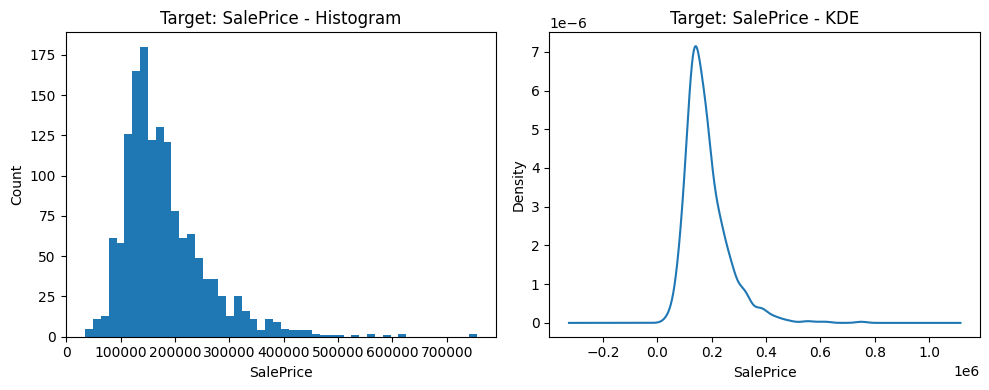

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df[TARGET].dropna(), bins=50)
plt.title(f"Target: {TARGET} - Histogram")
plt.xlabel(TARGET)
plt.ylabel("Count")

plt.subplot(1,2,2)
df[TARGET].plot.kde()
plt.title(f"Target: {TARGET} - KDE")
plt.xlabel(TARGET)
plt.tight_layout()
plt.show()

### Correlation heatmap

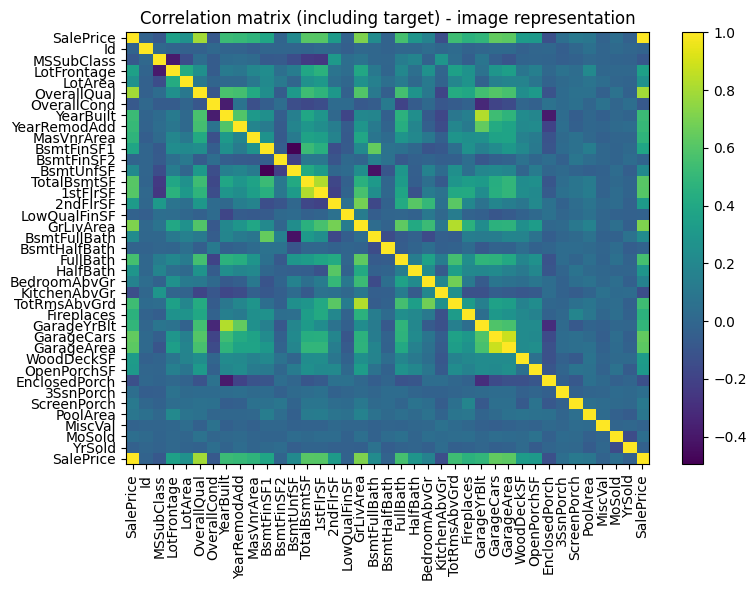

In [16]:
if len(num_cols) > 1:
    corr = df[[TARGET] + num_cols].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, aspect='auto')
    plt.colorbar()
    plt.title("Correlation matrix (including target) - image representation")
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.tight_layout()
    plt.show()

In [17]:
numeric_for_corr = df.select_dtypes(include=['int64','float64']).columns.tolist()
if len(numeric_for_corr) > 60:
    variances = df[numeric_for_corr].var().sort_values(ascending=False)
    numeric_for_corr = variances.head(60).index.tolist()

corrmat = df[numeric_for_corr].corr()
# Print top absolute correlations with target
if TARGET in corrmat.columns:
    top_abs_corr = corrmat[TARGET].abs().sort_values(ascending=False).head(20)
    print("Top absolute correlations with target (numeric):")
    print(top_abs_corr)
print("-" * 80)

Top absolute correlations with target (numeric):
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64
--------------------------------------------------------------------------------


---
#### Scatter matrix (pairplot) for top correlated numeric features

<Figure size 1200x1200 with 0 Axes>

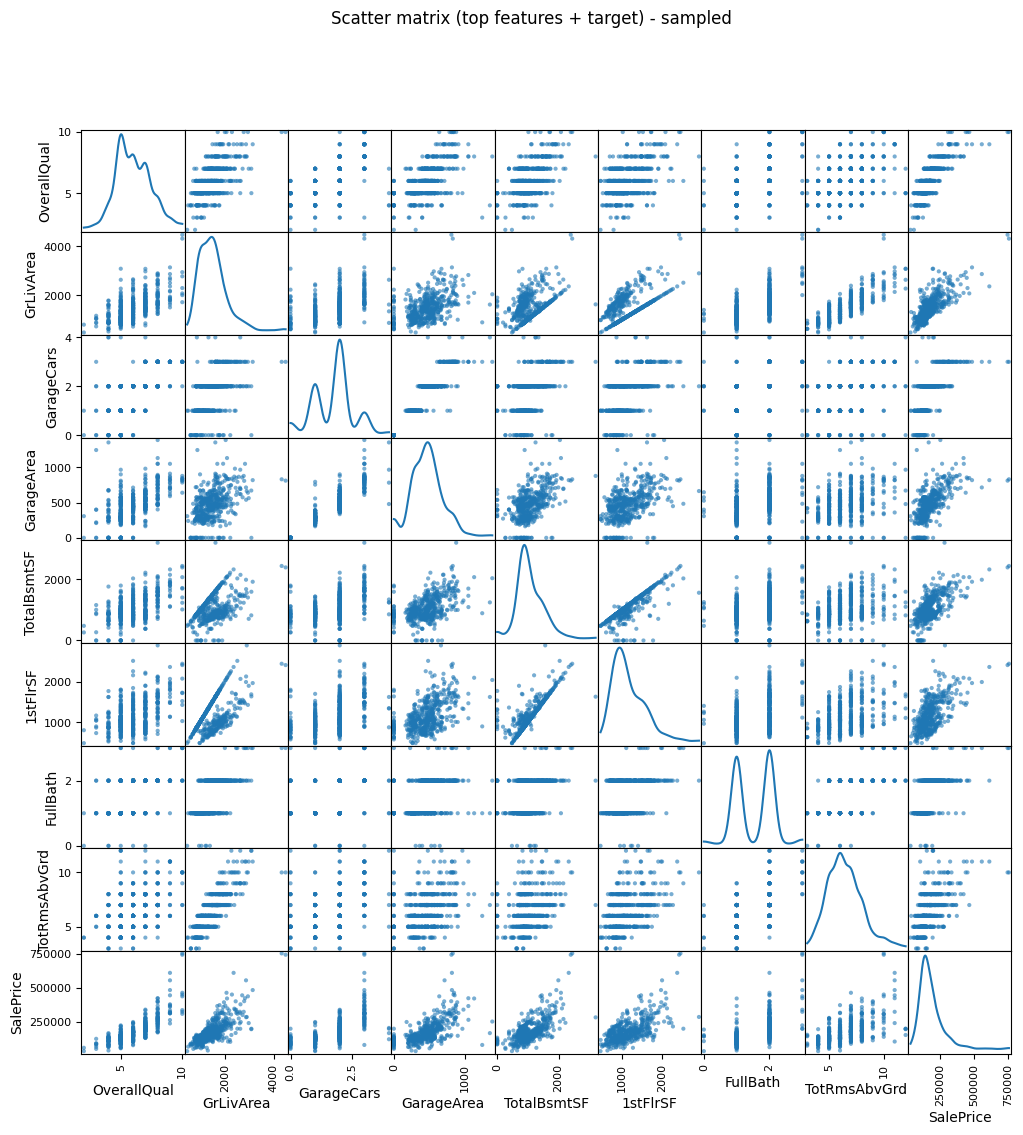

Interpretation: Scatter matrix helps detect pairwise linear or non-linear relationships and clusters.
--------------------------------------------------------------------------------


In [18]:
if TARGET in corrmat.columns:
    top_feats = corrmat[TARGET].abs().sort_values(ascending=False).index.drop(TARGET).tolist()[:8]
else:
    top_feats = numeric_cols[:8]

if len(top_feats) > 1:
    sample = df[top_feats + [TARGET]].dropna()
    if len(sample) > scatter_matrix_sample:
        sample = sample.sample(n=scatter_matrix_sample, random_state=42)
    plt.figure(figsize=(12, 12))
    scatter_matrix(sample, alpha=0.6, diagonal='kde', figsize=(12,12))
    plt.suptitle("Scatter matrix (top features + target) - sampled")
    plt.show()
    print("Interpretation: Scatter matrix helps detect pairwise linear or non-linear relationships and clusters.")
else:
    print("Not enough features to draw a scatter matrix.")
print("-" * 80)

---
###  Numeric features:


---
####Combined: histogram, boxplot, KDE

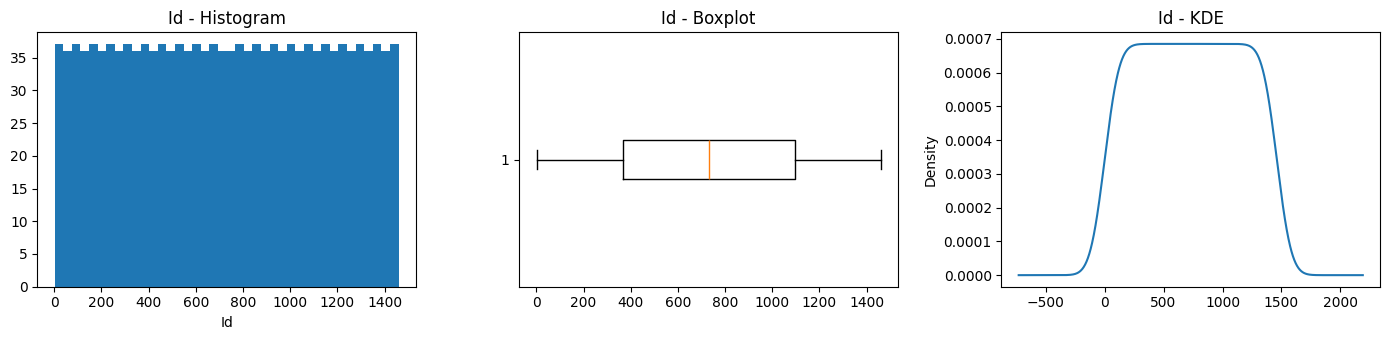

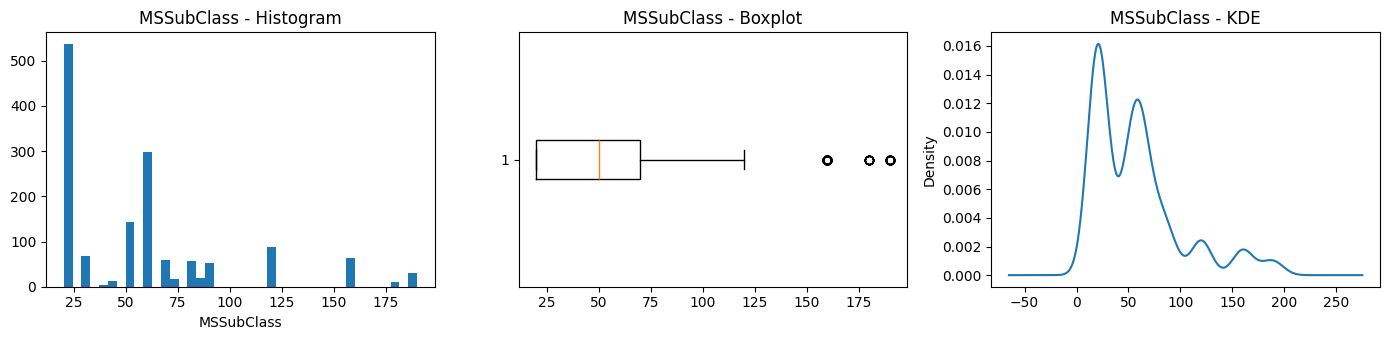

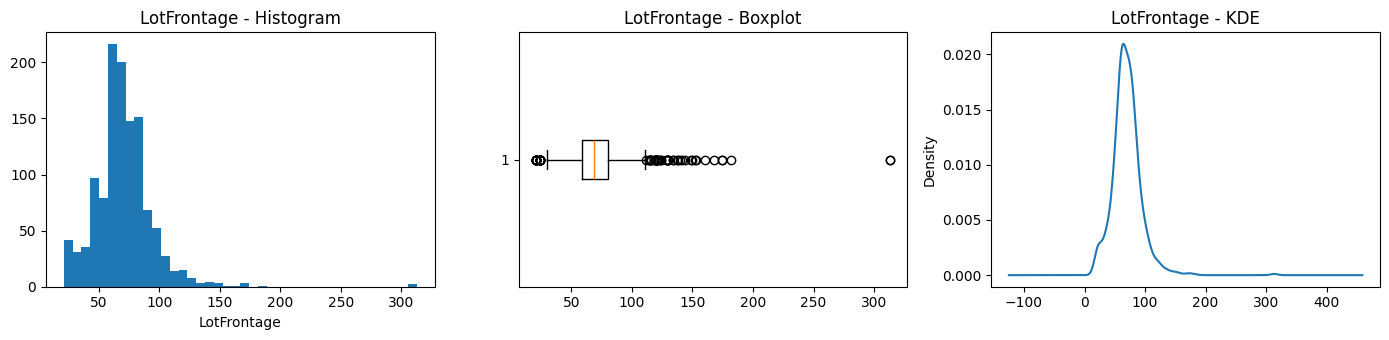

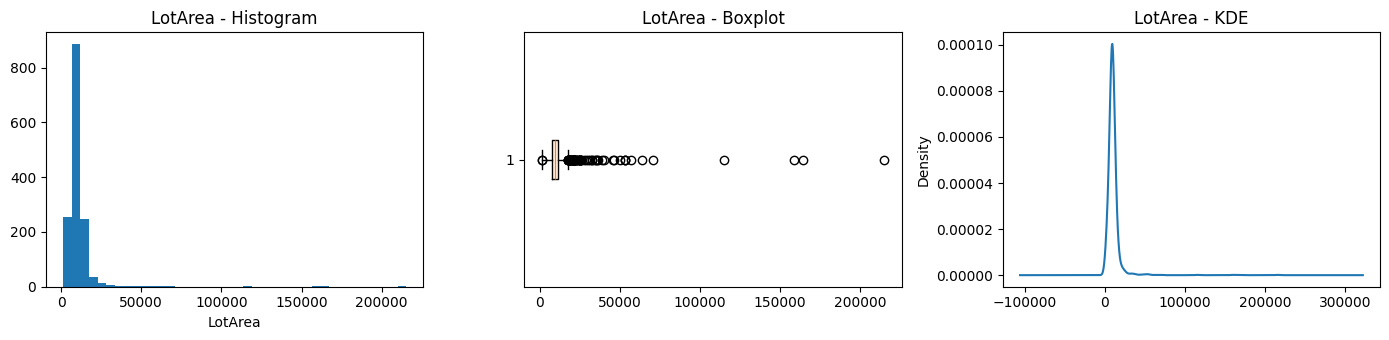

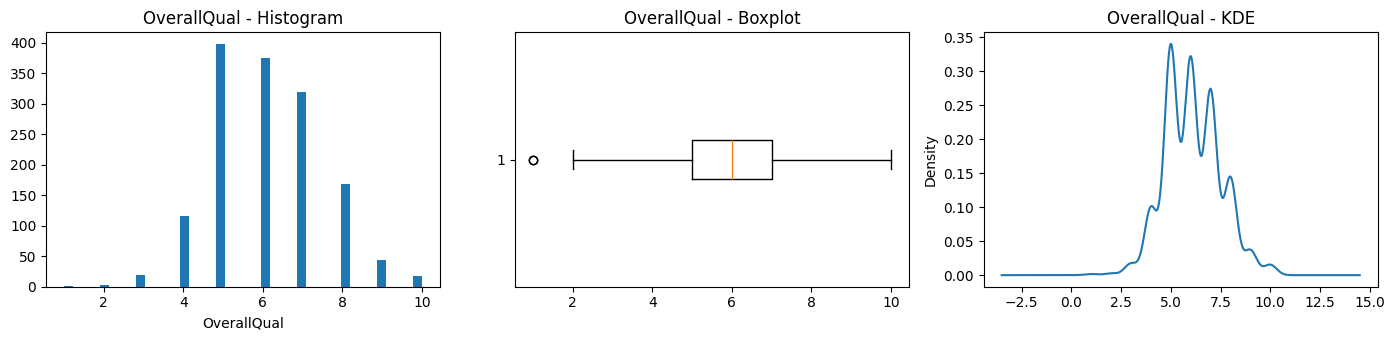

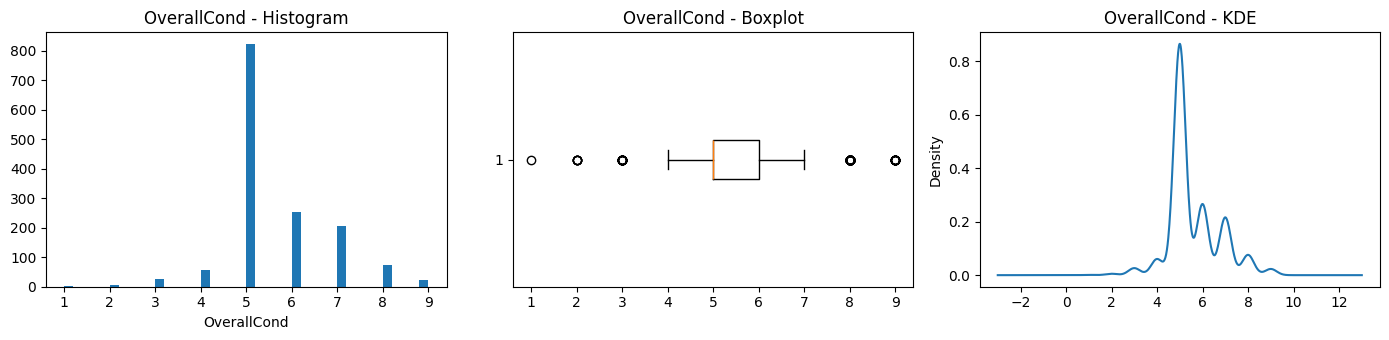

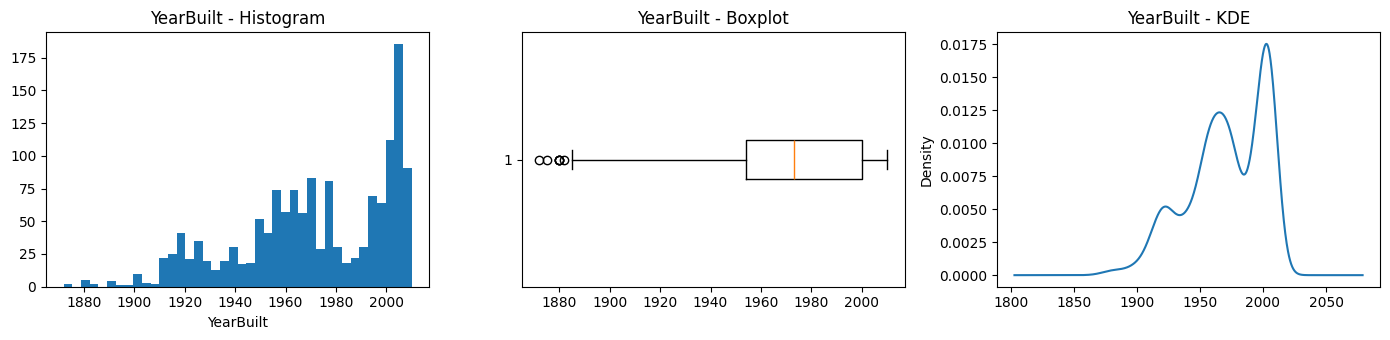

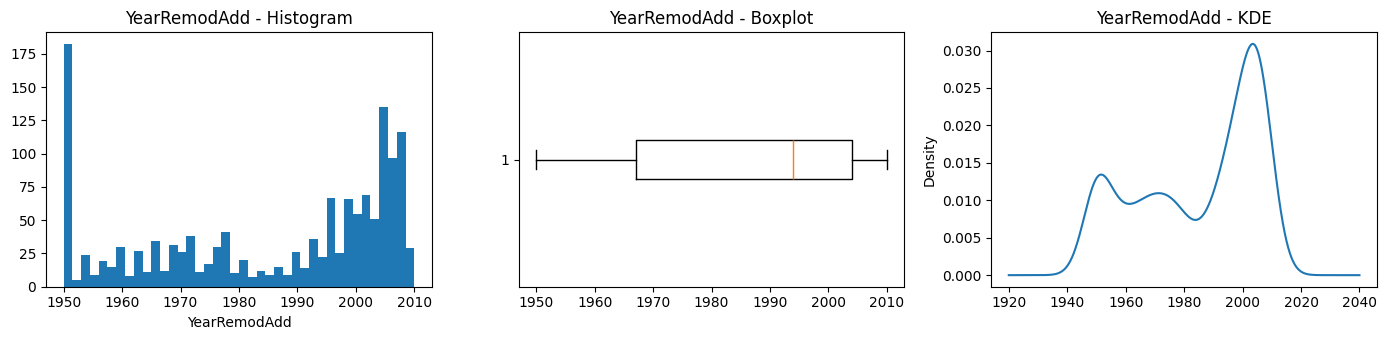

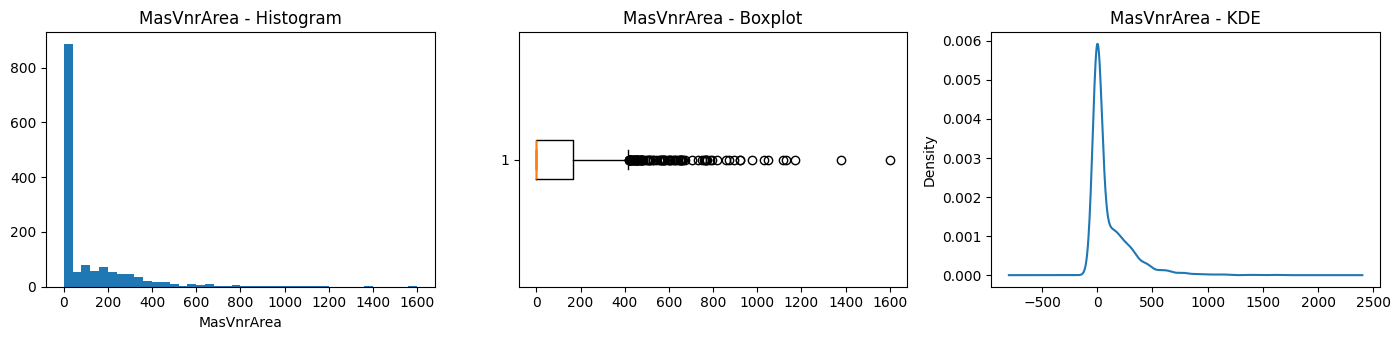

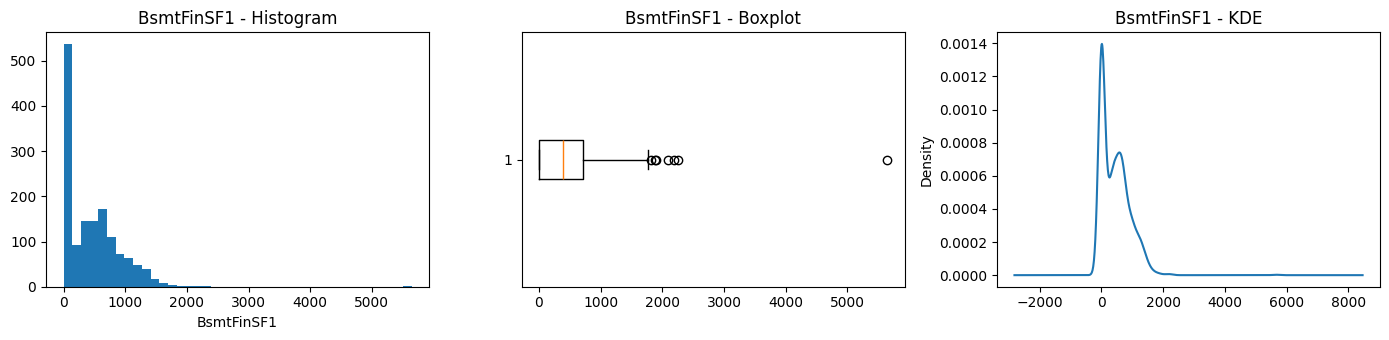

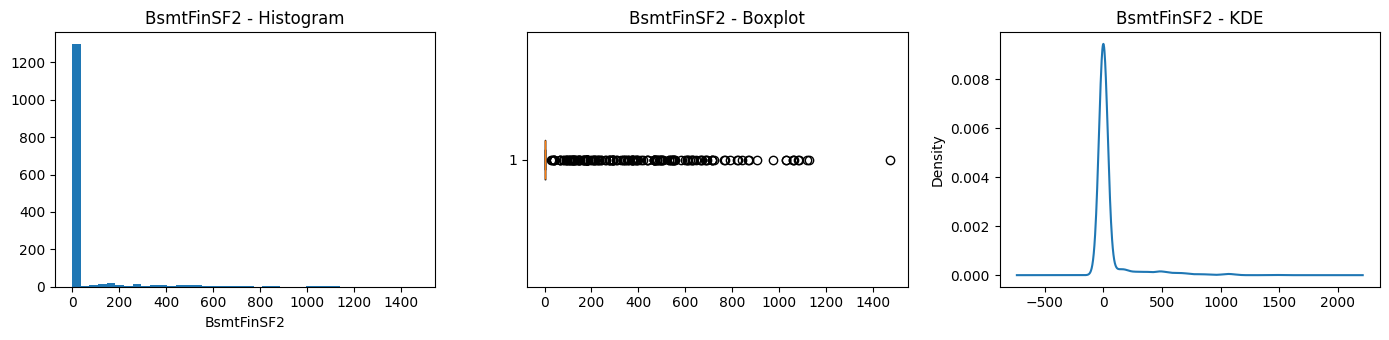

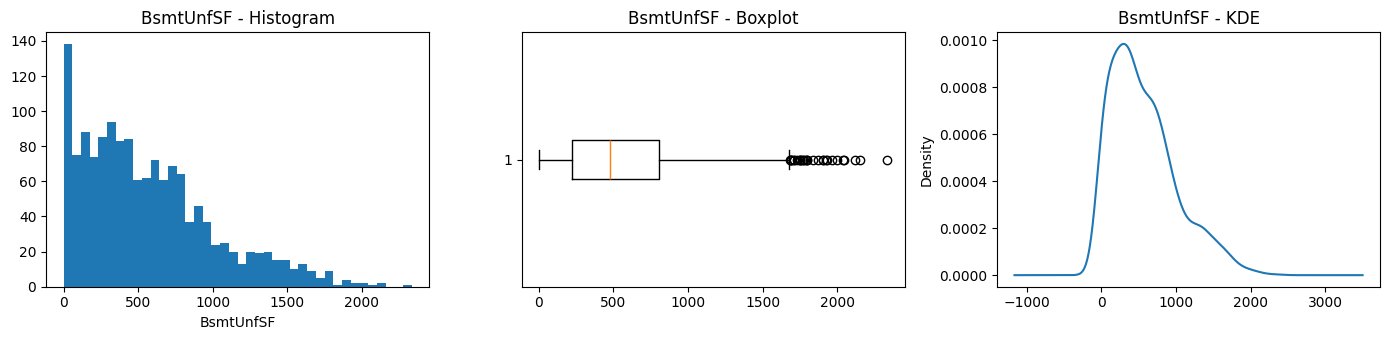

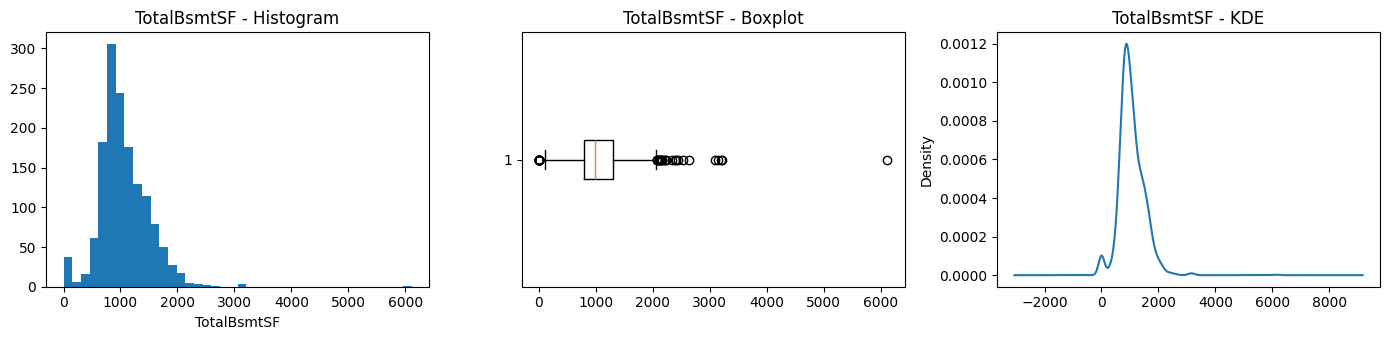

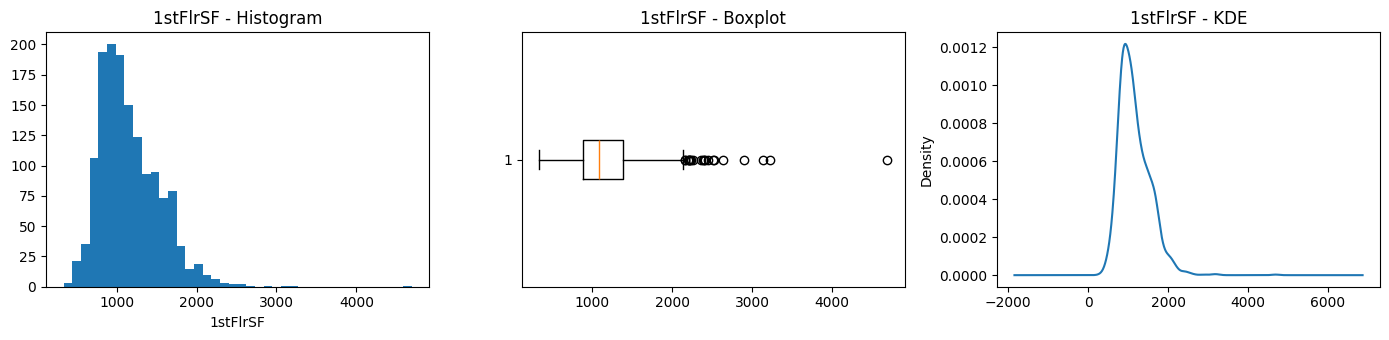

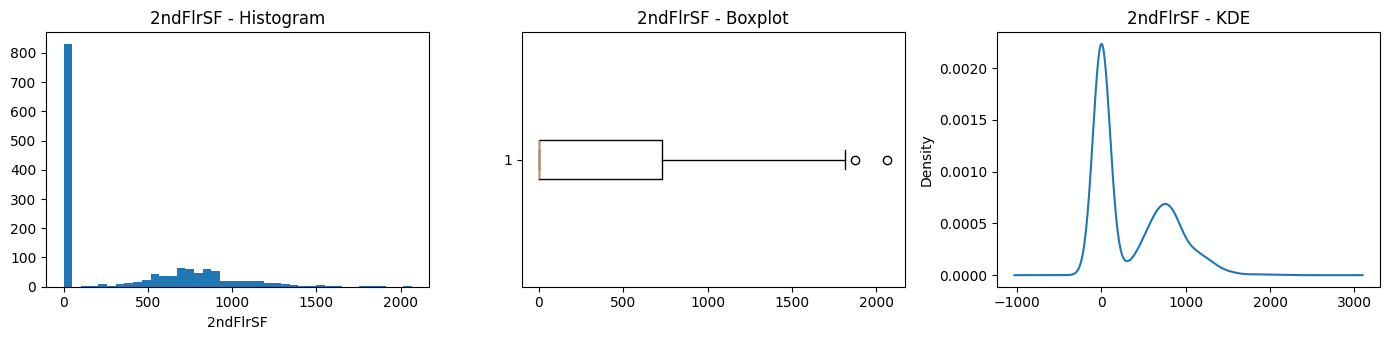

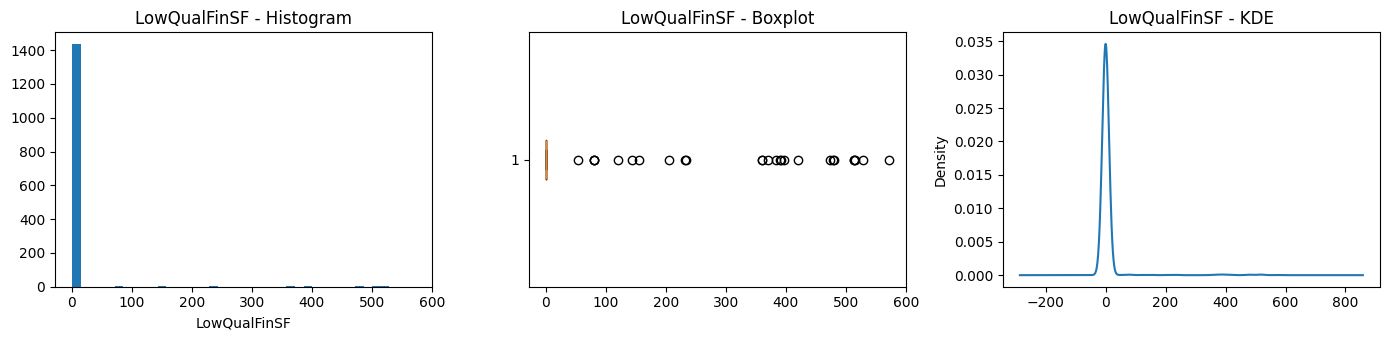

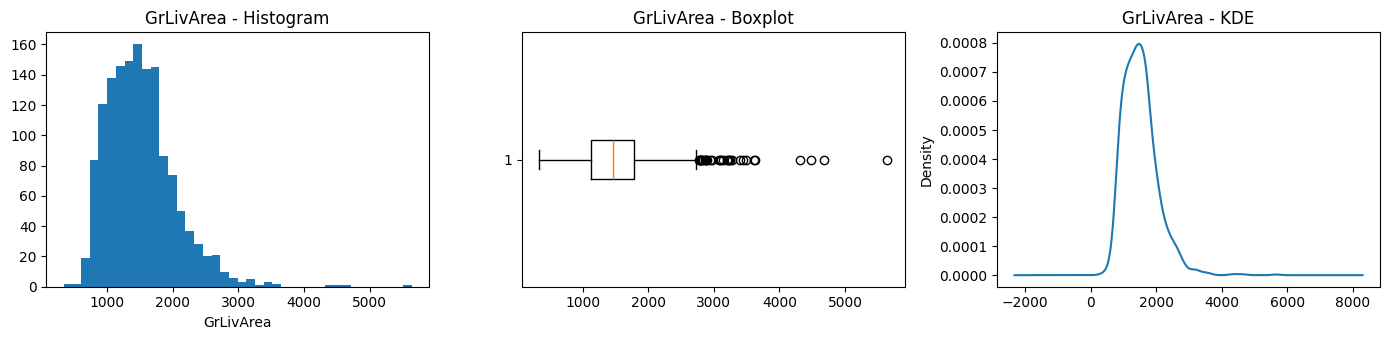

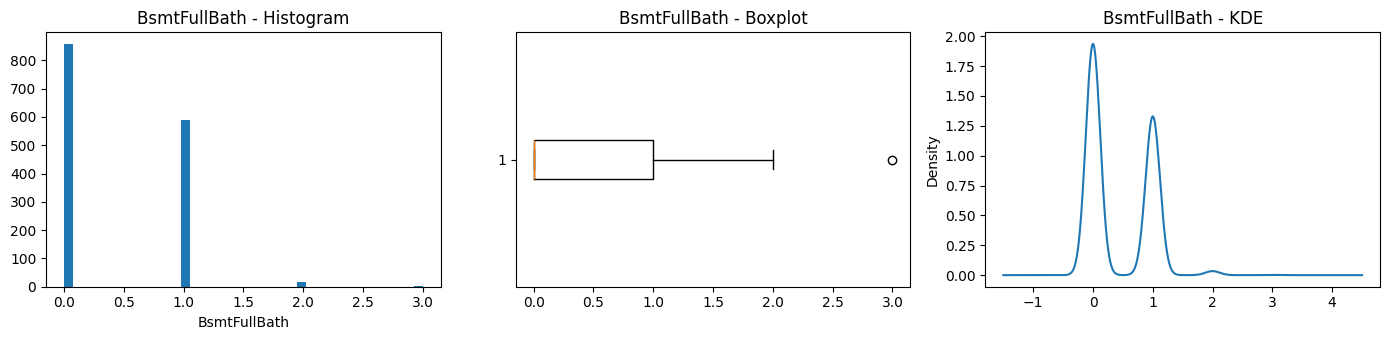

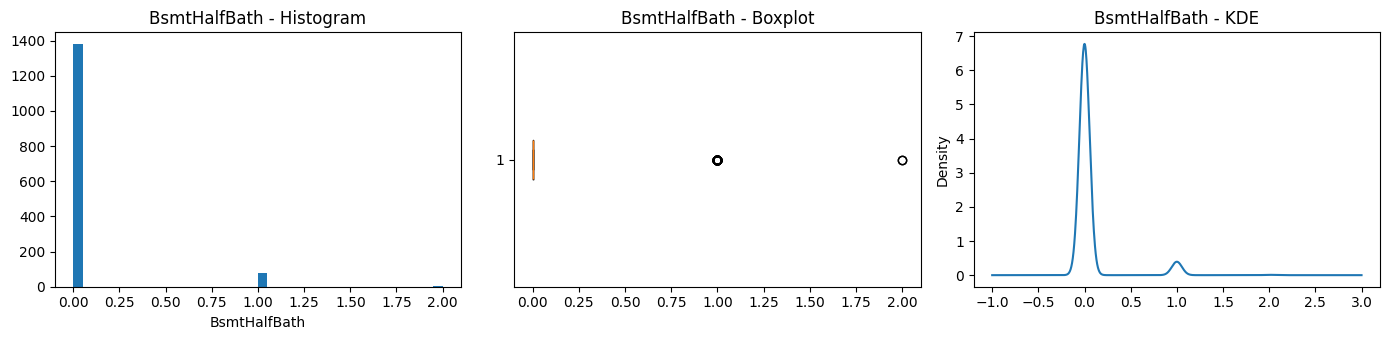

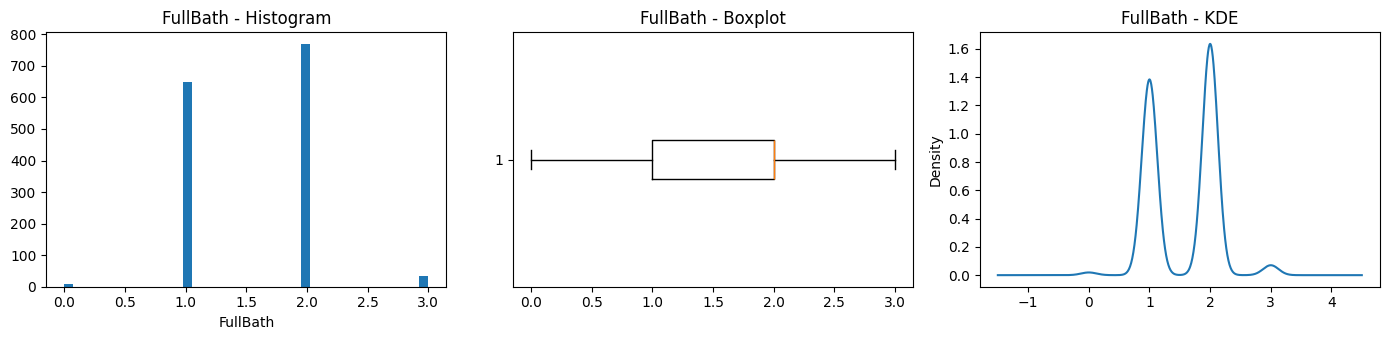

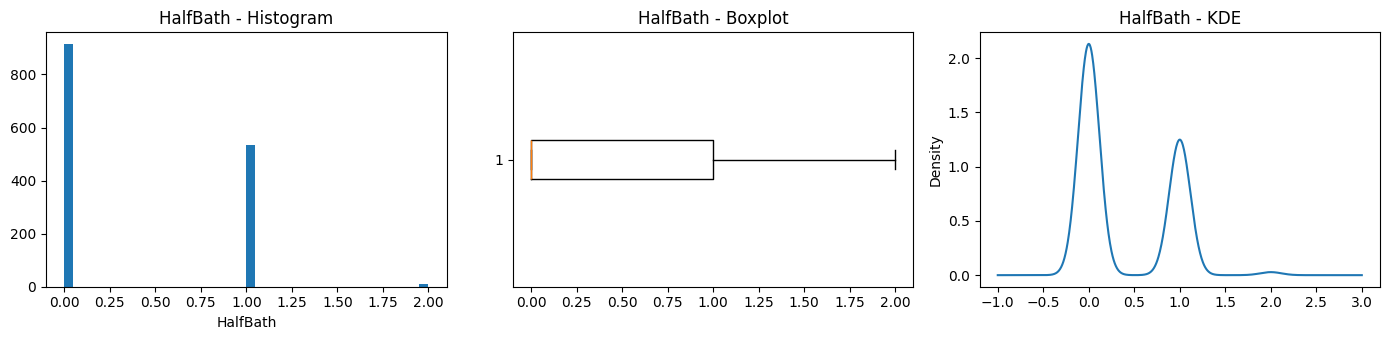

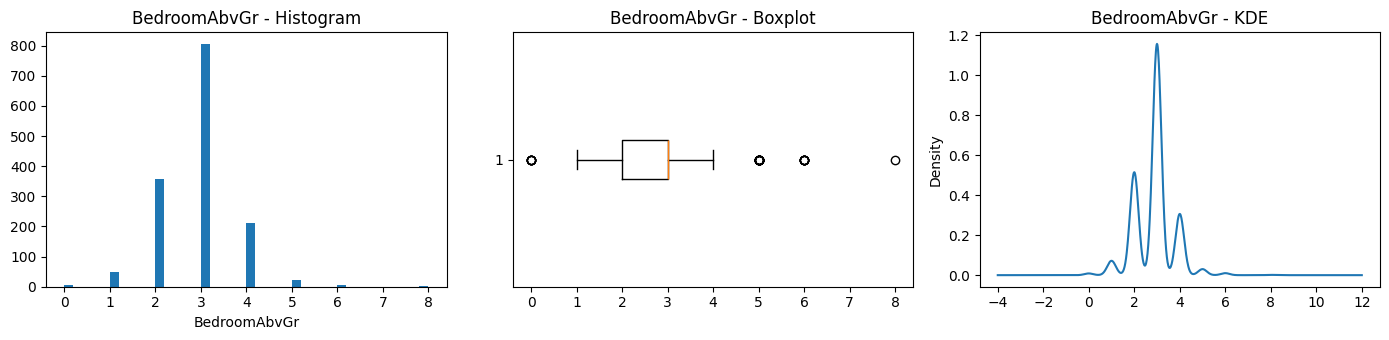

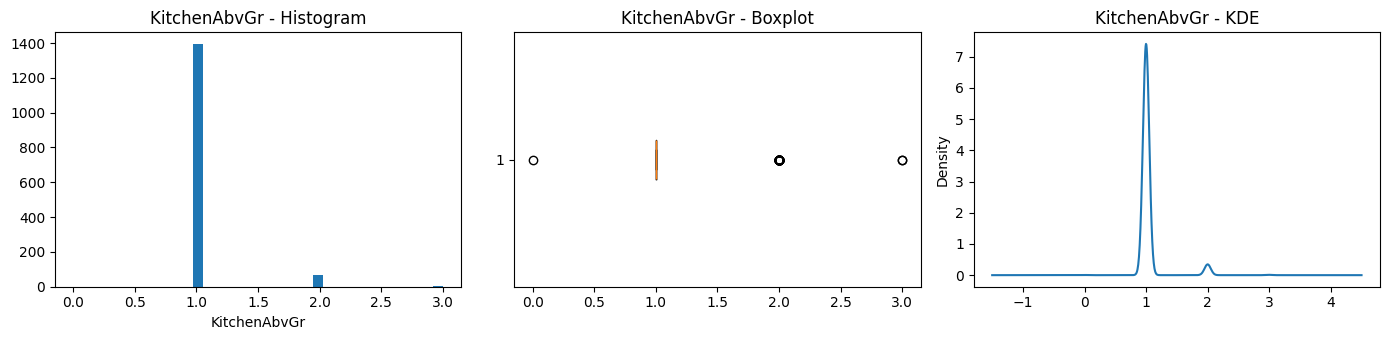

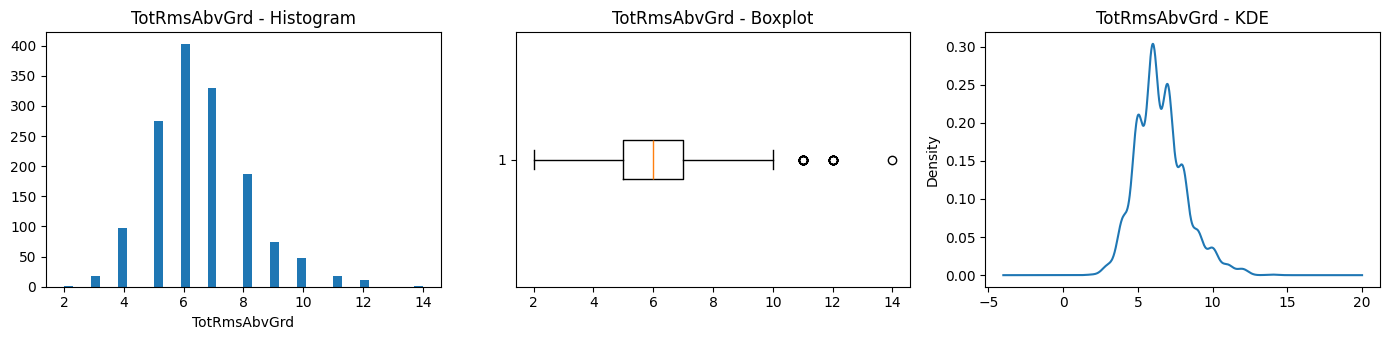

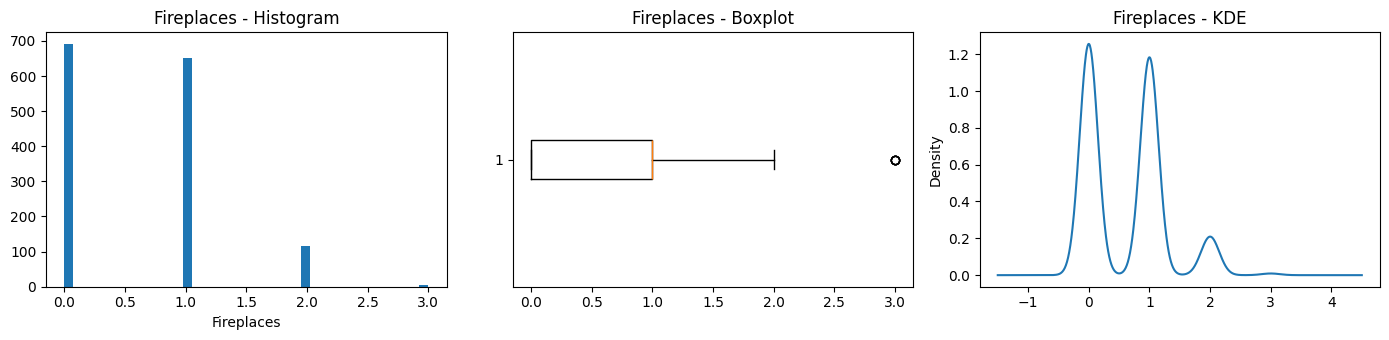

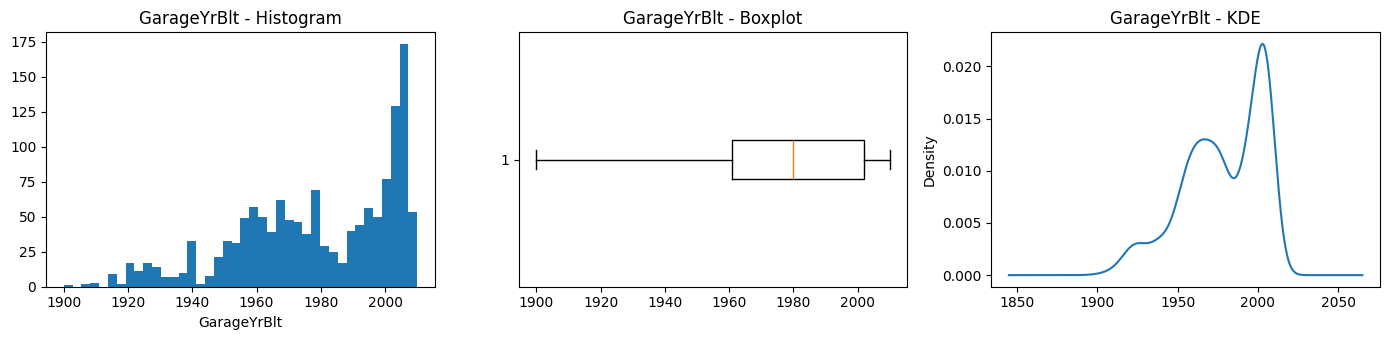

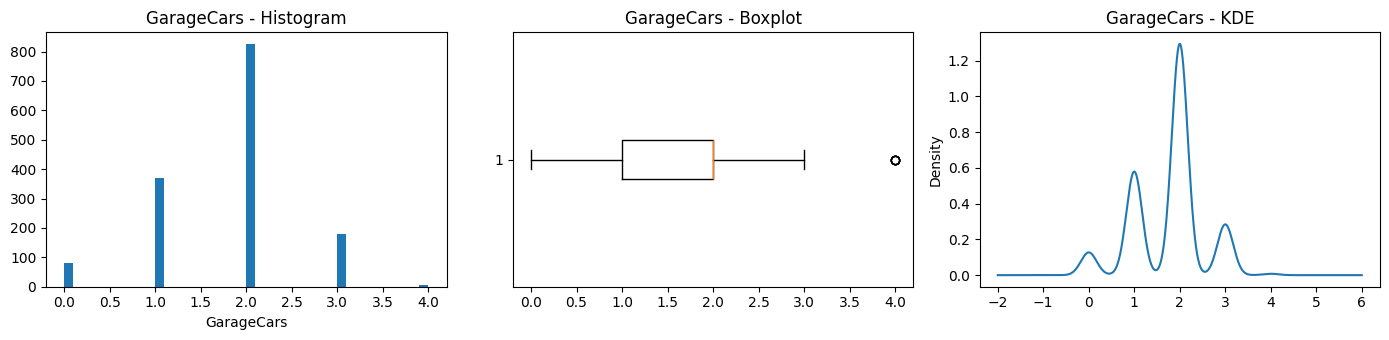

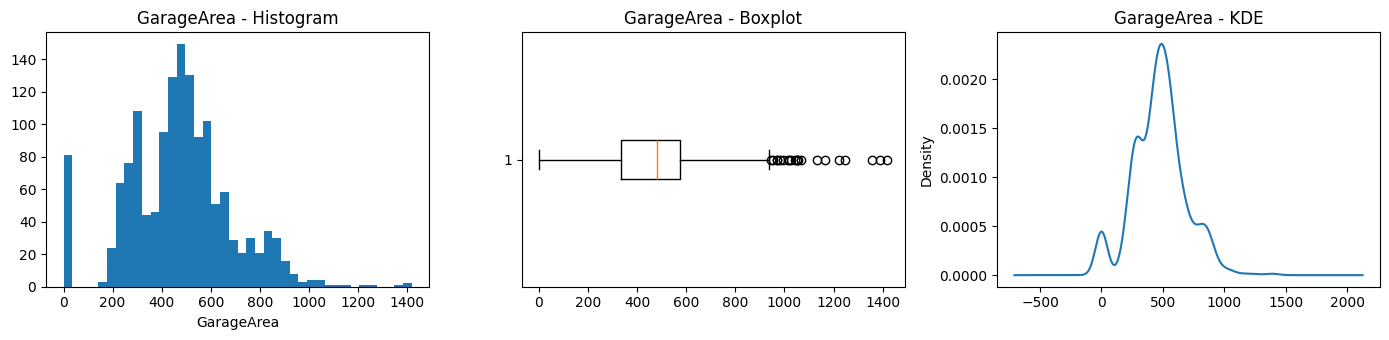

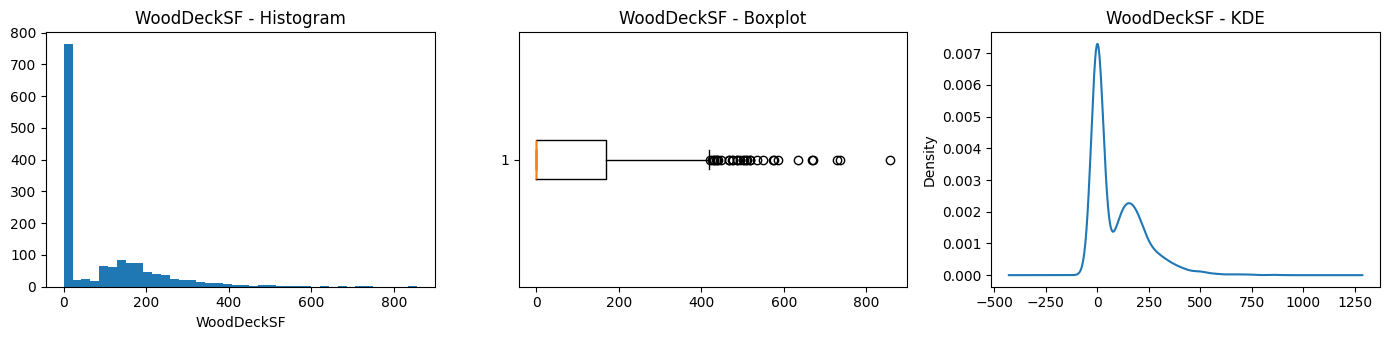

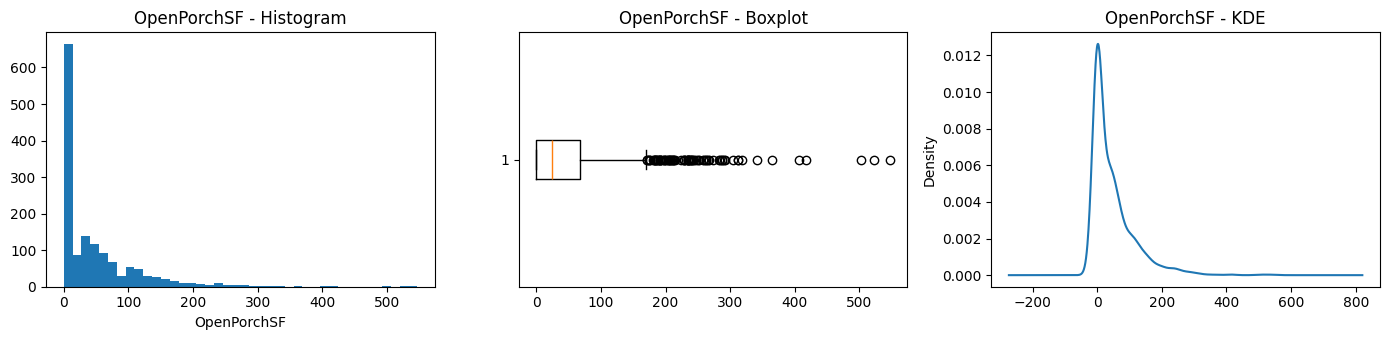

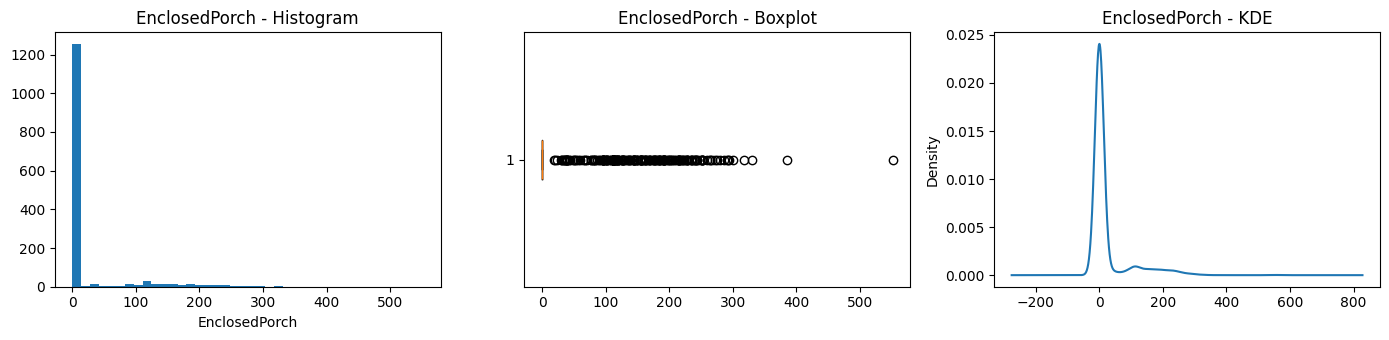

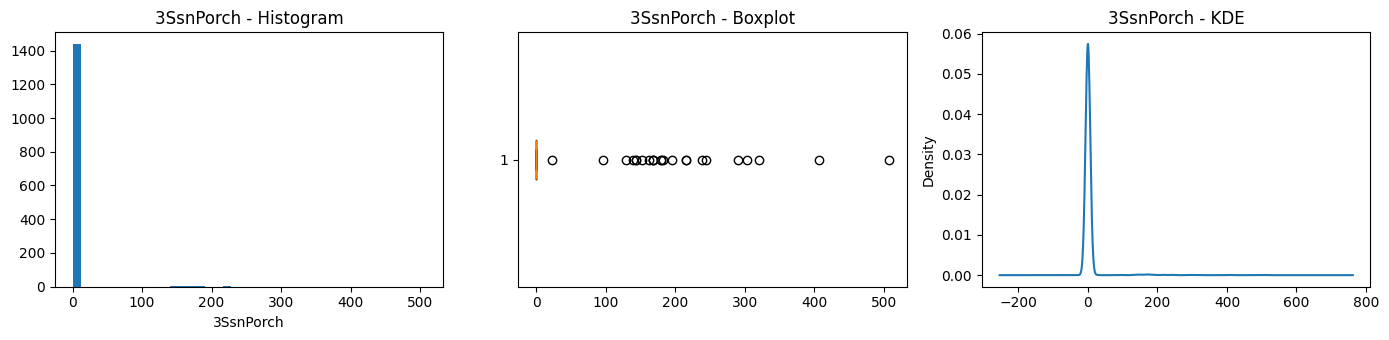

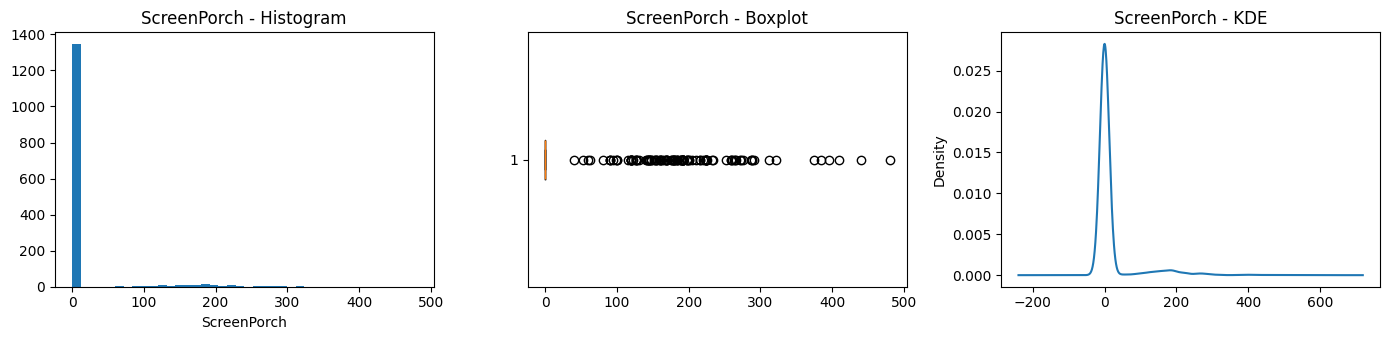

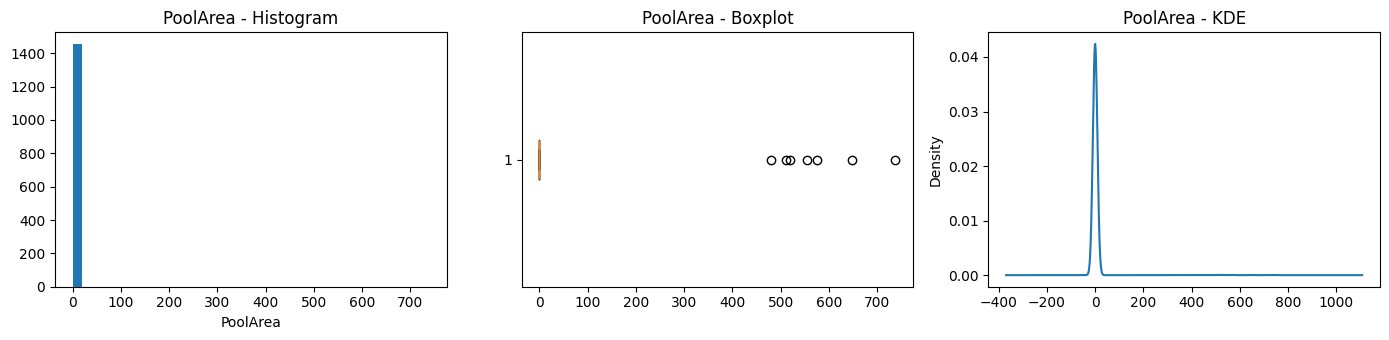

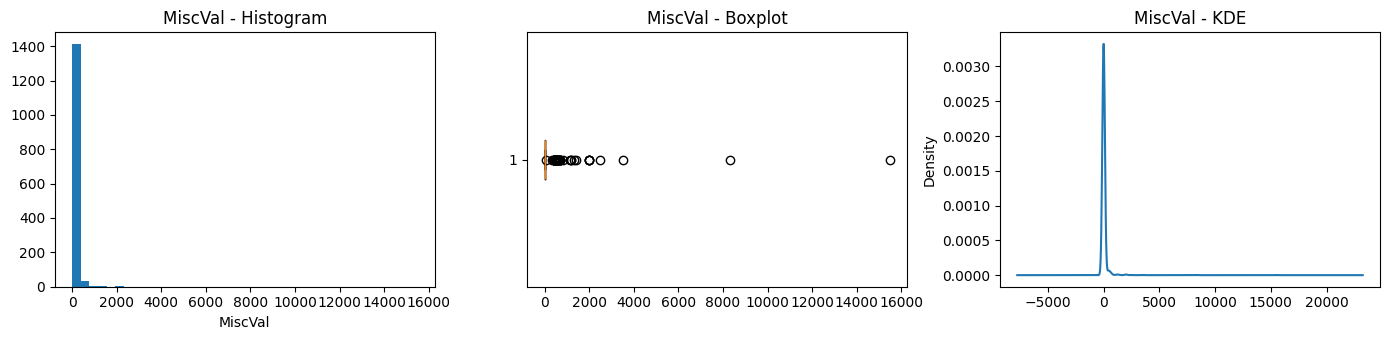

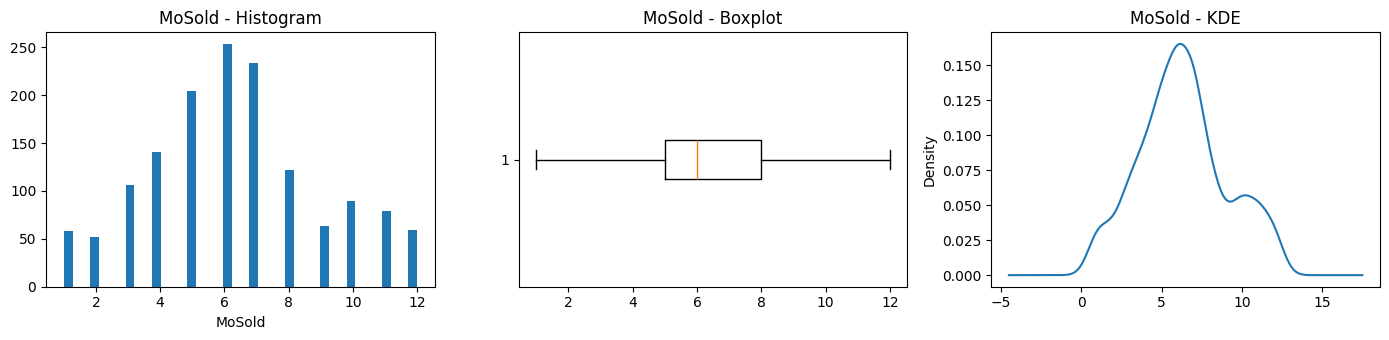

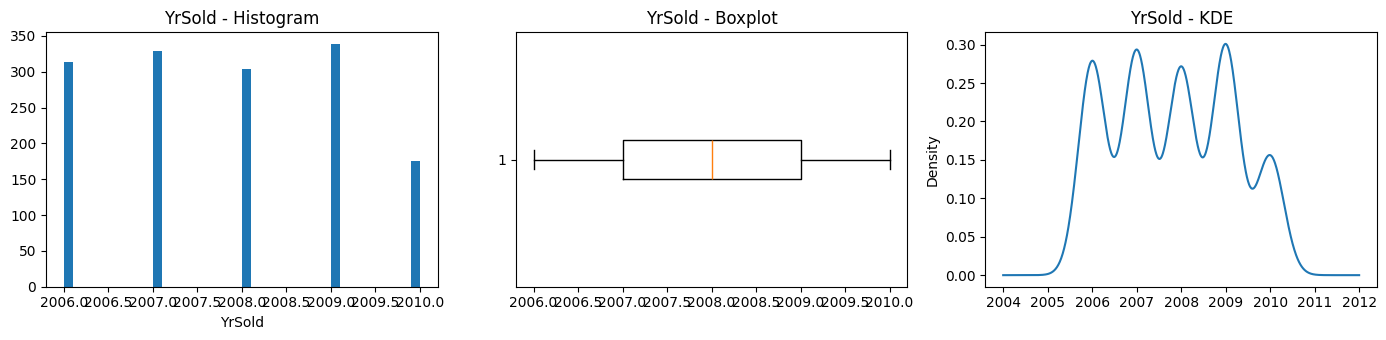

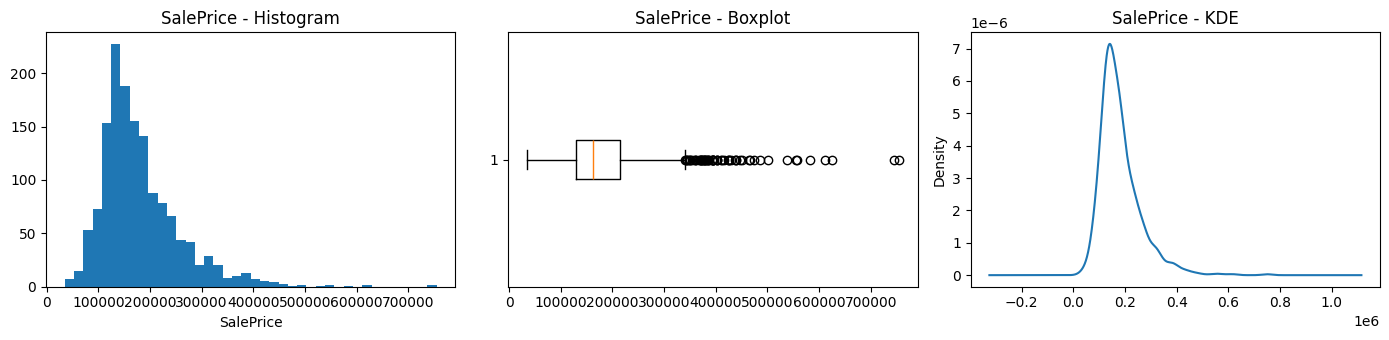

In [19]:
# Helper: linear regression line for scatter plot
def regression_line(x, y):
    mask = (~np.isnan(x)) & (~np.isnan(y))
    if mask.sum() < 2:
        return None, None
    coef = np.polyfit(x[mask], y[mask], 1)
    xs = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 100)
    ys = coef[0] * xs + coef[1]
    return xs, ys

numeric_to_plot = num_cols if numeric_plot_limit is None else num_cols[:numeric_plot_limit]
for col in numeric_to_plot:
    series = df[col]
    if series.nunique(dropna=True) <= 1:
        # skip constant columns
        continue

    # Combined: histogram, boxplot, KDE
    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
    axes[0].hist(series.dropna(), bins=40)
    axes[0].set_title(f"{col} - Histogram")
    axes[0].set_xlabel(col)

    axes[1].boxplot(series.dropna(), vert=False)
    axes[1].set_title(f"{col} - Boxplot")

    try:
        series.plot.kde(ax=axes[2])
        axes[2].set_title(f"{col} - KDE")
    except Exception:
        axes[2].text(0.5, 0.5, "KDE not available", ha='center')
        axes[2].set_title(f"{col} - KDE")

    plt.tight_layout()
    plt.show()

---
#### Scatter vs target with fit line

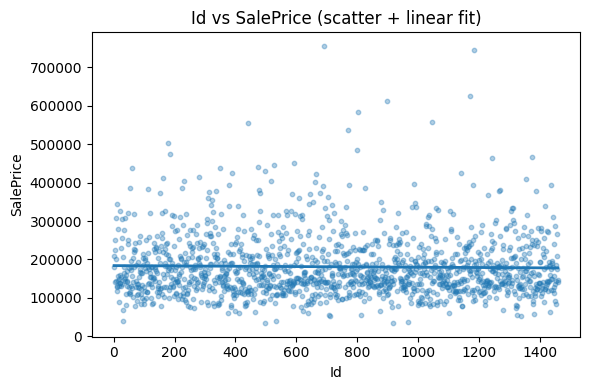

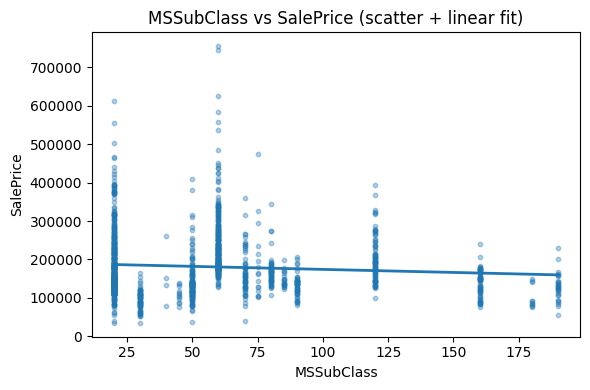

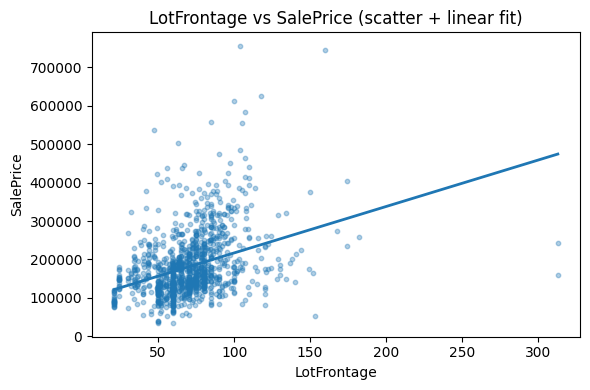

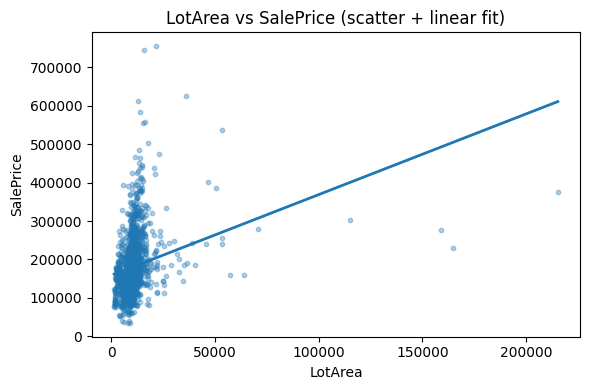

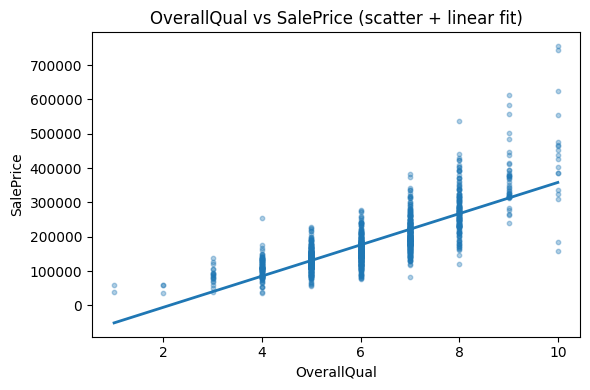

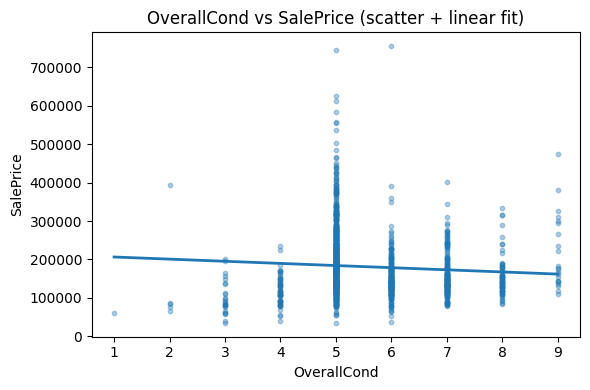

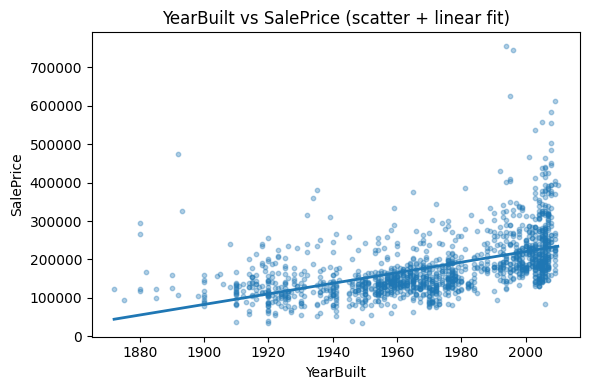

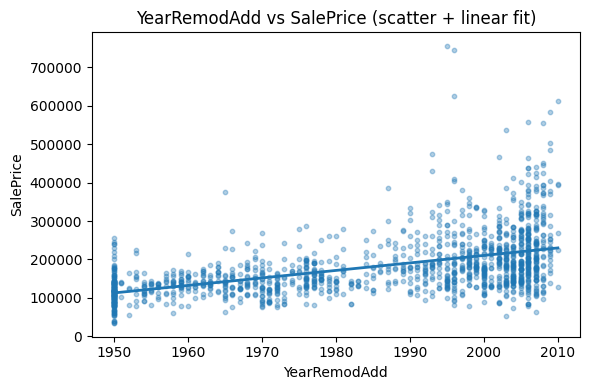

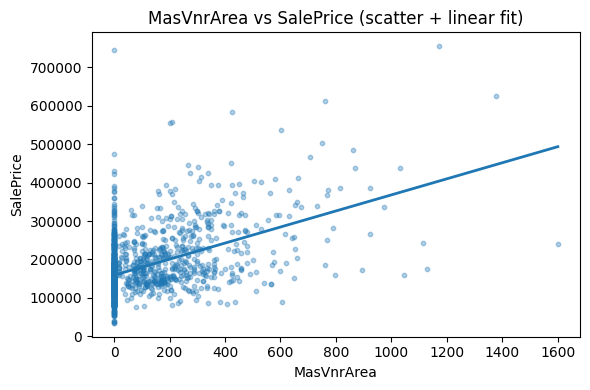

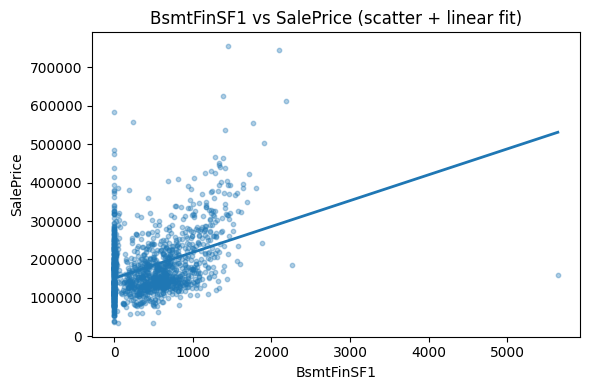

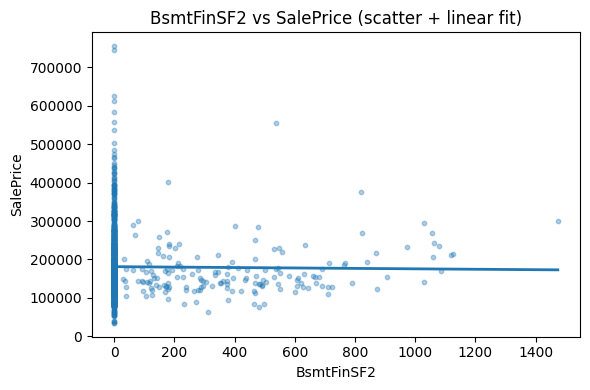

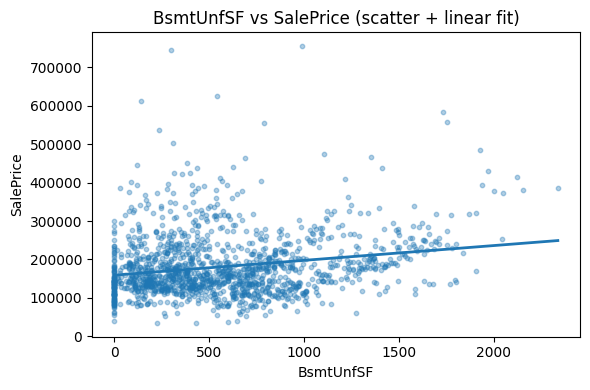

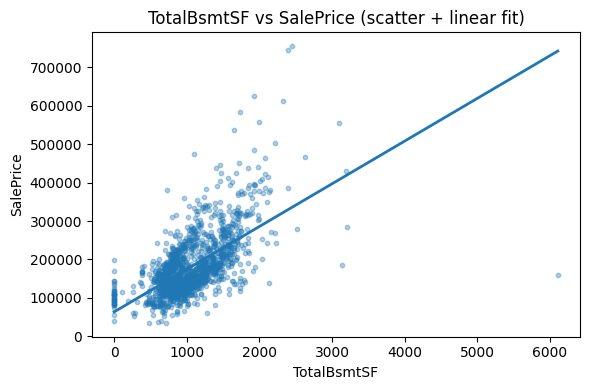

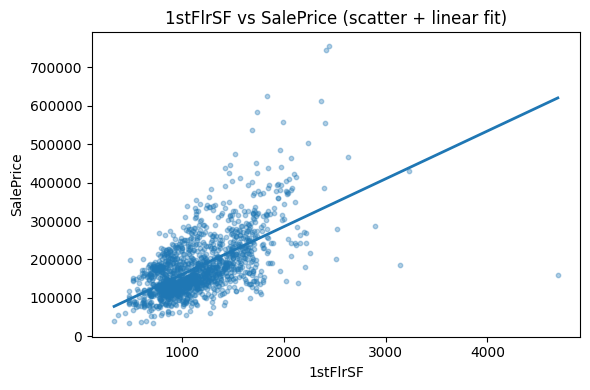

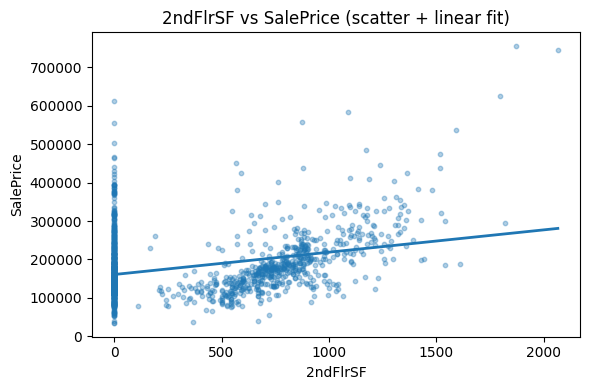

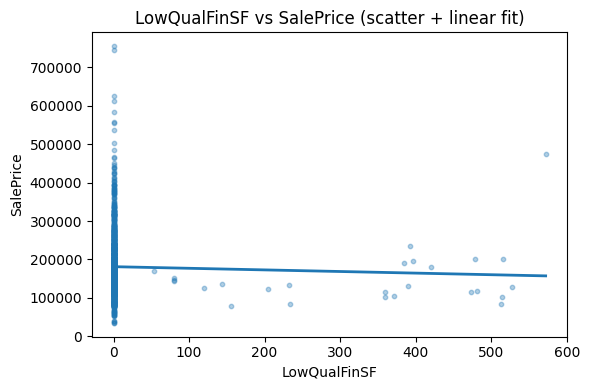

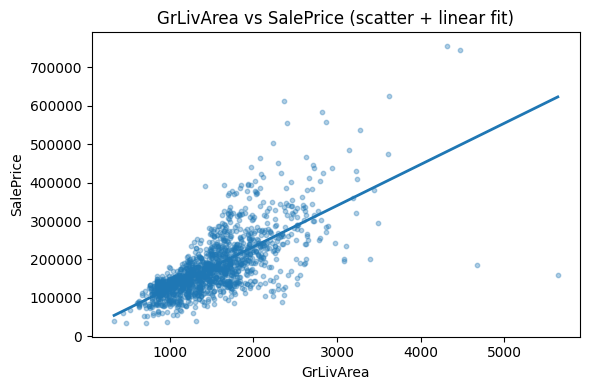

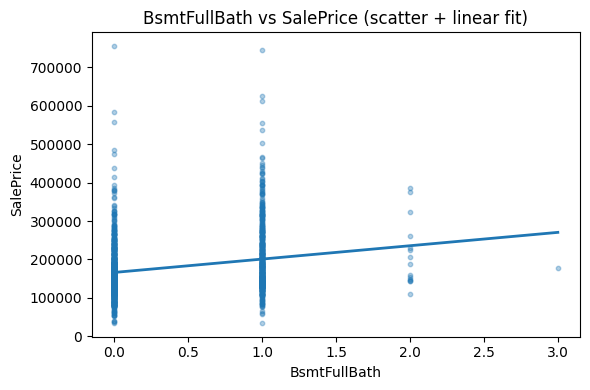

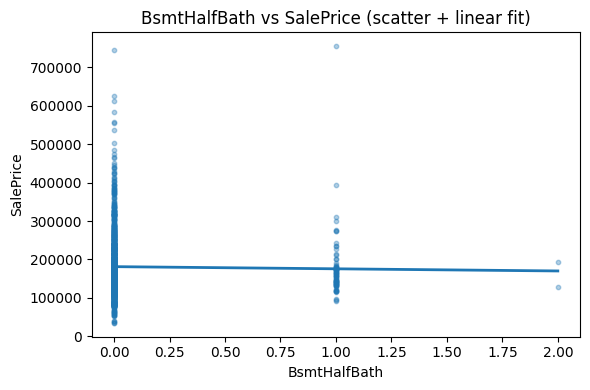

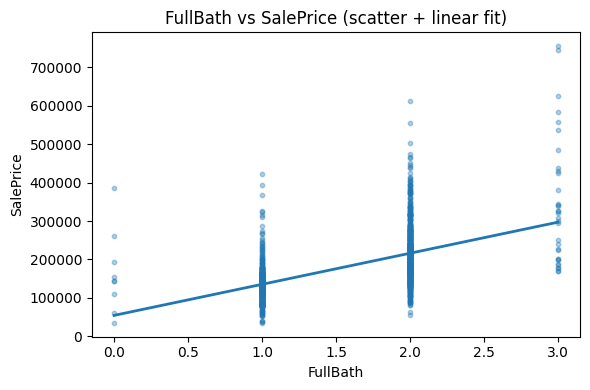

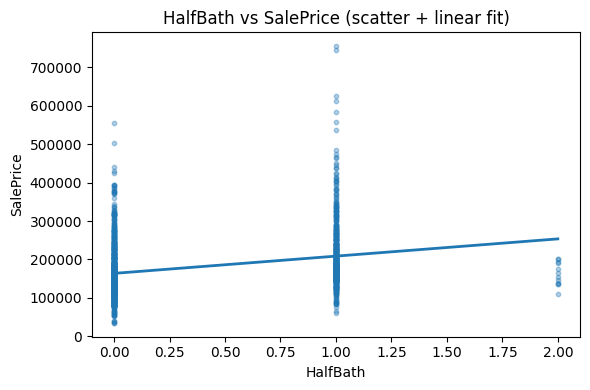

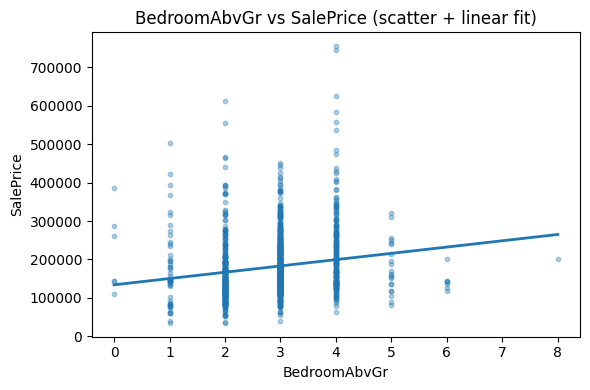

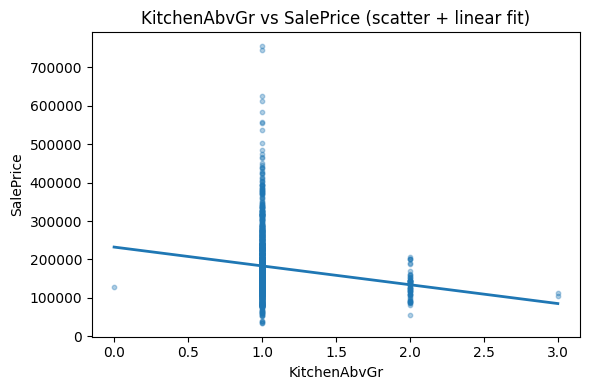

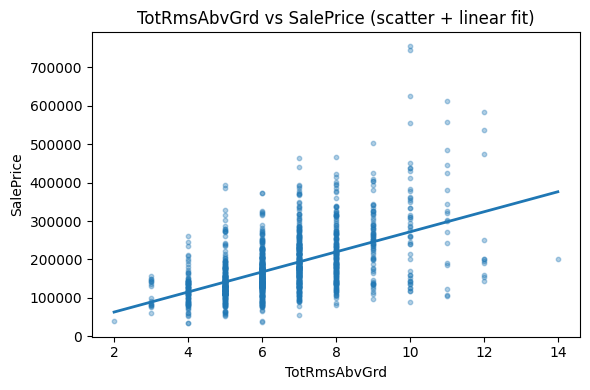

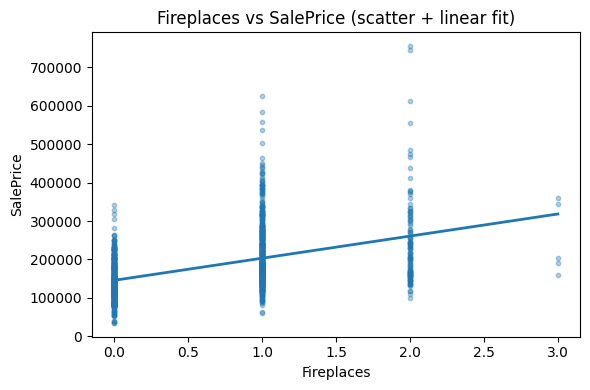

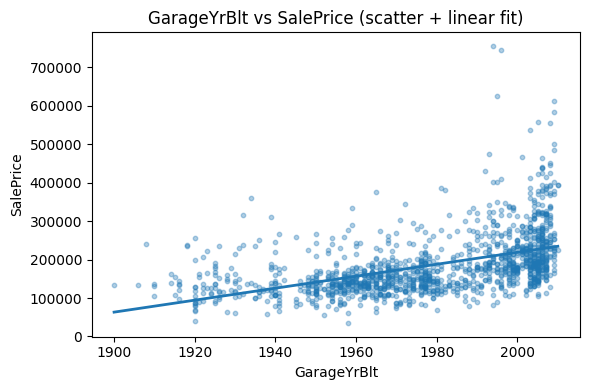

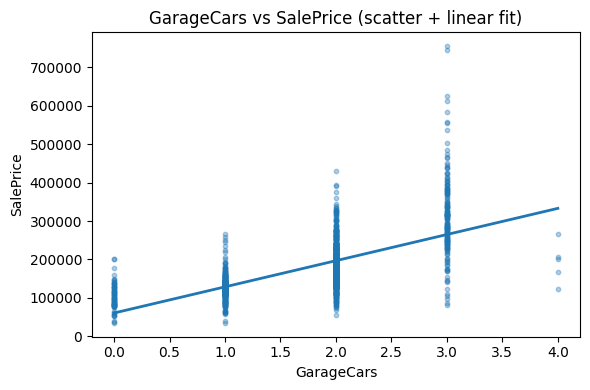

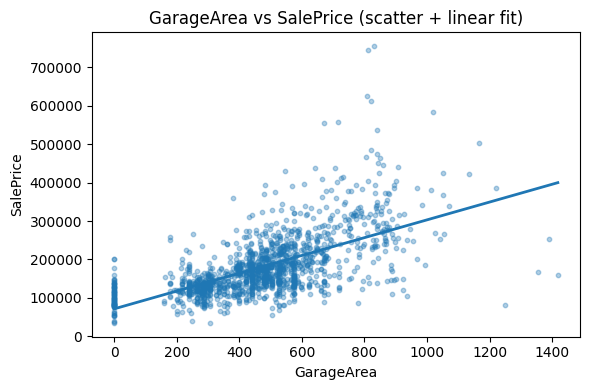

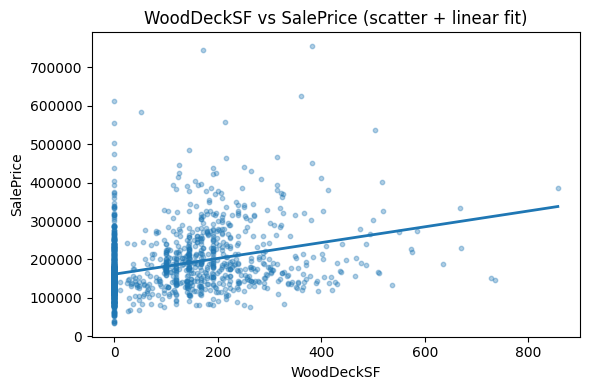

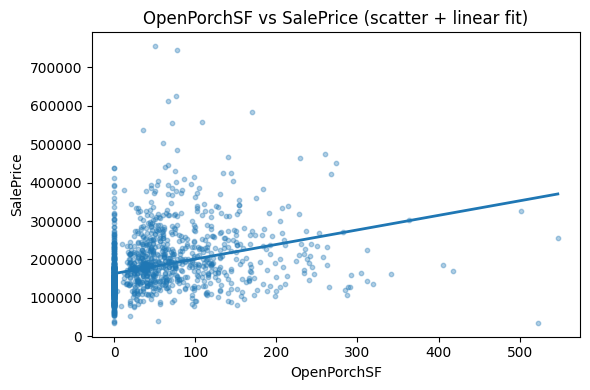

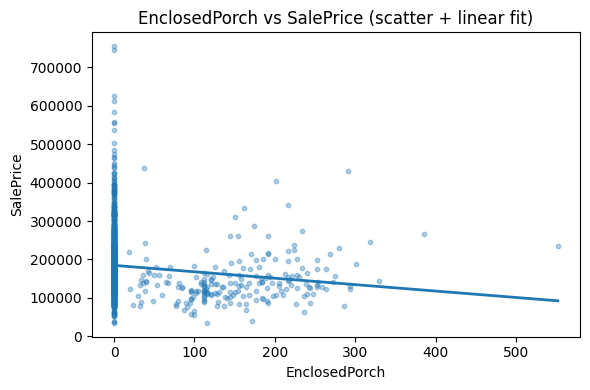

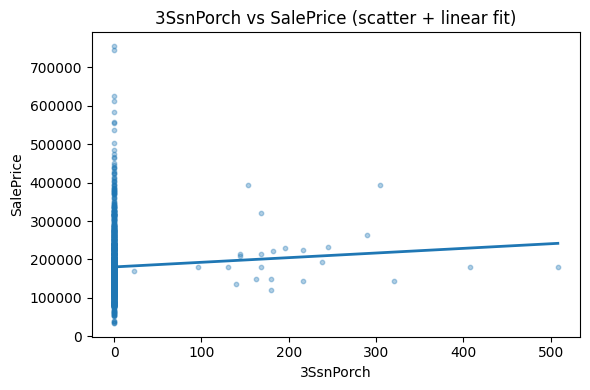

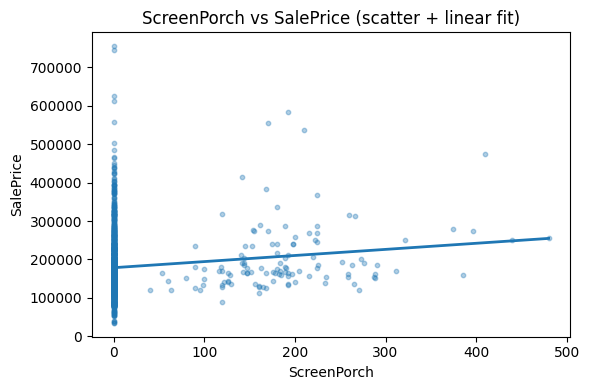

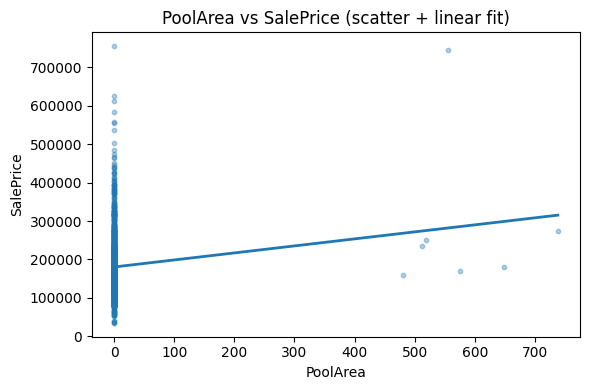

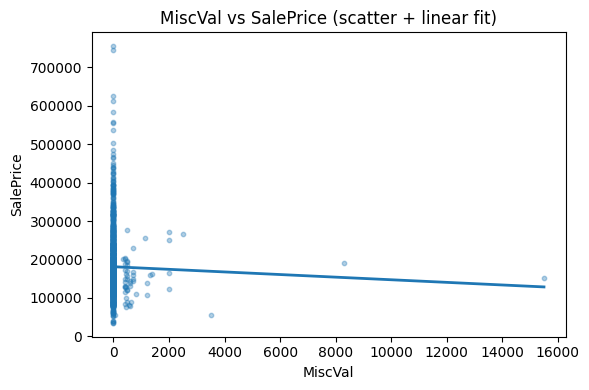

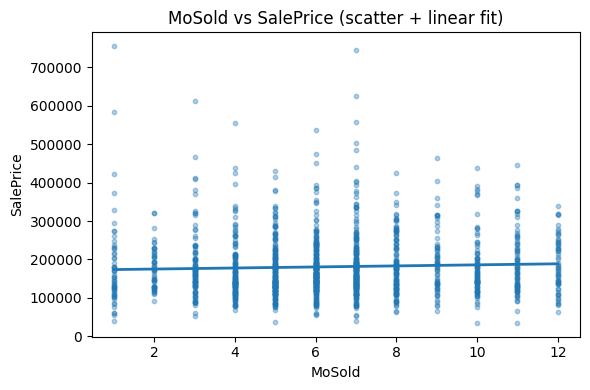

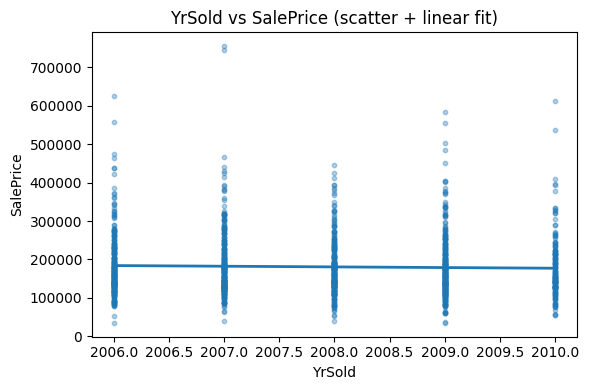

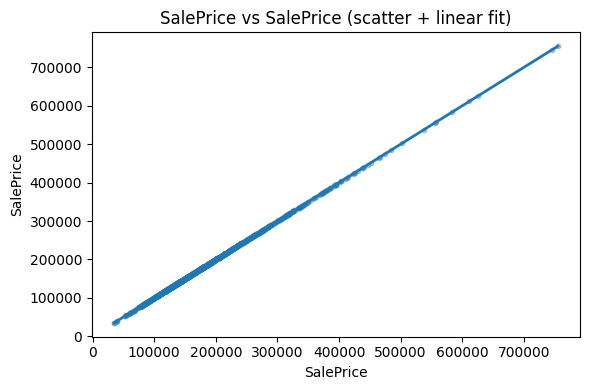

39

In [20]:
i = 1
for col in numeric_to_plot:
    series = df[col]
    if series.nunique(dropna=True) <= 1:
        # skip constant columns
        continue
    plt.figure(figsize=(6,4))
    x = df[col].astype(float).values
    y = df[TARGET].astype(float).values
    plt.scatter(x, y, alpha=0.35, s=10)
    xs, ys = regression_line(x, y)
    if xs is not None:
        plt.plot(xs, ys, linewidth=2)
    plt.title(f"{col} vs {TARGET} (scatter + linear fit)")
    plt.xlabel(col)
    plt.ylabel(TARGET)
    plt.tight_layout()
    plt.show()
    i += 1
i

In [21]:
for col in numeric_to_plot:
    series = df[col]
    if series.nunique(dropna=True) <= 1:
        # skip constant columns
        continue
    # Interpretation hints
    corr = df[[col, TARGET]].dropna().corr().iloc[0, 1]
    missing = df[col].isnull().sum()
    print(f"Feature: {col} | Non-null: {df[col].notnull().sum()} | Missing: {missing} | Corr with target: {corr:.3f}")
    if abs(corr) > 0.6:
        print("  -> Very strong linear relationship with target. Consider as key predictor (or transform if non-linear).")
    elif abs(corr) > 0.3:
        print("  -> Moderate linear relationship with target; good candidate feature.")
    elif abs(corr) > 0.1:
        print("  -> Weak linear relationship; consider non-linear transforms or interactions.")
    else:
        print("  -> Little or no linear relationship with target; may still be useful in non-linear models or in interactions.")
    if missing > 0:
        print("  -> Contains missing values; consider imputation or special handling.")
    if series.skew() > 1 or series.skew() < -1:
        print("  -> This feature is skewed; consider log/sqrt transform for modeling.")
    print("-" * 80)


Feature: Id | Non-null: 1460 | Missing: 0 | Corr with target: -0.022
  -> Little or no linear relationship with target; may still be useful in non-linear models or in interactions.
--------------------------------------------------------------------------------
Feature: MSSubClass | Non-null: 1460 | Missing: 0 | Corr with target: -0.084
  -> Little or no linear relationship with target; may still be useful in non-linear models or in interactions.
  -> This feature is skewed; consider log/sqrt transform for modeling.
--------------------------------------------------------------------------------
Feature: LotFrontage | Non-null: 1201 | Missing: 259 | Corr with target: 0.352
  -> Moderate linear relationship with target; good candidate feature.
  -> Contains missing values; consider imputation or special handling.
  -> This feature is skewed; consider log/sqrt transform for modeling.
--------------------------------------------------------------------------------
Feature: LotArea | Non-n

---
### Categorical features:

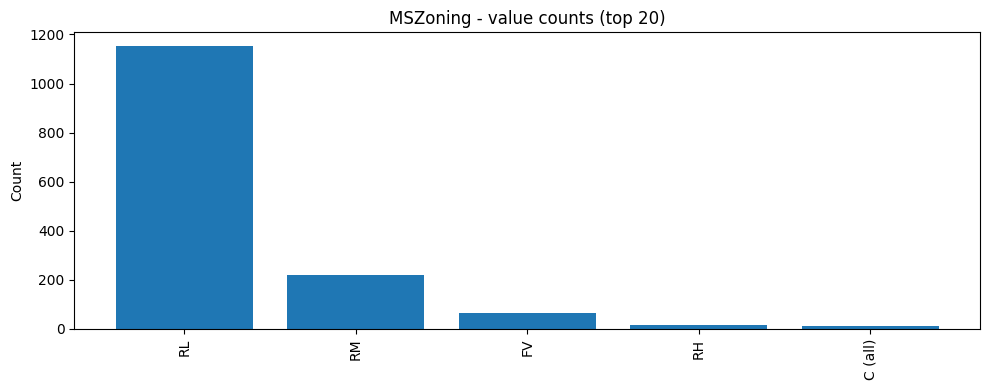

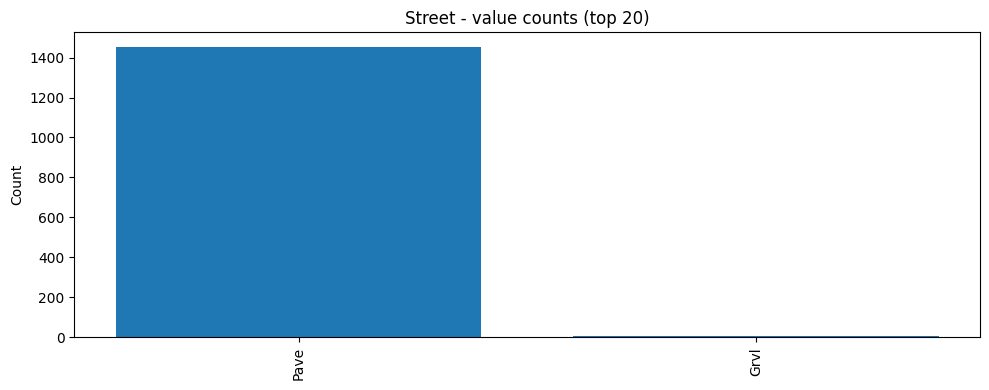

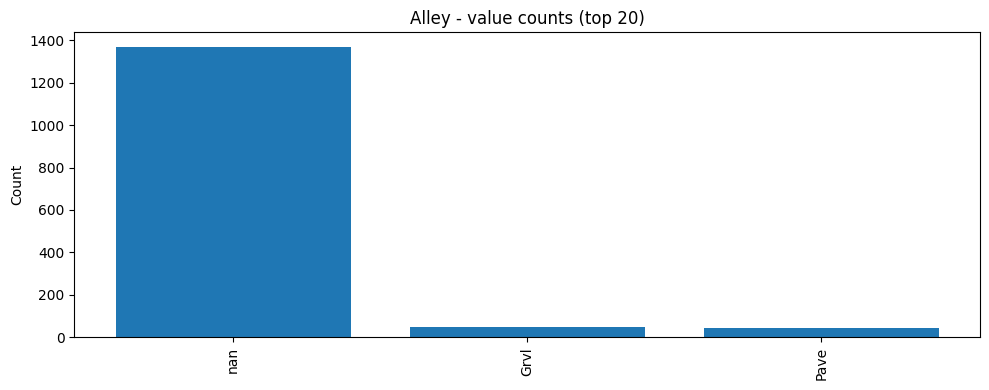

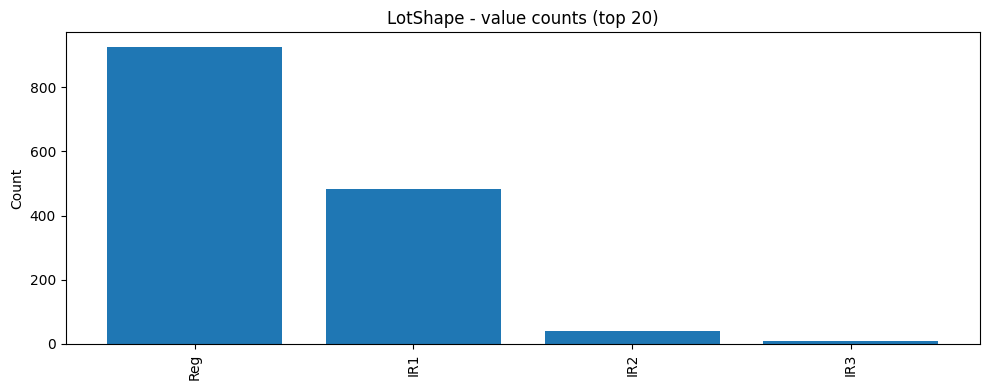

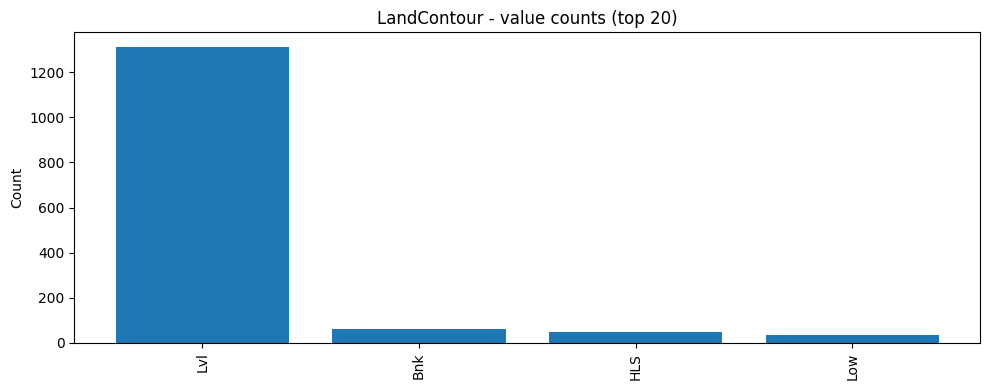

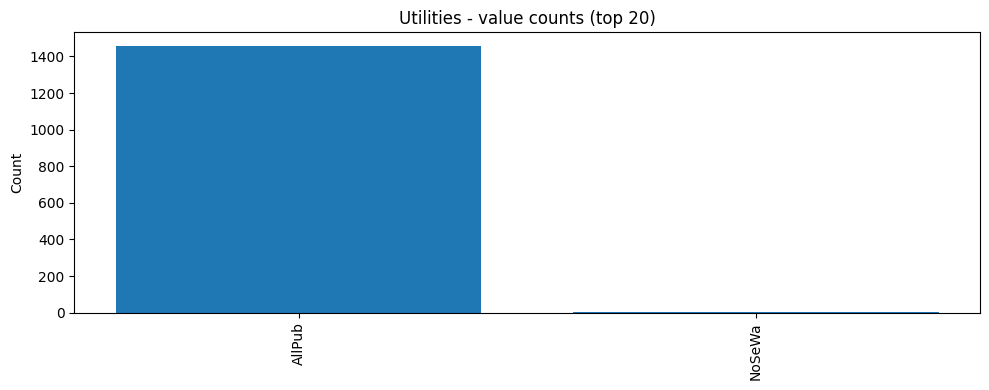

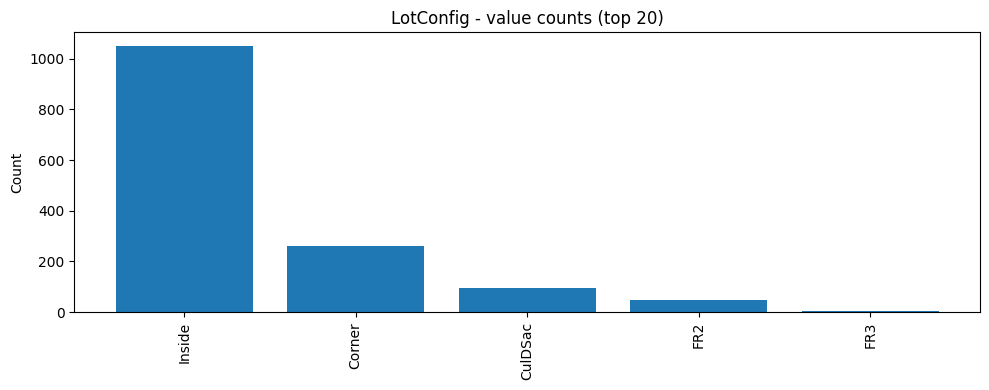

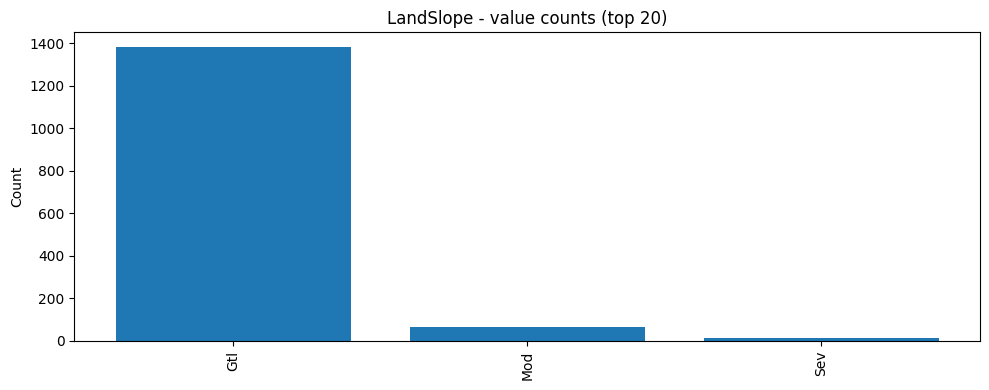

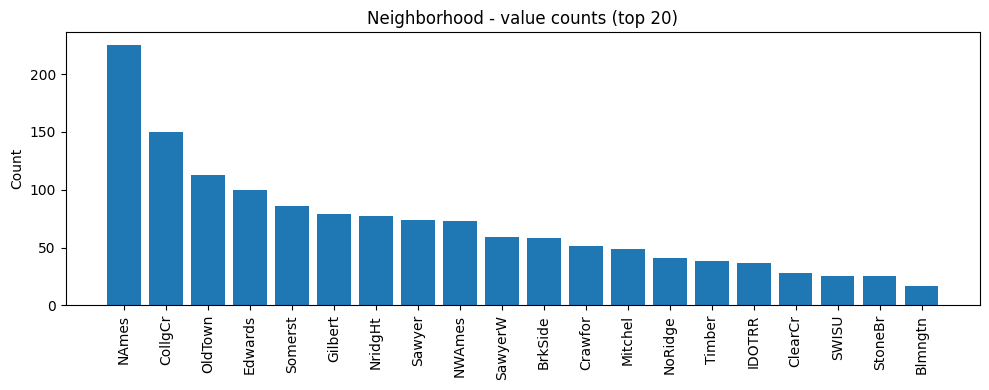

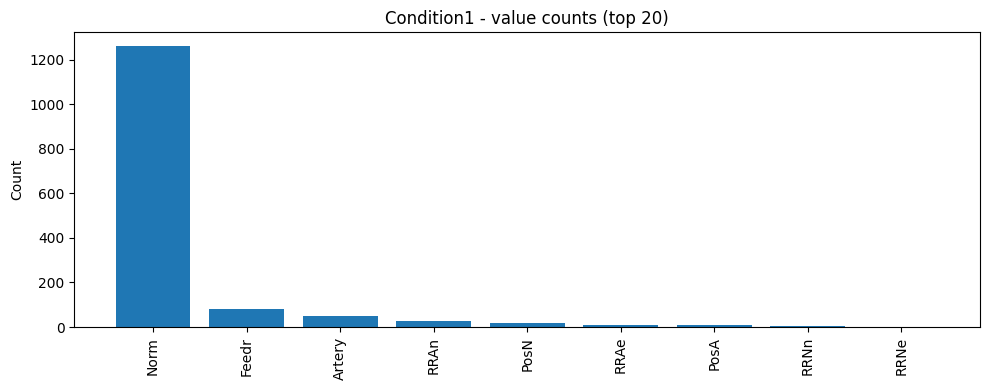

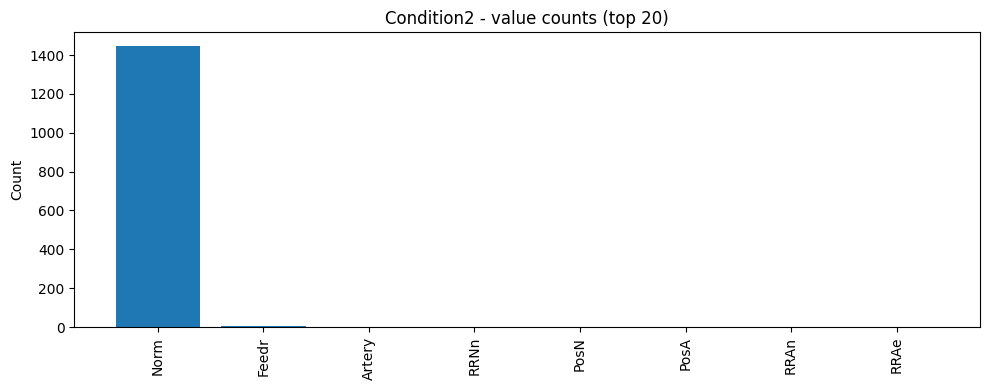

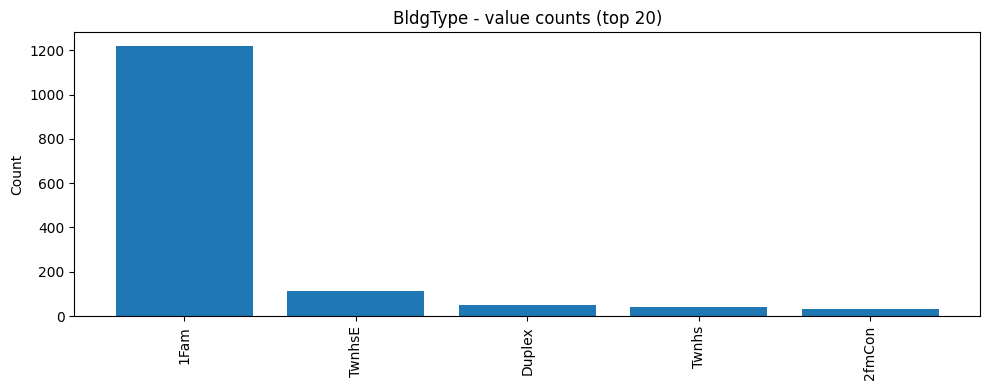

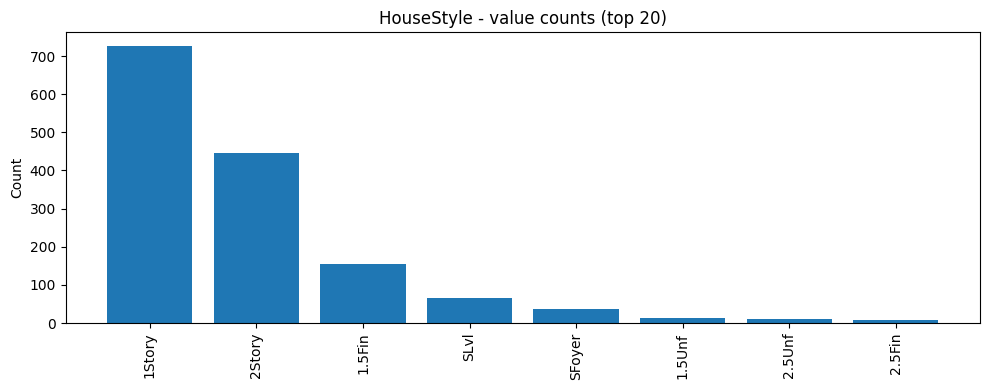

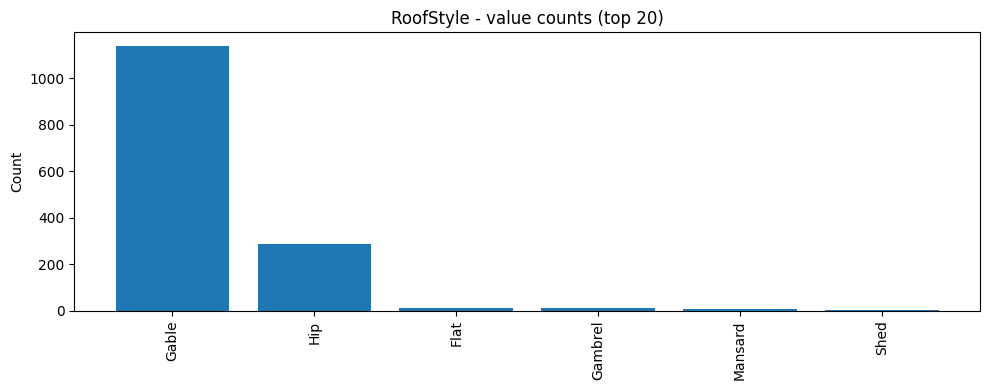

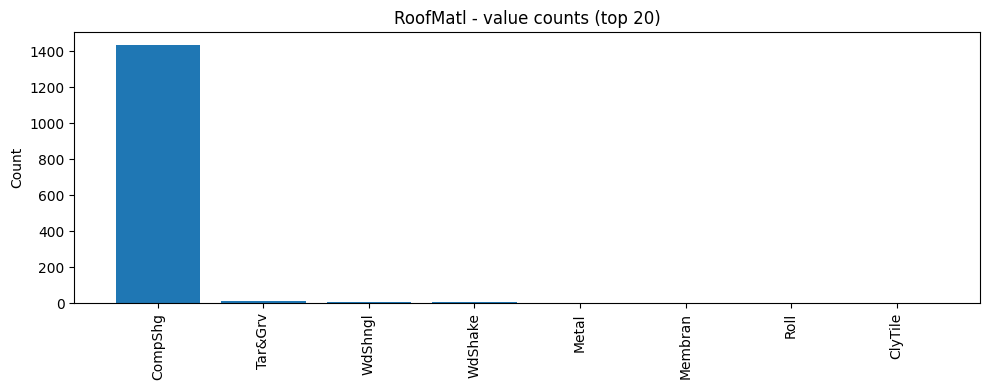

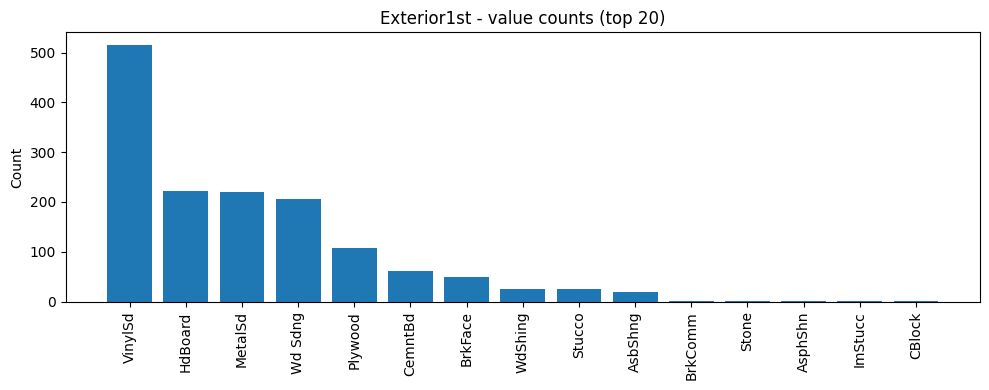

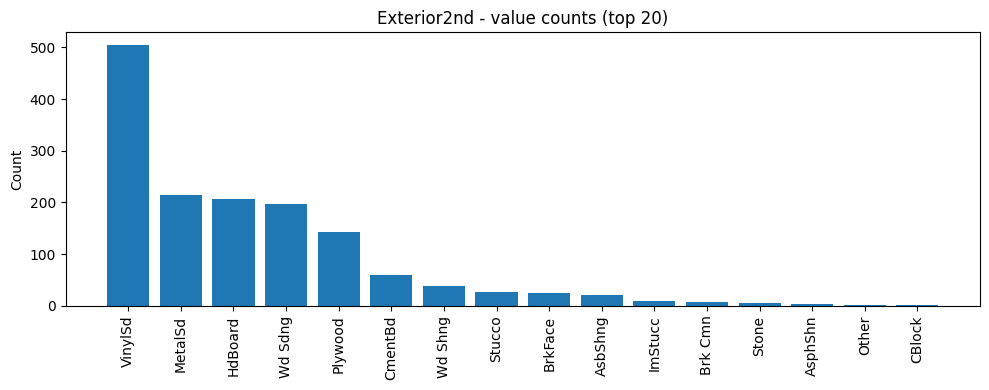

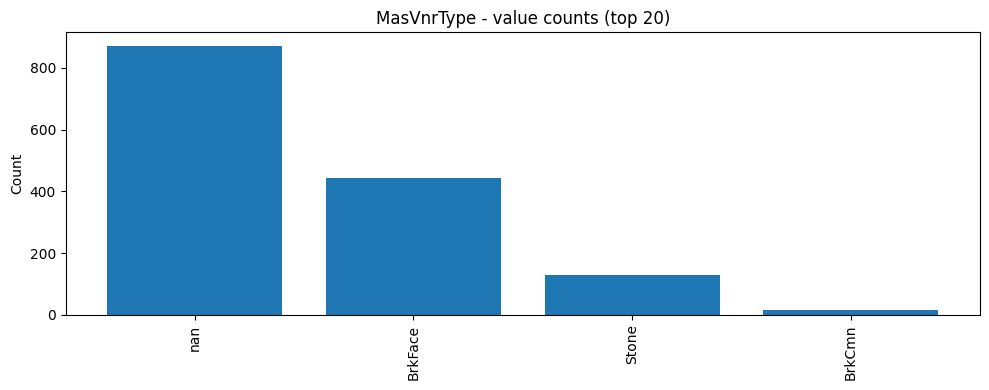

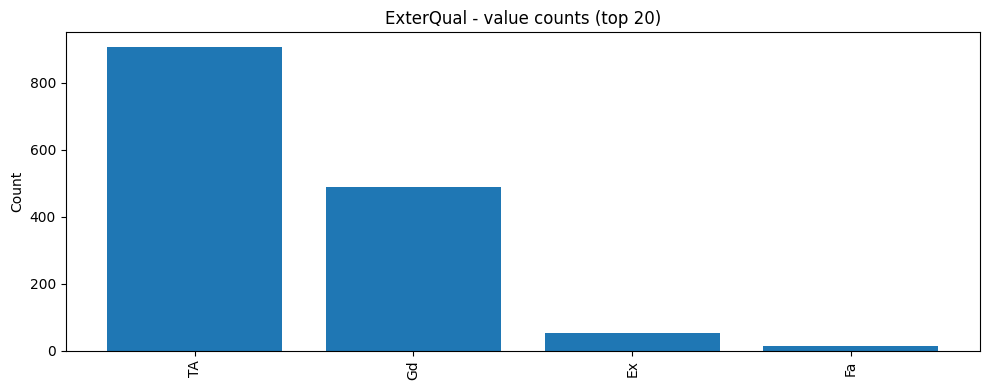

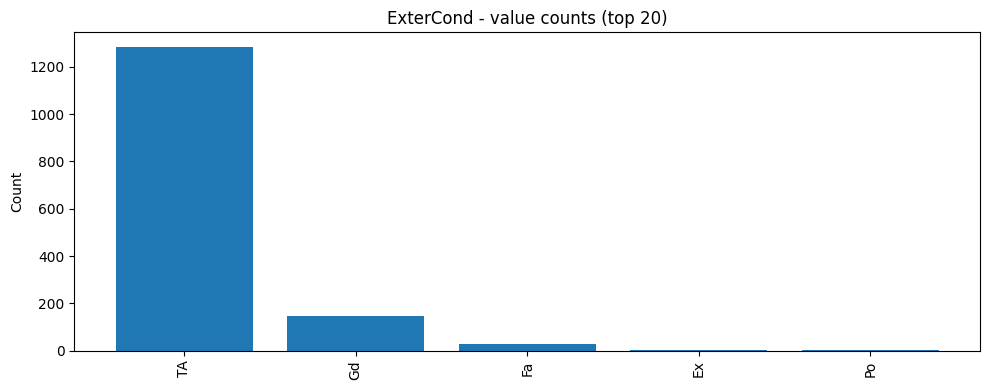

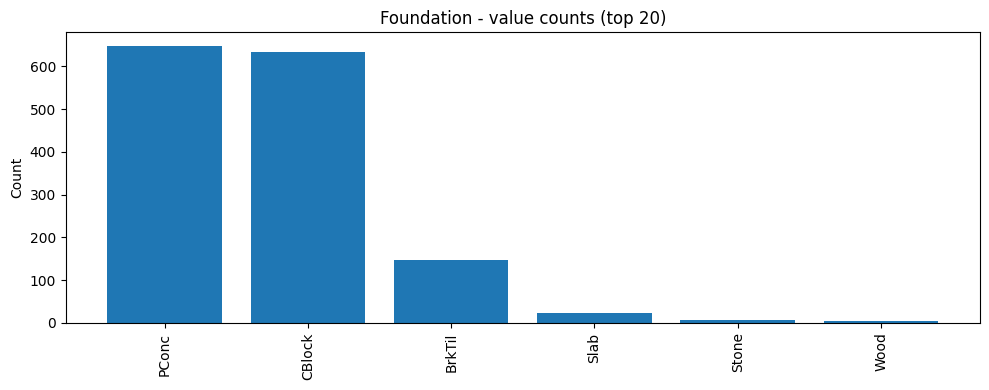

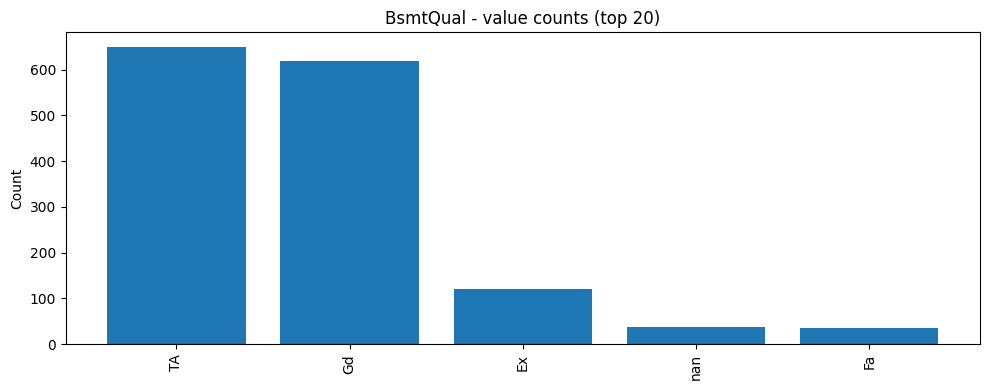

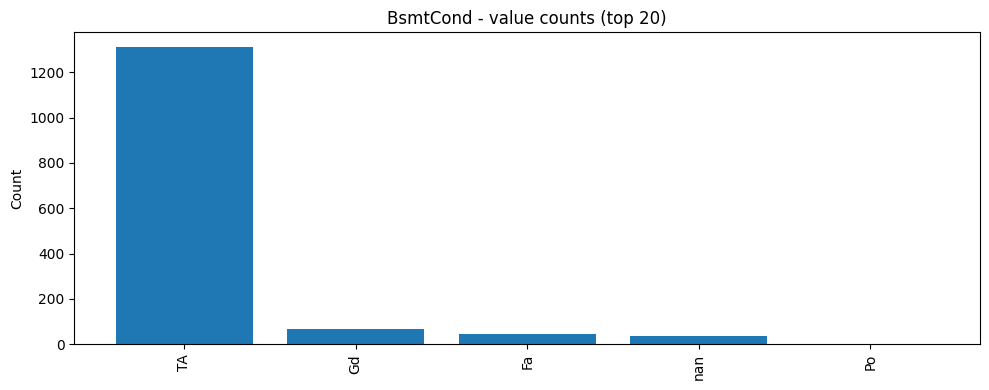

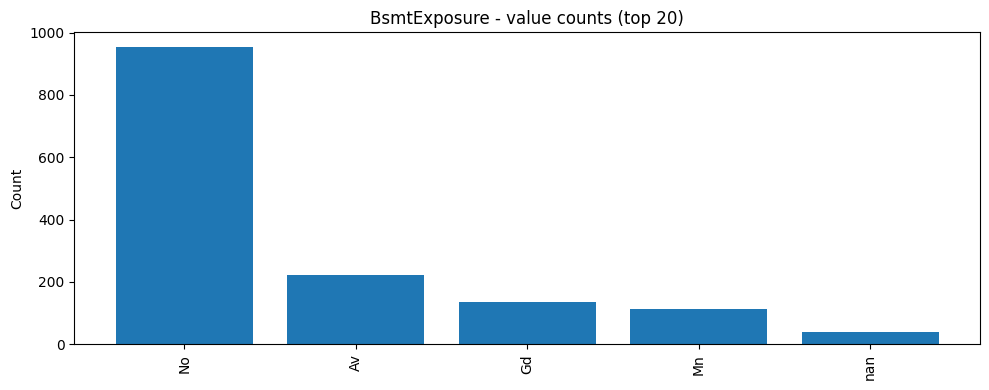

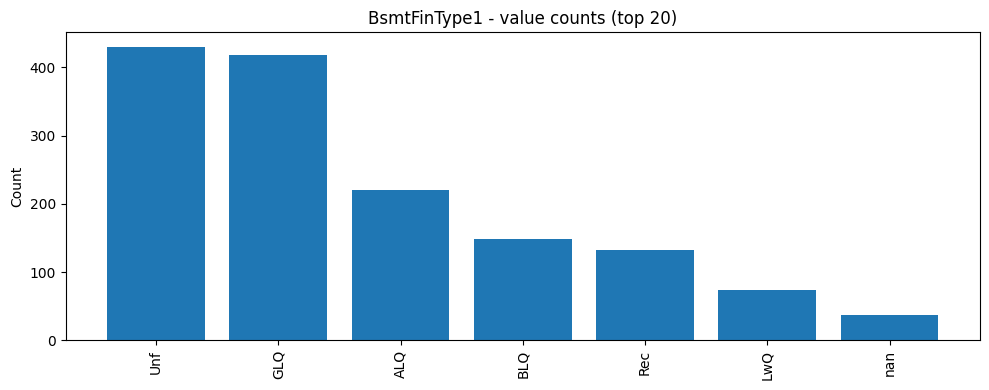

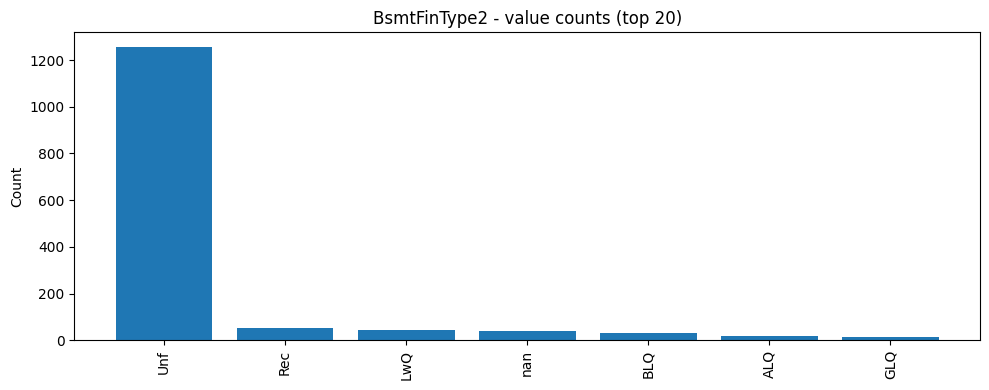

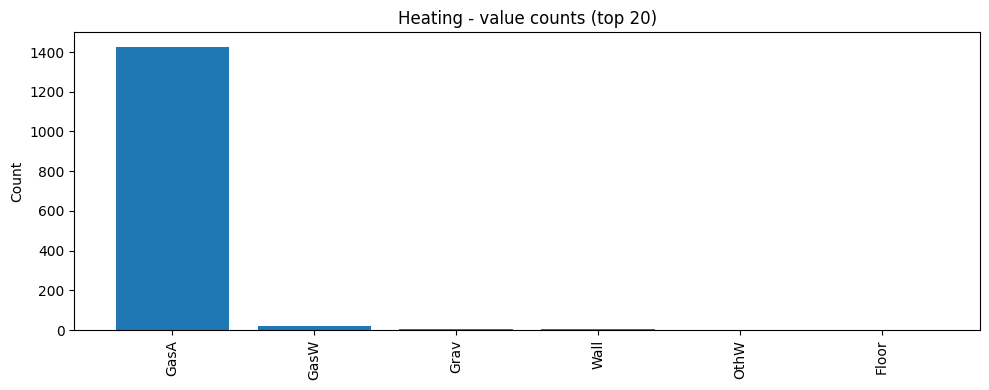

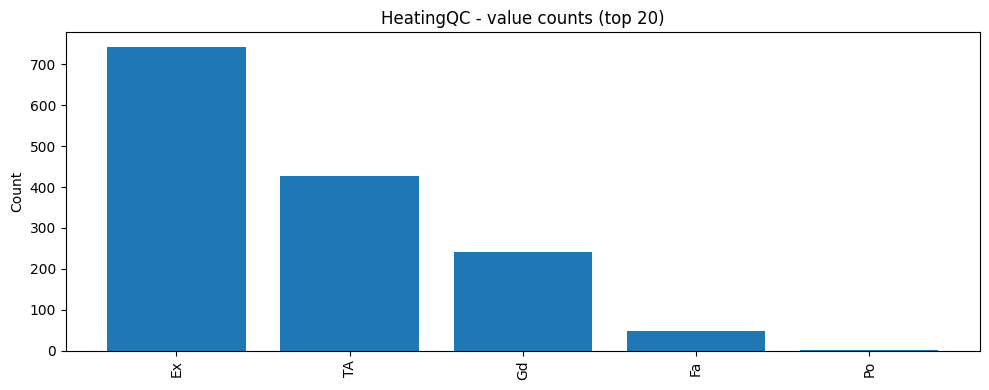

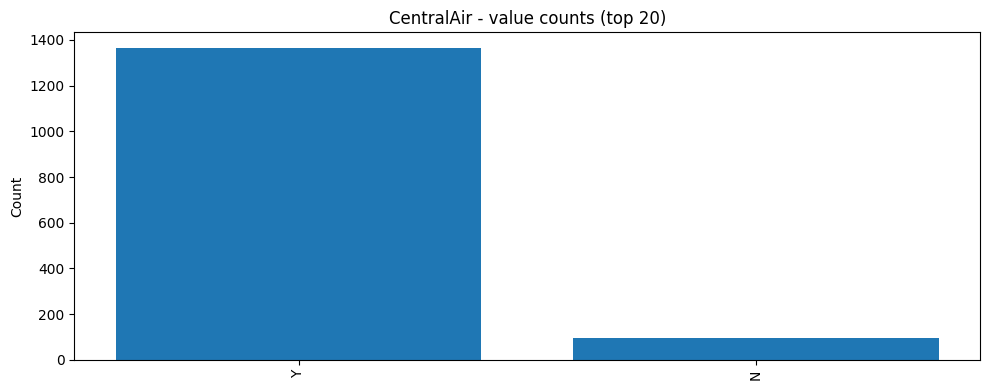

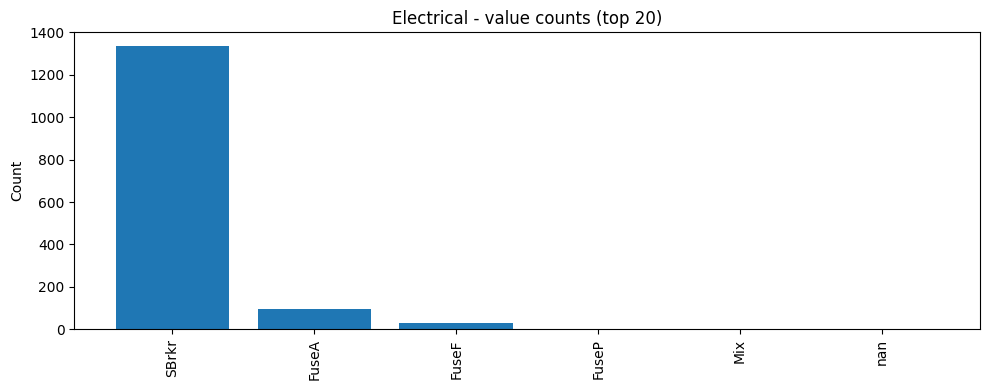

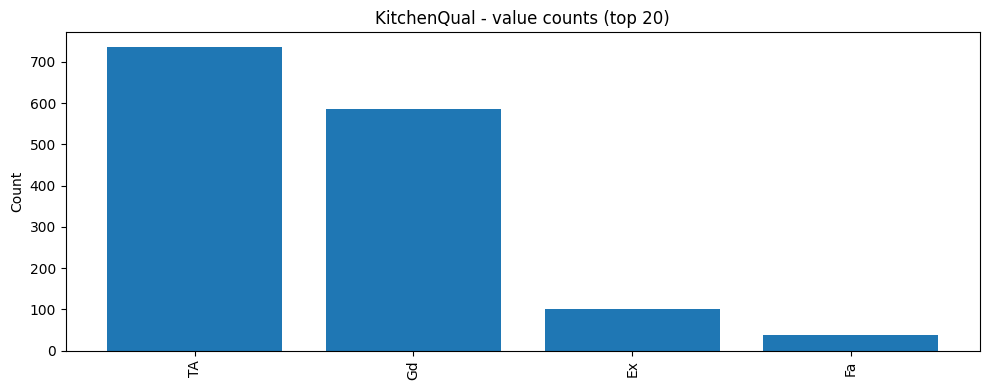

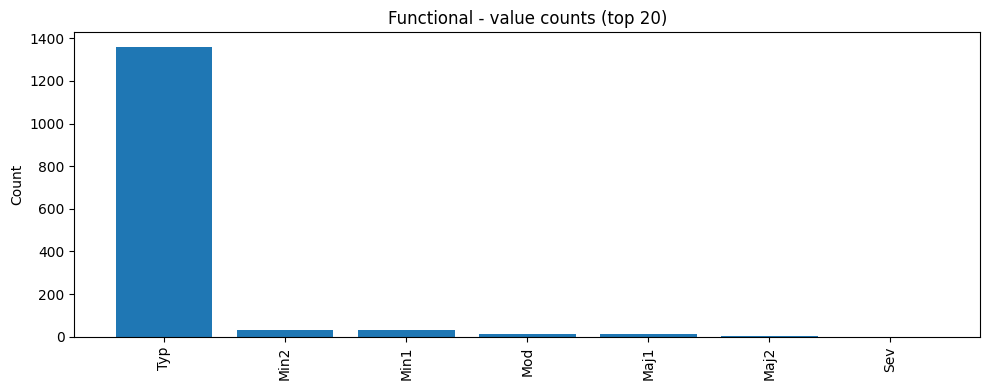

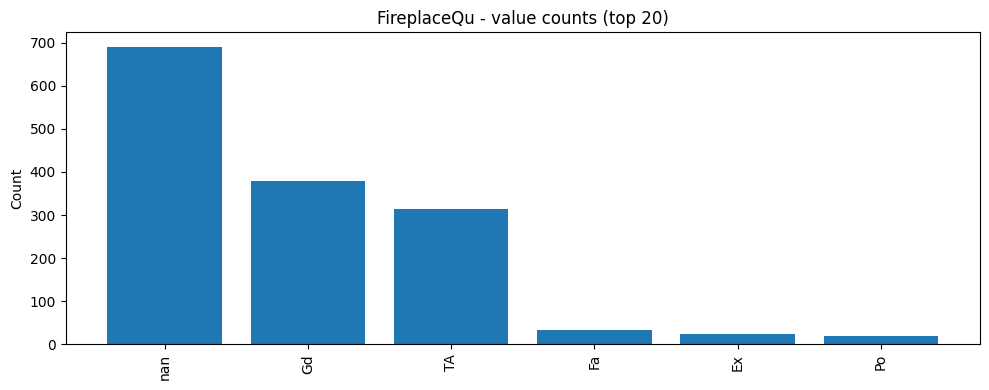

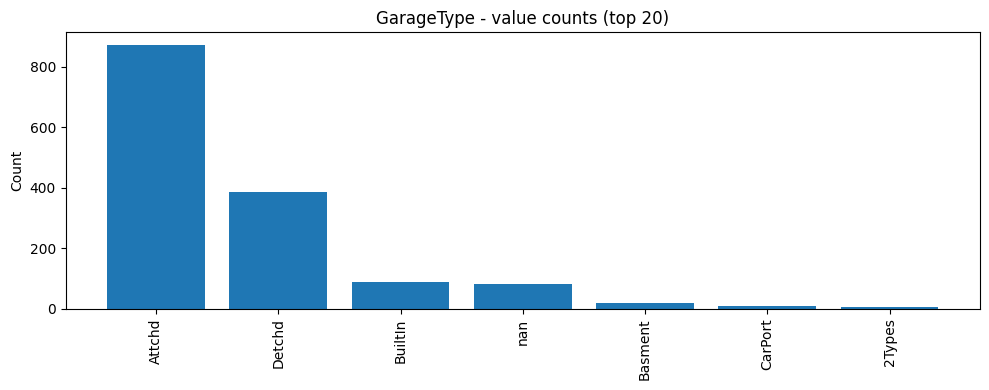

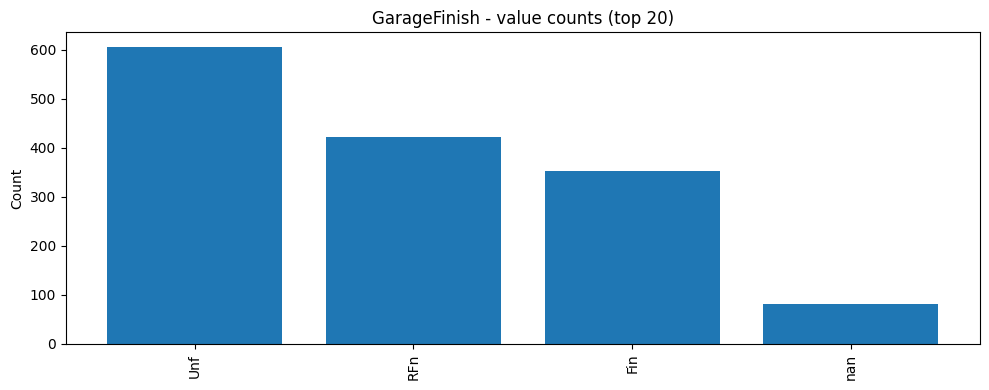

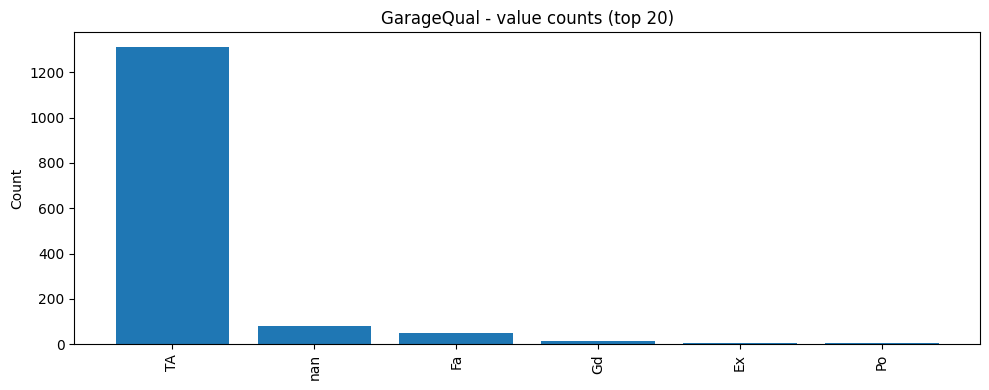

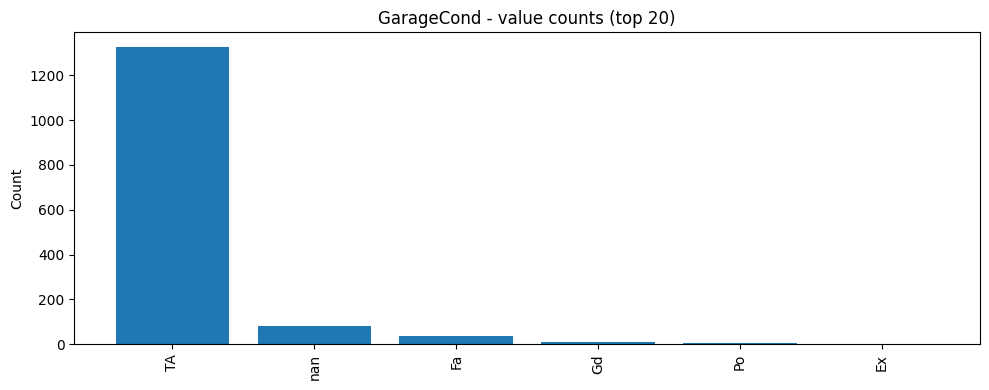

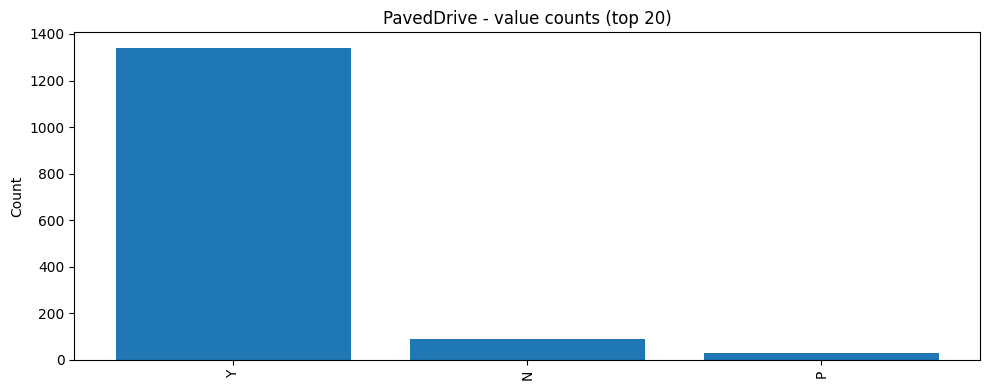

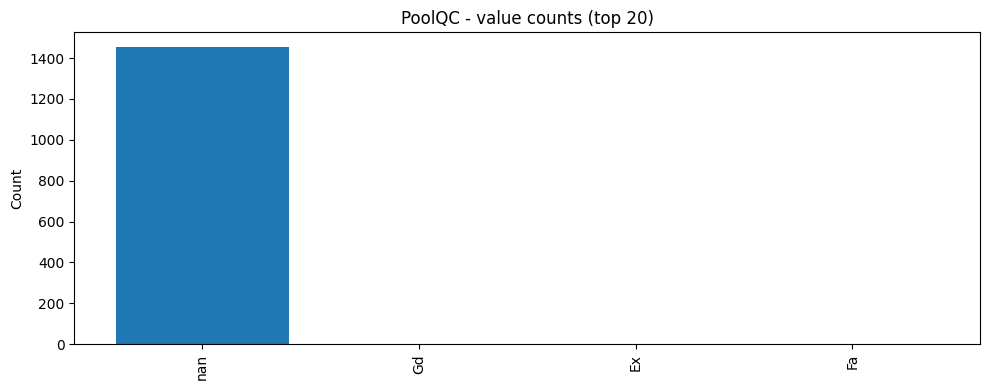

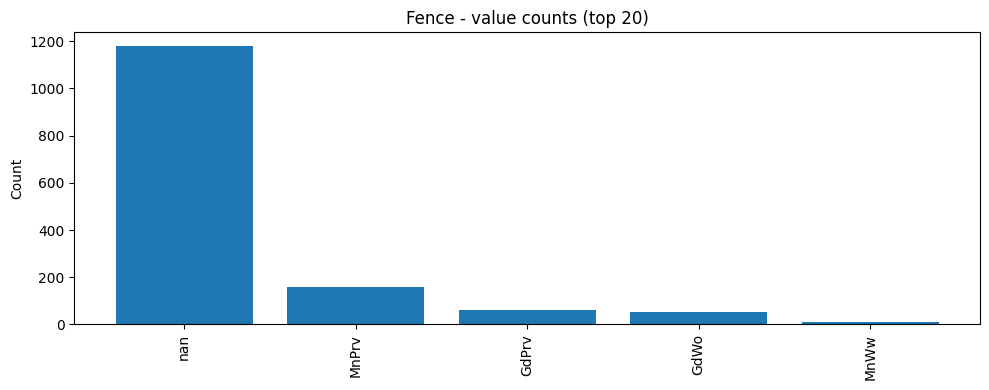

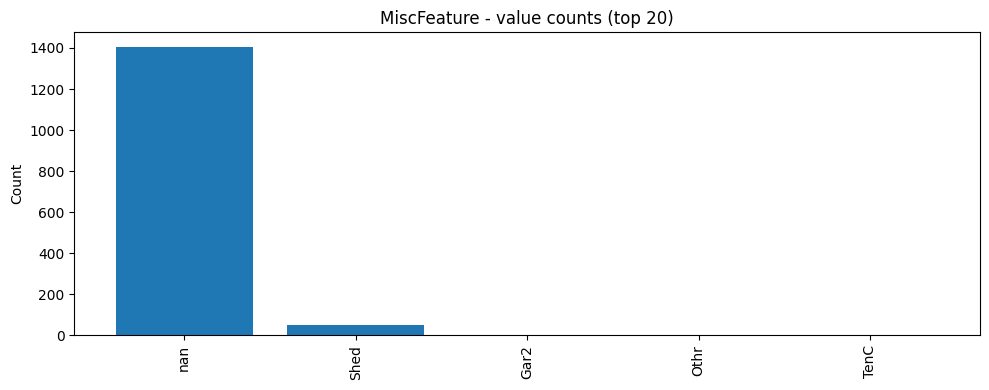

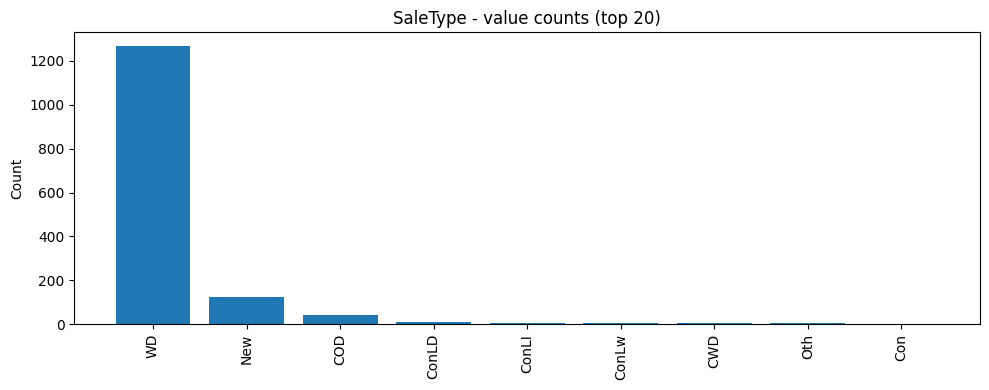

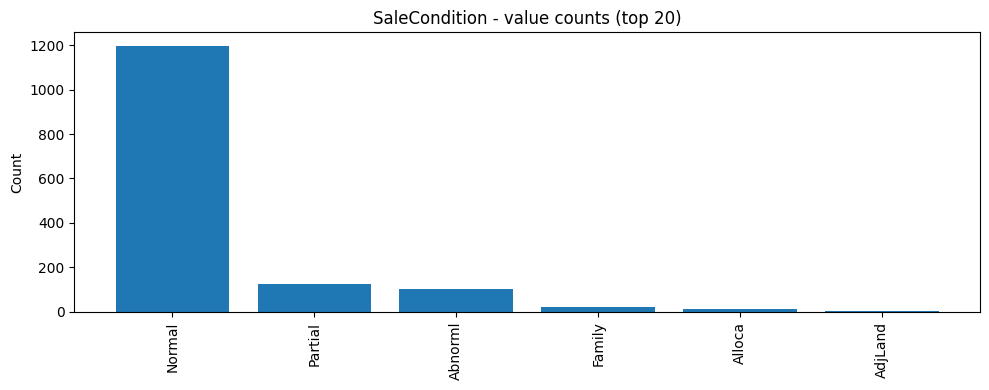

In [22]:
categorical_to_plot = cat_cols if categorical_plot_limit is None else cat_cols[:categorical_plot_limit]
for col in categorical_to_plot:
    counts = df[col].value_counts(dropna=False)
    top_n = counts.head(20)  # show top categories for readability

    plt.figure(figsize=(10,4))
    plt.bar(range(len(top_n)), top_n.values)
    plt.xticks(range(len(top_n)), [str(x) for x in top_n.index], rotation=90)
    plt.title(f"{col} - value counts (top 20)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

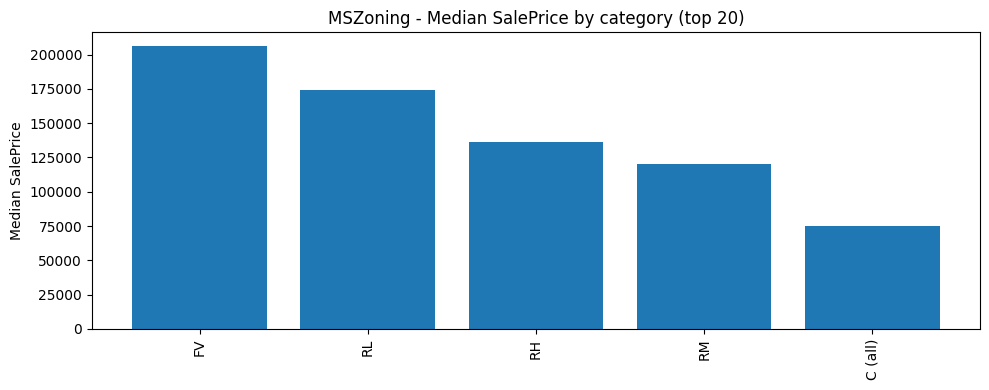

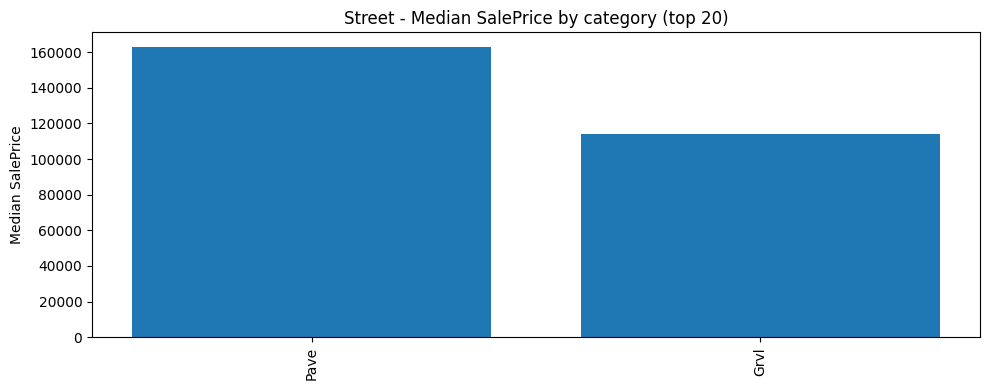

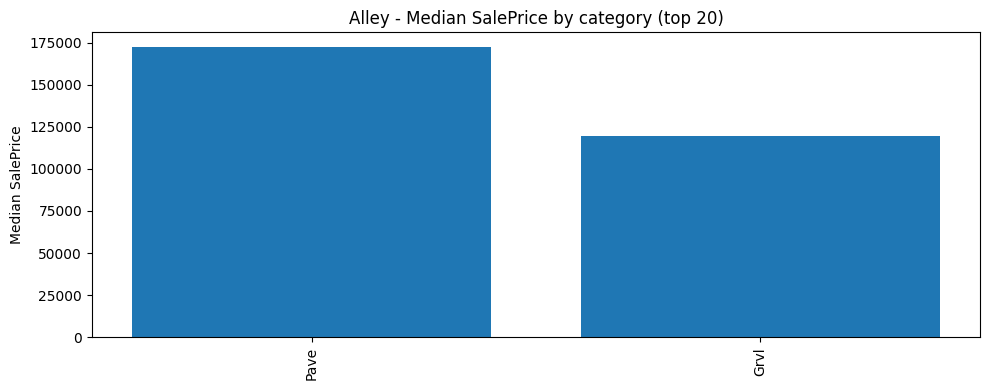

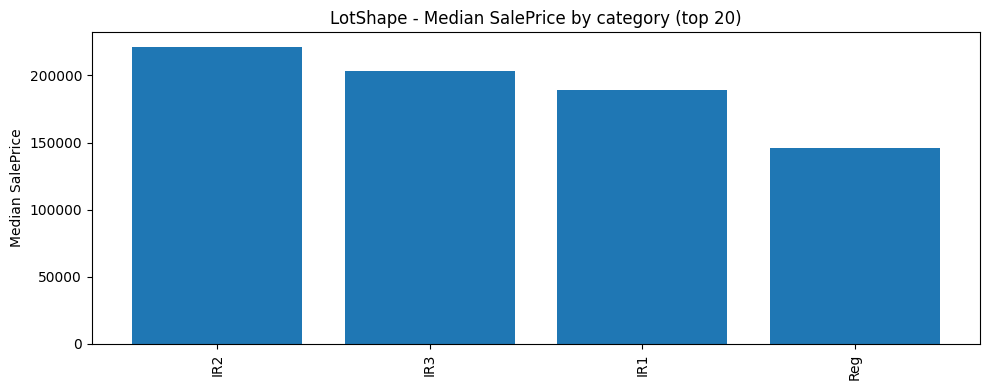

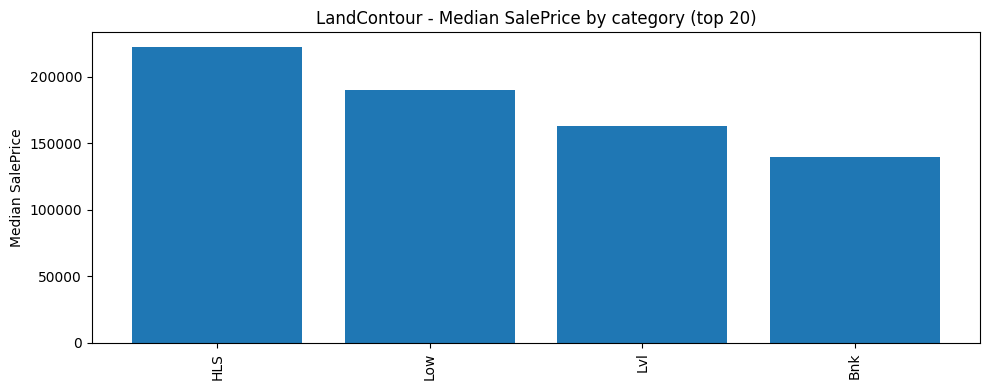

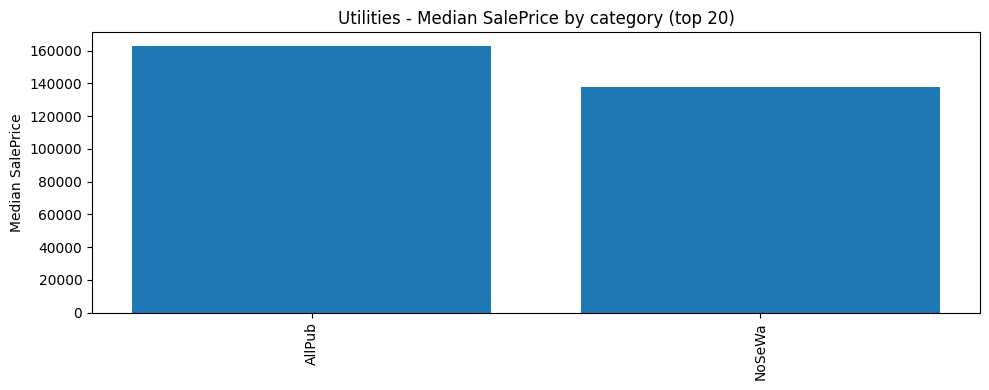

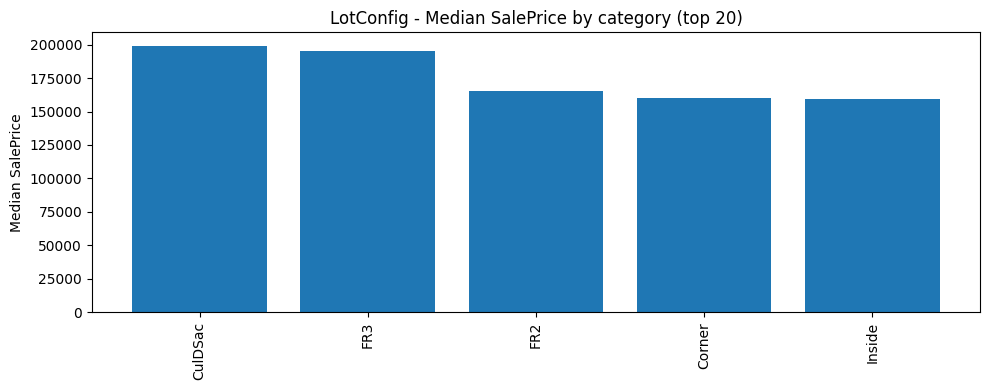

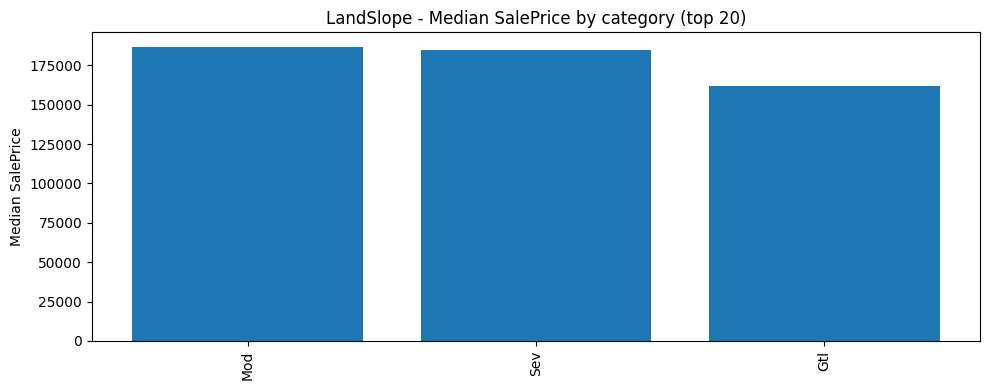

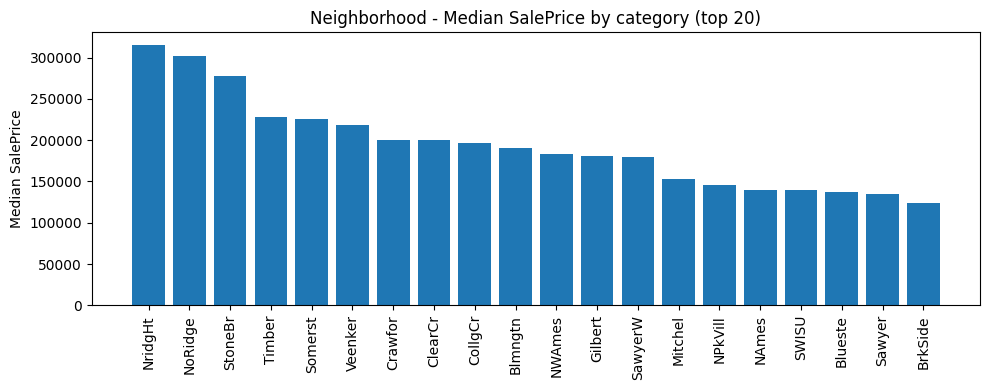

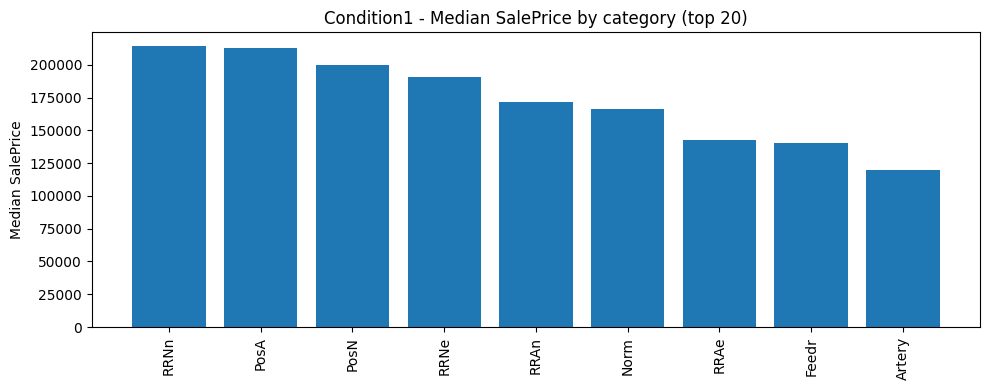

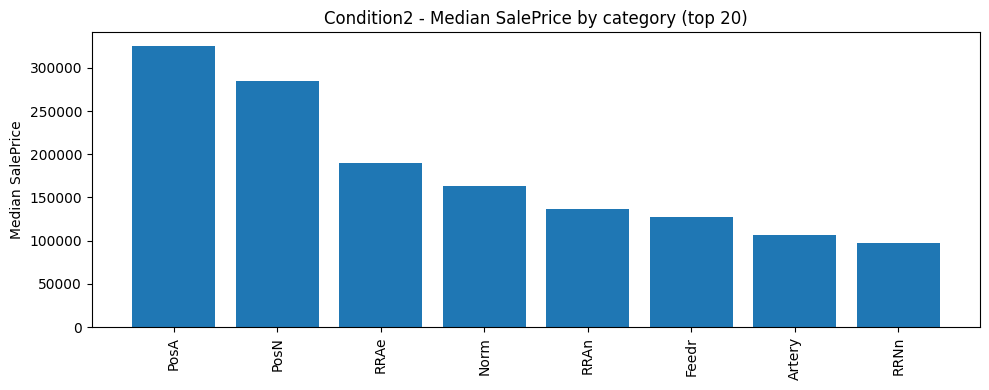

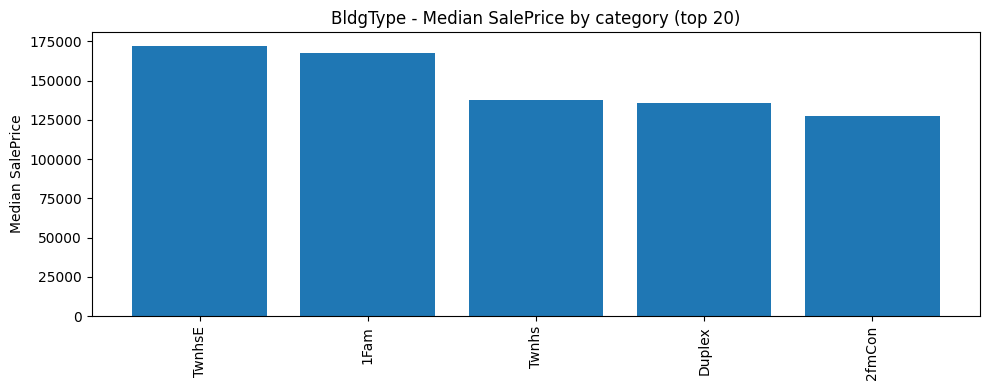

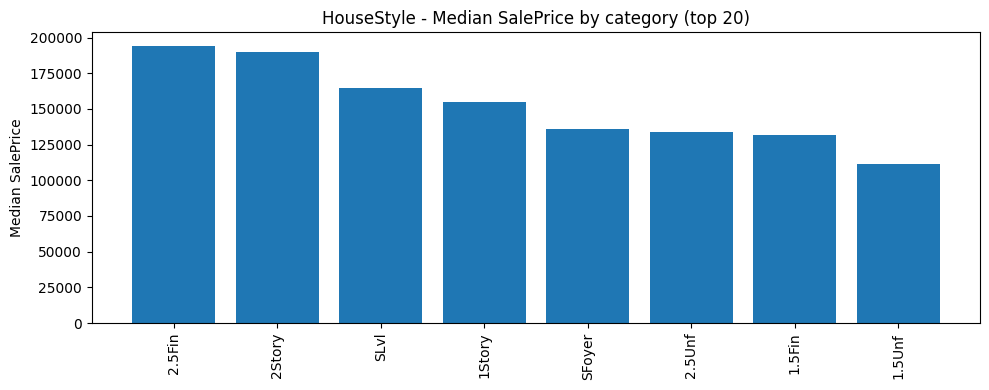

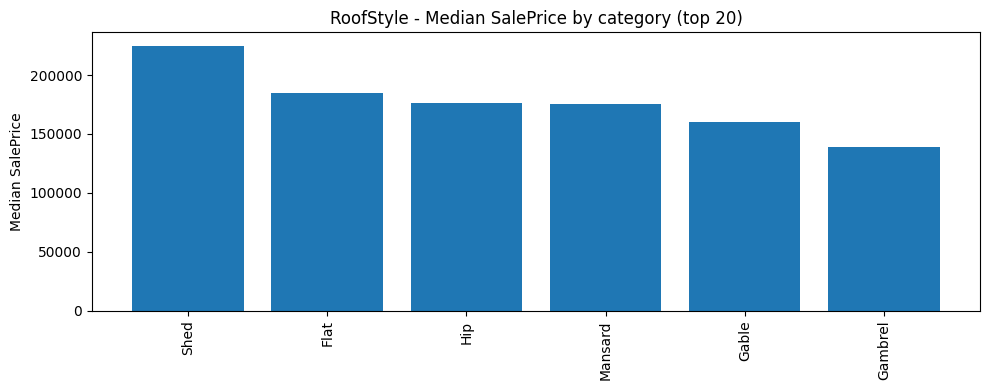

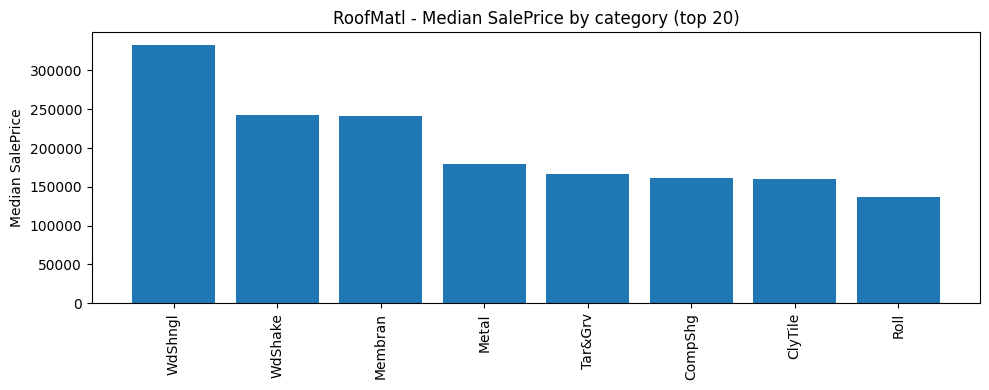

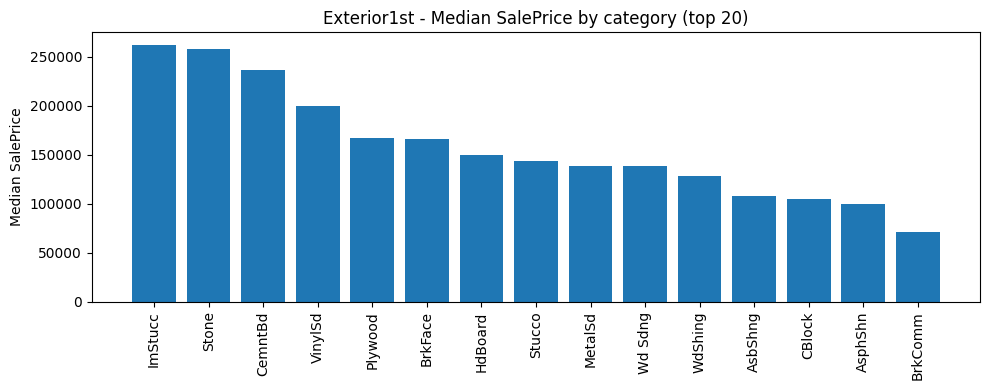

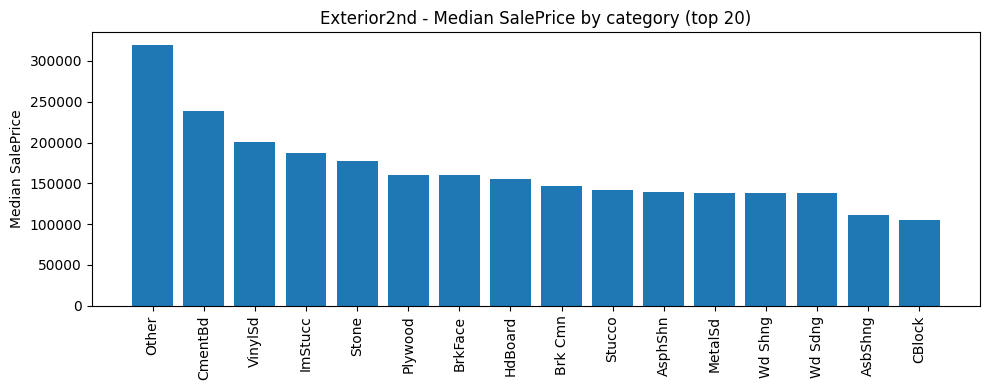

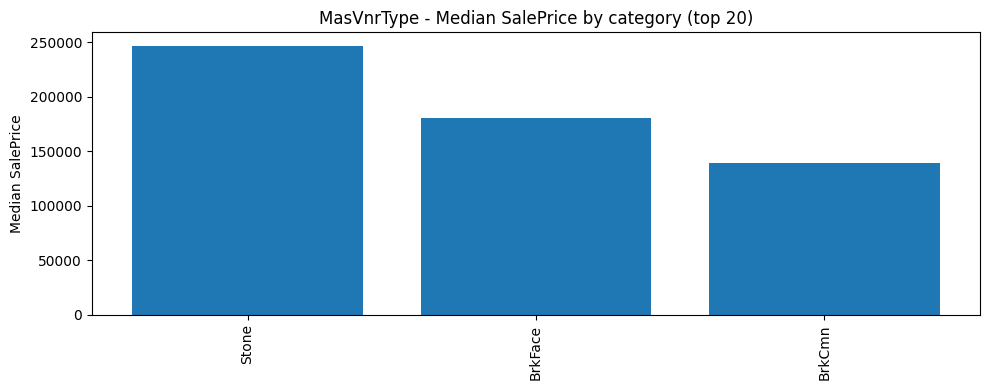

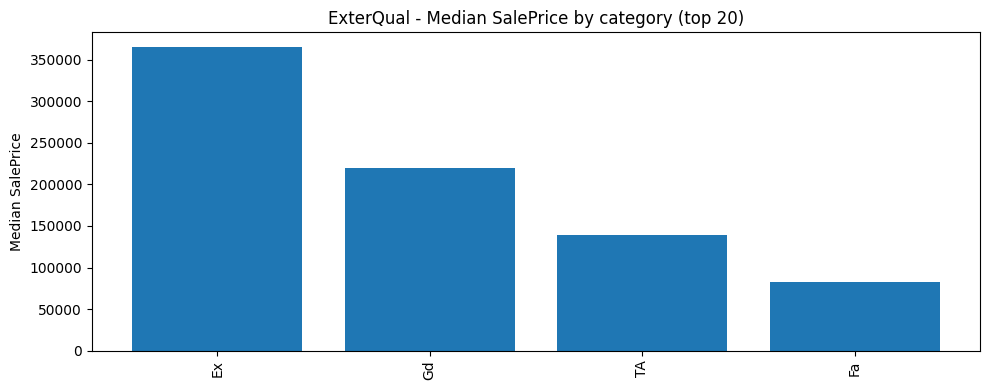

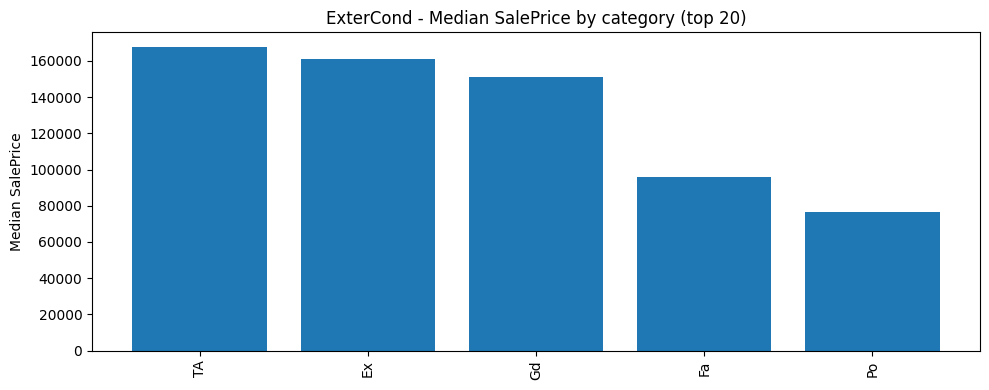

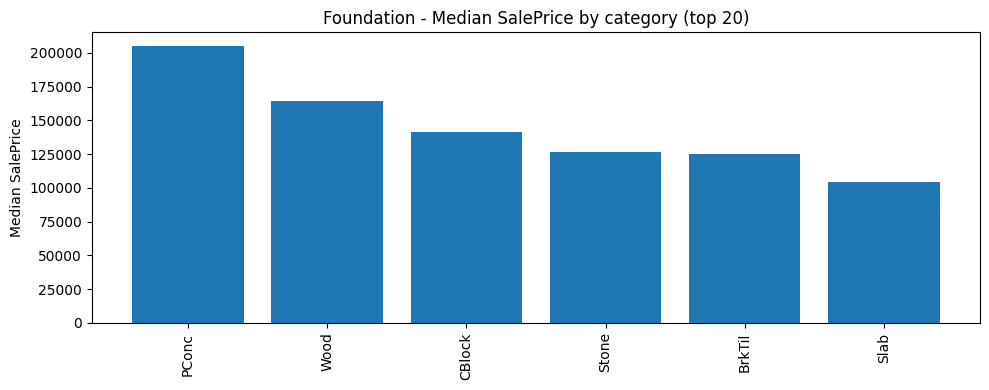

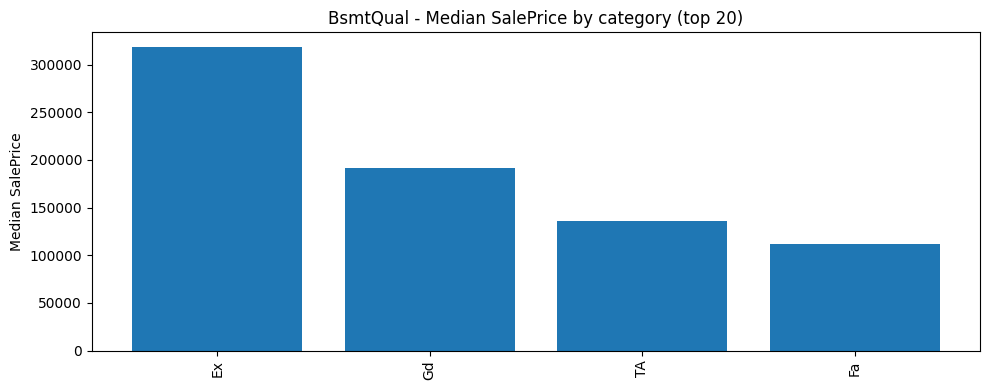

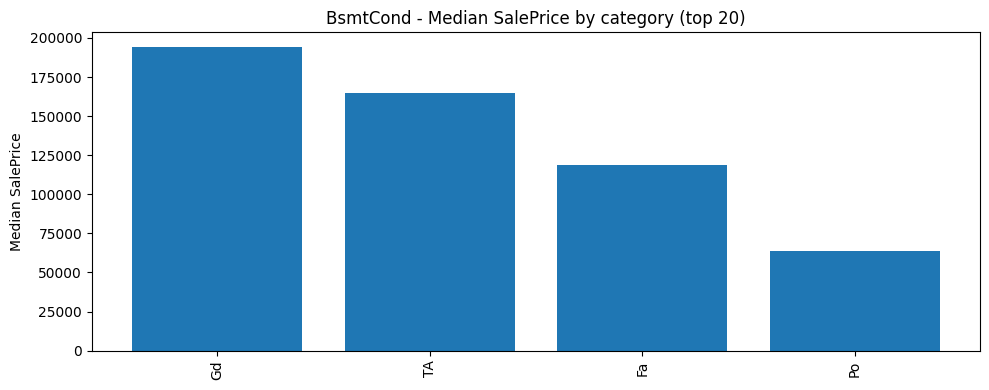

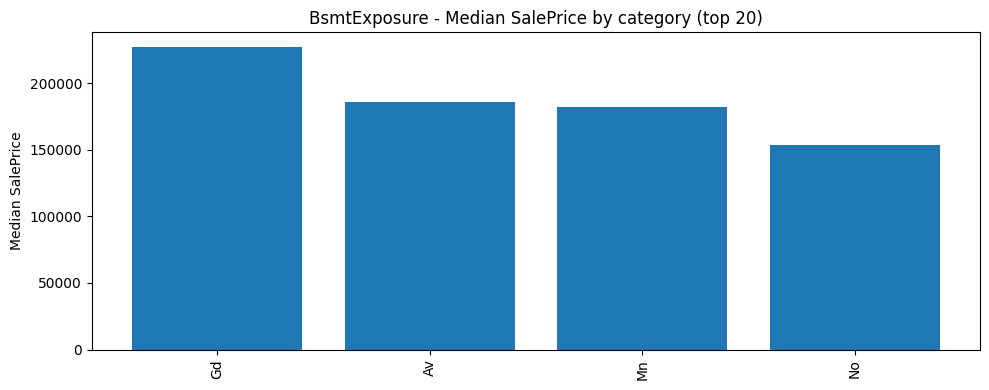

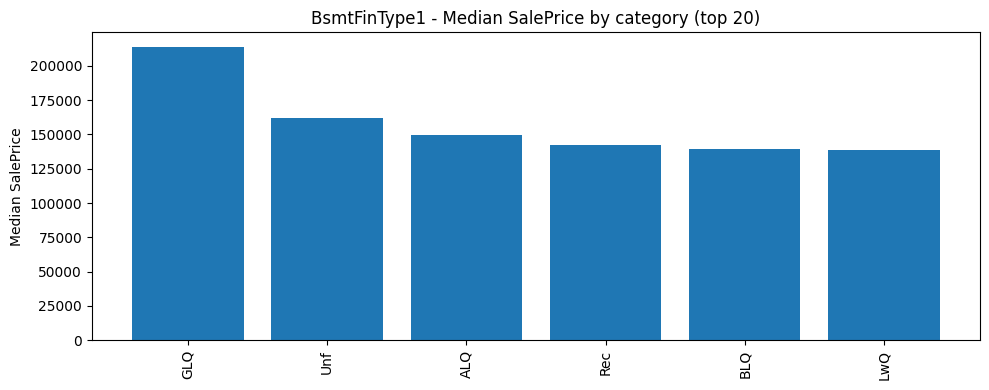

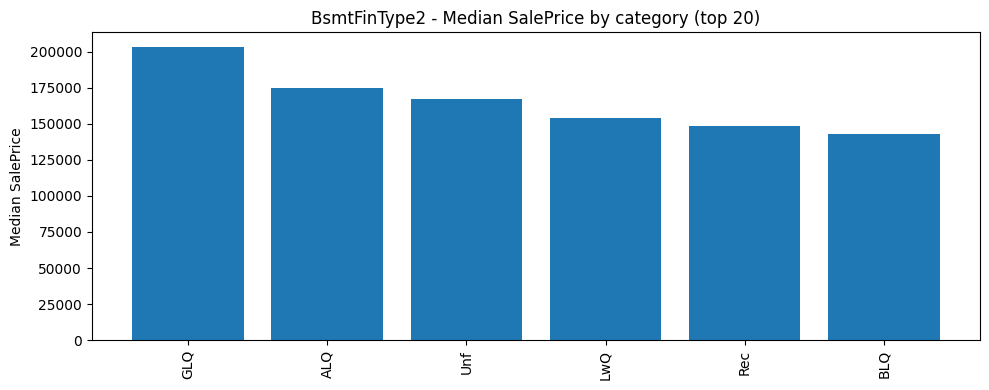

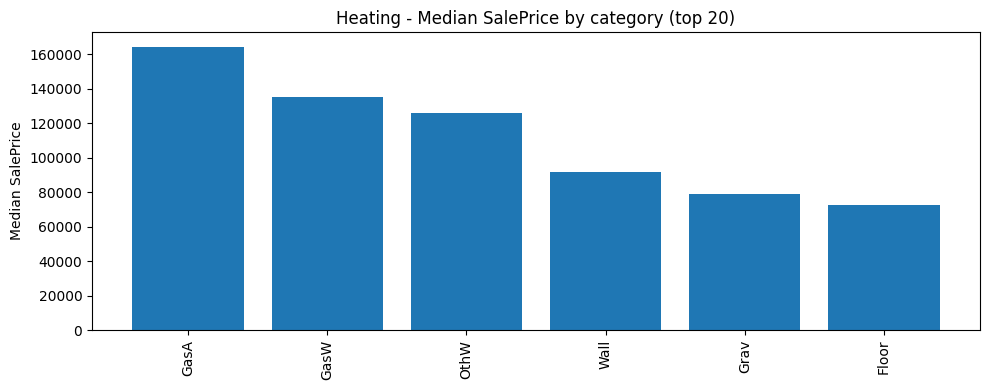

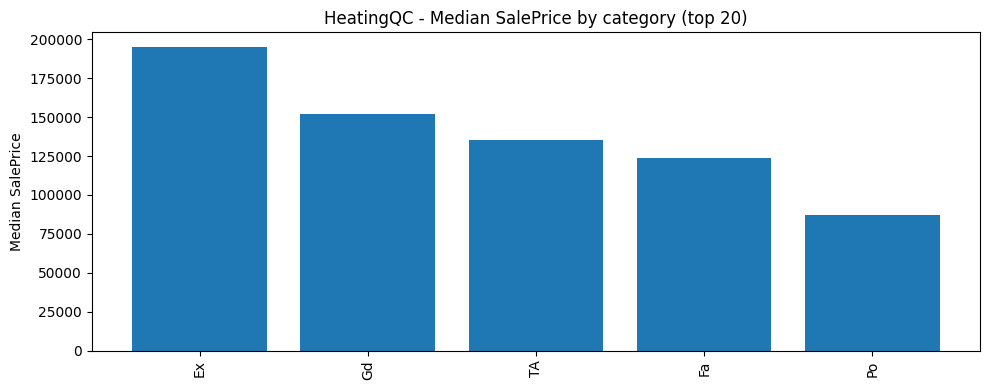

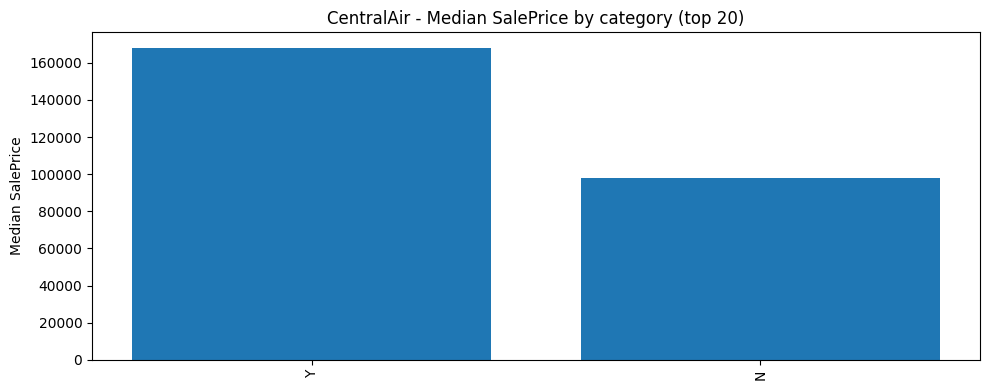

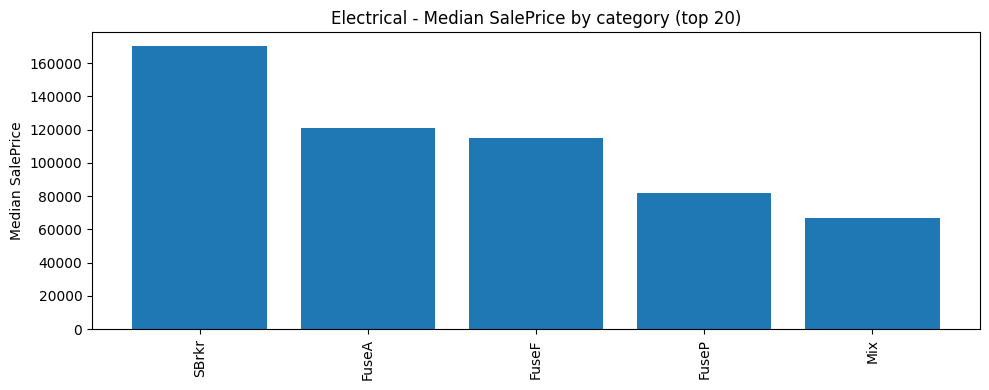

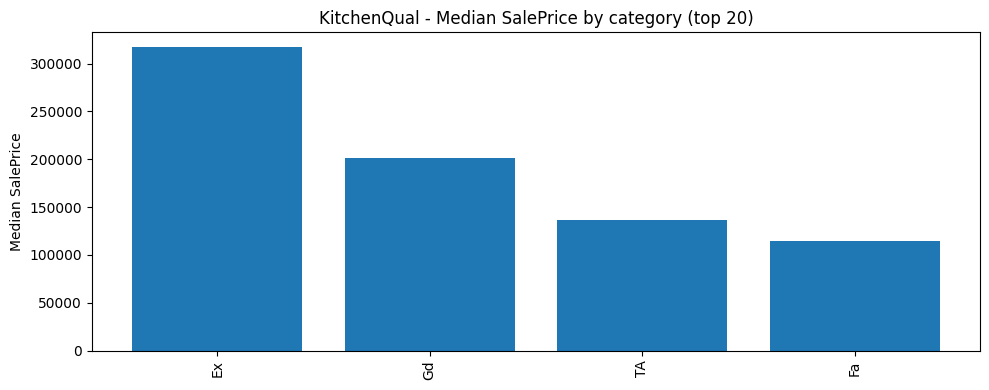

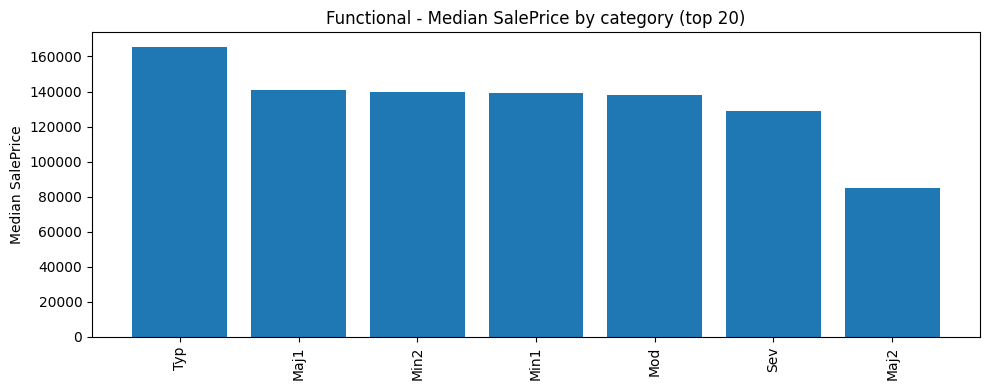

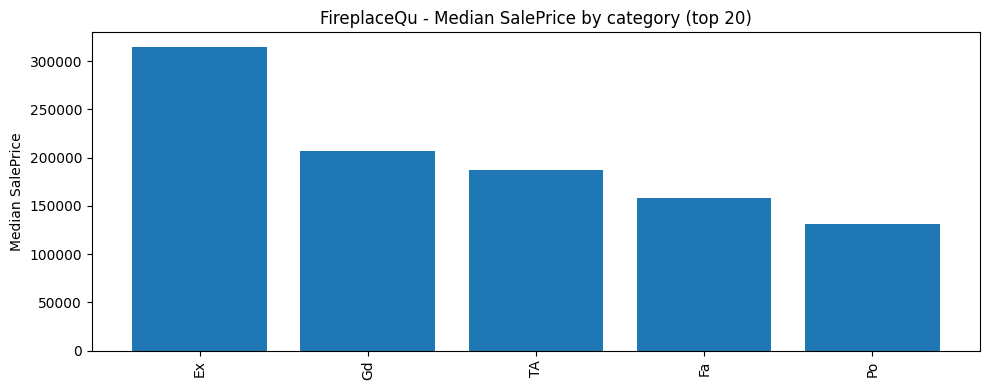

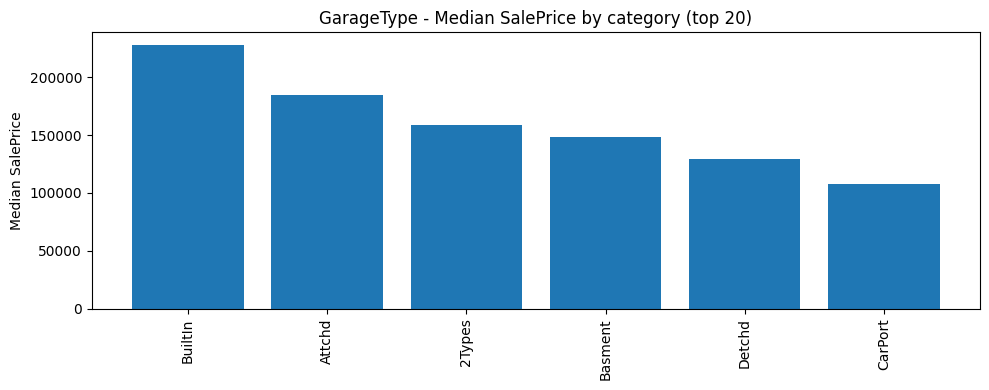

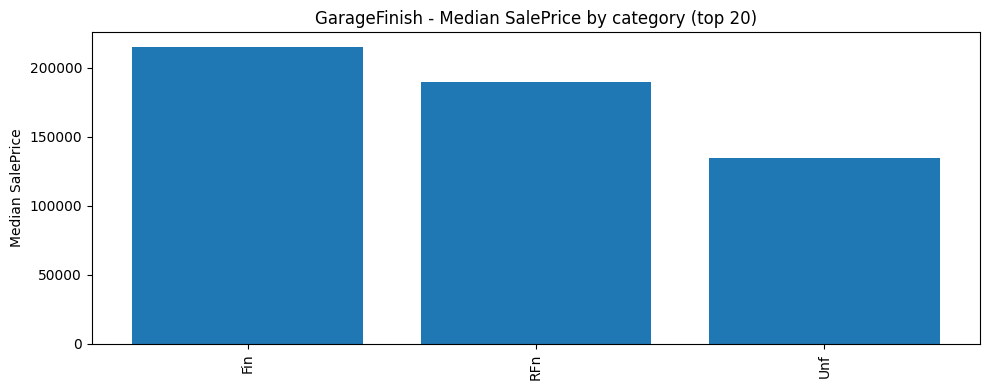

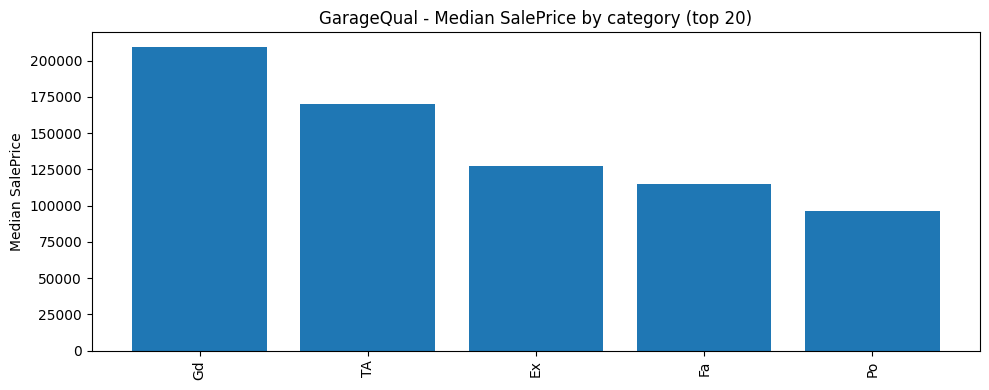

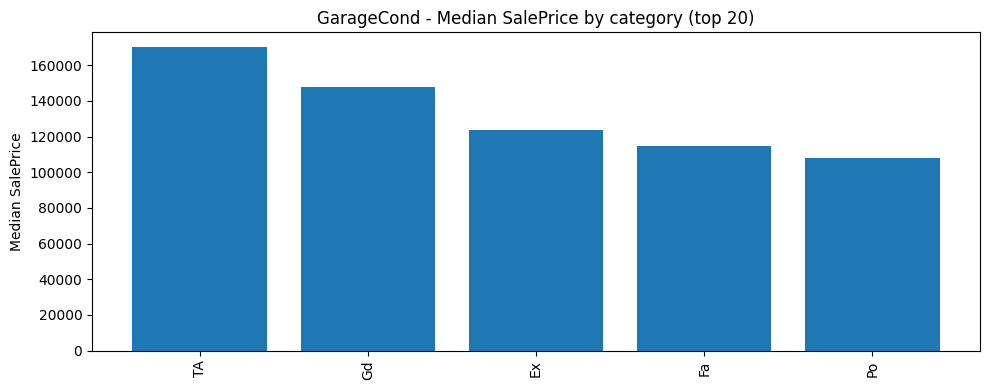

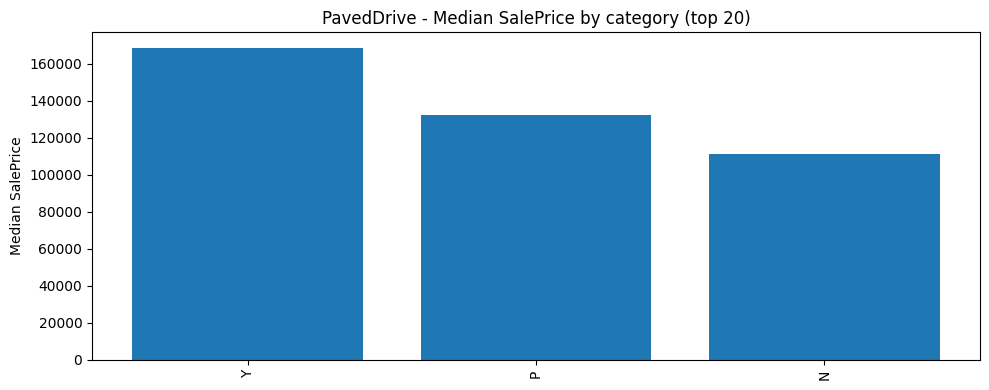

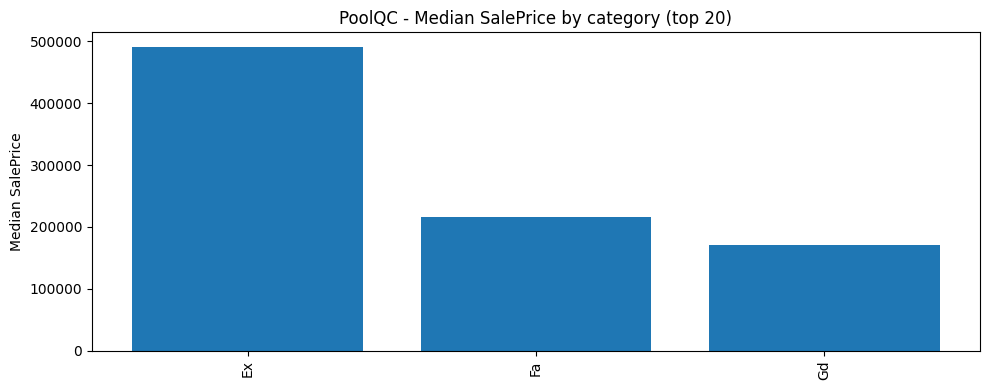

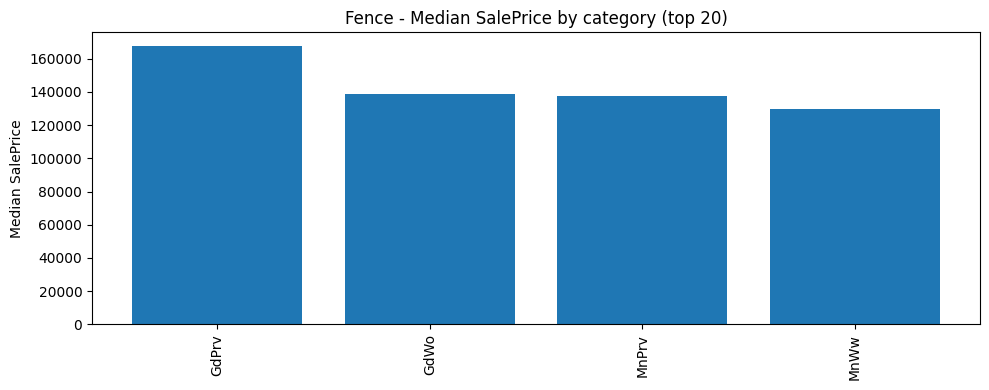

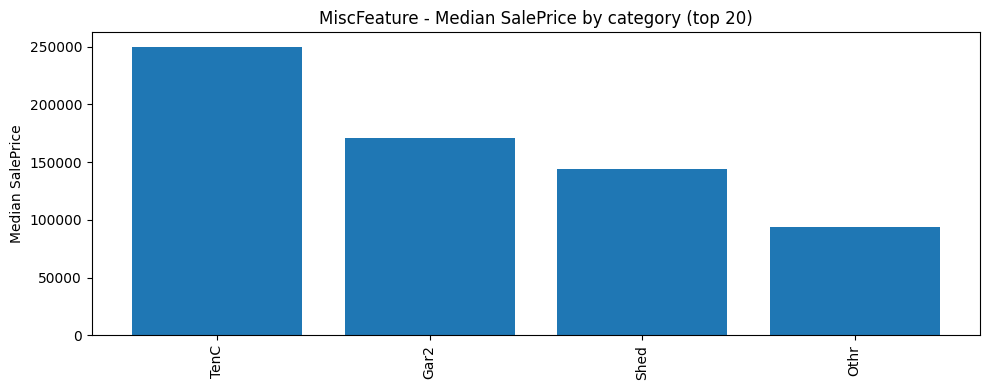

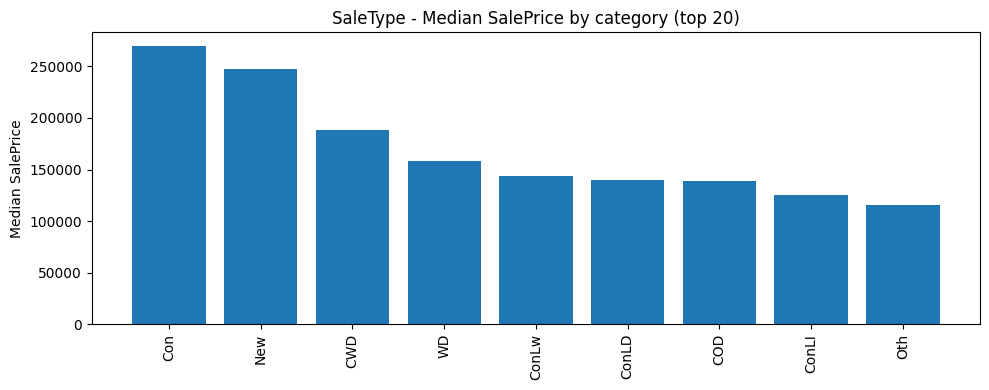

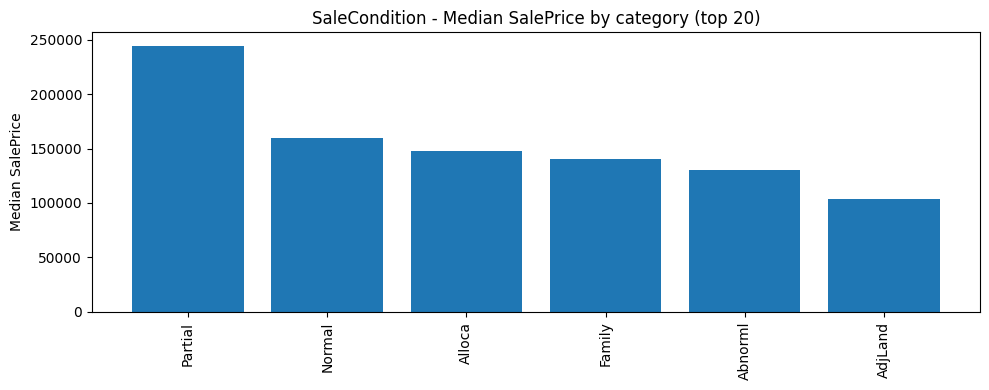

In [23]:
for col in categorical_to_plot:
    counts = df[col].value_counts(dropna=False)
    top_n = counts.head(20)  # show top categories for readability
    # Median target by category for top categories
    grouped = df.groupby(col)[TARGET].median().dropna().sort_values(ascending=False).head(20)
    plt.figure(figsize=(10,4))
    plt.bar(range(len(grouped)), grouped.values)
    plt.xticks(range(len(grouped)), [str(x) for x in grouped.index], rotation=90)
    plt.title(f"{col} - Median {TARGET} by category (top 20)")
    plt.ylabel(f"Median {TARGET}")
    plt.tight_layout()
    plt.show()

In [24]:
for col in categorical_to_plot:
    counts = df[col].value_counts(dropna=False)
    top_n = counts.head(20)

    nunique = df[col].nunique(dropna=True)
    missing = df[col].isnull().sum()
    print(f"Categorical: {col} | Unique: {nunique} | Missing: {missing}")
    if nunique > 30:
        print("  -> High-cardinality categorical. Consider grouping rare categories into 'Other' or frequency encoding.")
    print("  -> Compare counts with median target to spot categories associated with much higher or lower target values.")
    print("-" * 80)

Categorical: MSZoning | Unique: 5 | Missing: 0
  -> Compare counts with median target to spot categories associated with much higher or lower target values.
--------------------------------------------------------------------------------
Categorical: Street | Unique: 2 | Missing: 0
  -> Compare counts with median target to spot categories associated with much higher or lower target values.
--------------------------------------------------------------------------------
Categorical: Alley | Unique: 2 | Missing: 1369
  -> Compare counts with median target to spot categories associated with much higher or lower target values.
--------------------------------------------------------------------------------
Categorical: LotShape | Unique: 4 | Missing: 0
  -> Compare counts with median target to spot categories associated with much higher or lower target values.
--------------------------------------------------------------------------------
Categorical: LandContour | Unique: 4 | Missing: 0


---
### Missingness overview

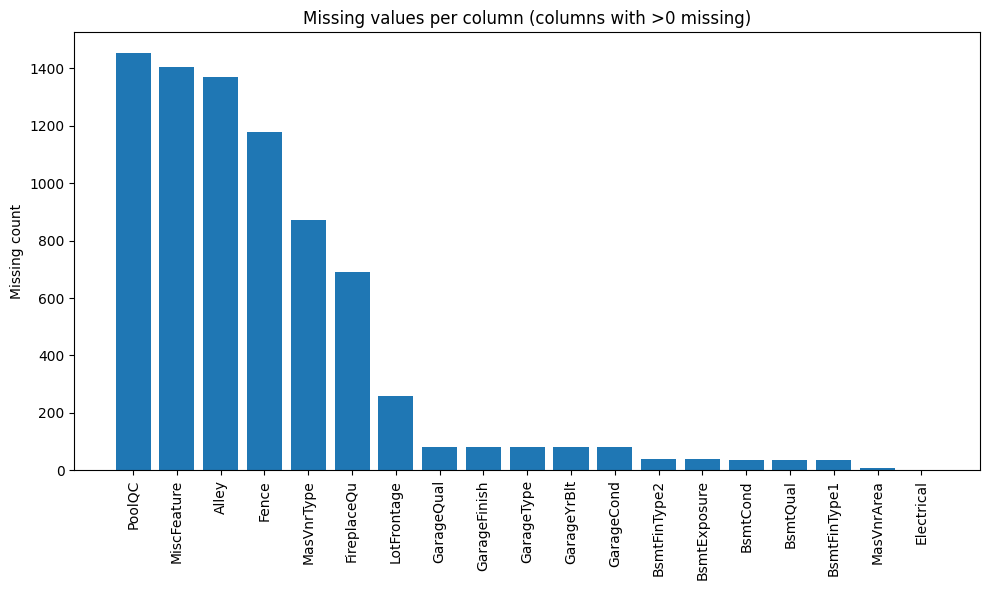

Columns with >20% missing values (consider drop or special imputation):
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
dtype: int64
--------------------------------------------------------------------------------


In [25]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]
if len(missing_counts) > 0:
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(missing_counts)), missing_counts.values)
    plt.xticks(range(len(missing_counts)), missing_counts.index, rotation=90)
    plt.title("Missing values per column (columns with >0 missing)")
    plt.ylabel("Missing count")
    plt.tight_layout()
    plt.show()
    # simple missingness summary
    big_missing = missing_counts[missing_counts > (0.2 * len(df))]
    if len(big_missing) > 0:
        print("Columns with >20% missing values (consider drop or special imputation):")
        print(big_missing)
    else:
        print("No column has more than 20% missing values.")
else:
    print("No missing values detected.")
print("-" * 80)

---
### Boxplots of target by low-cardinality categorical features

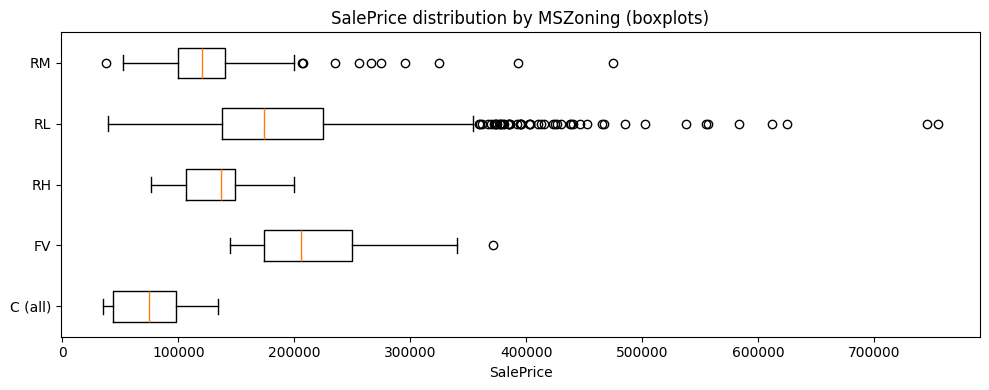

Interpretation: MSZoning boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


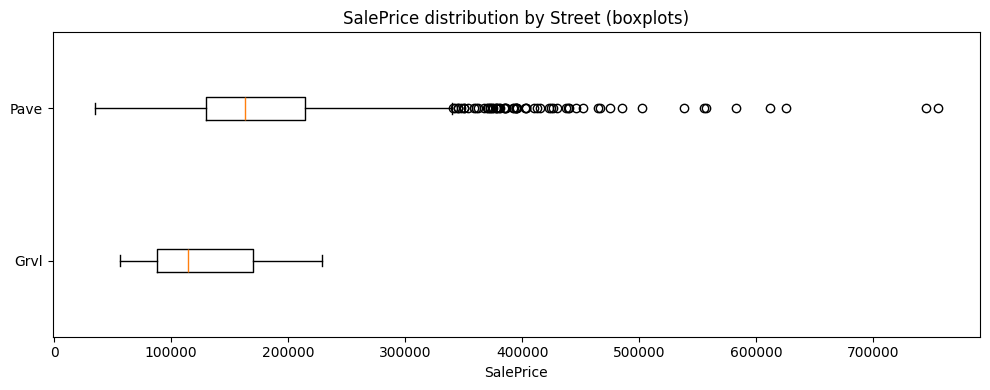

Interpretation: Street boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


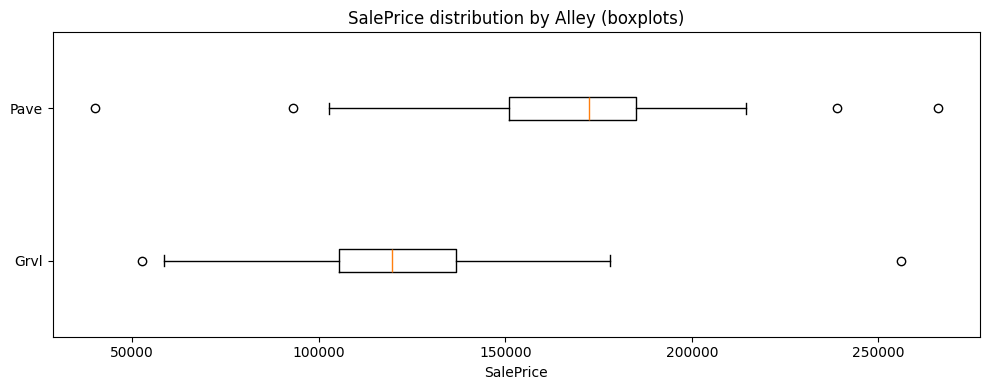

Interpretation: Alley boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


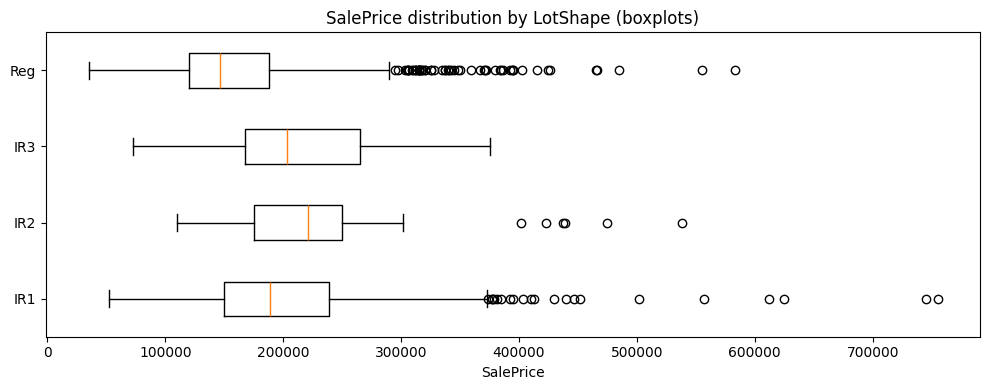

Interpretation: LotShape boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


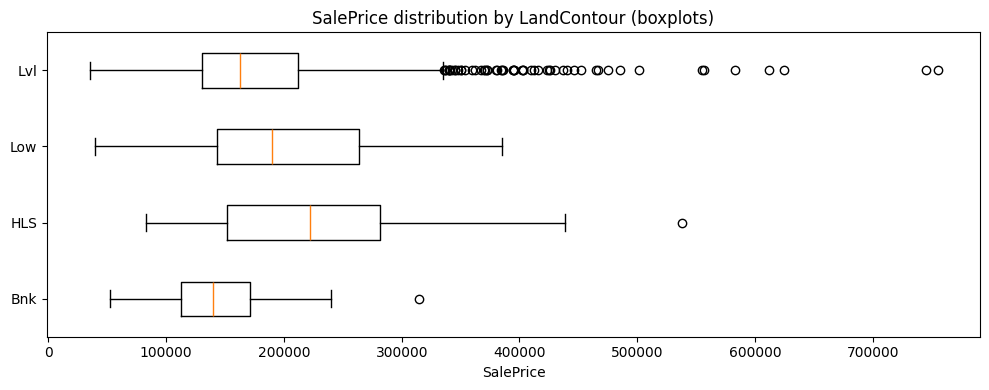

Interpretation: LandContour boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


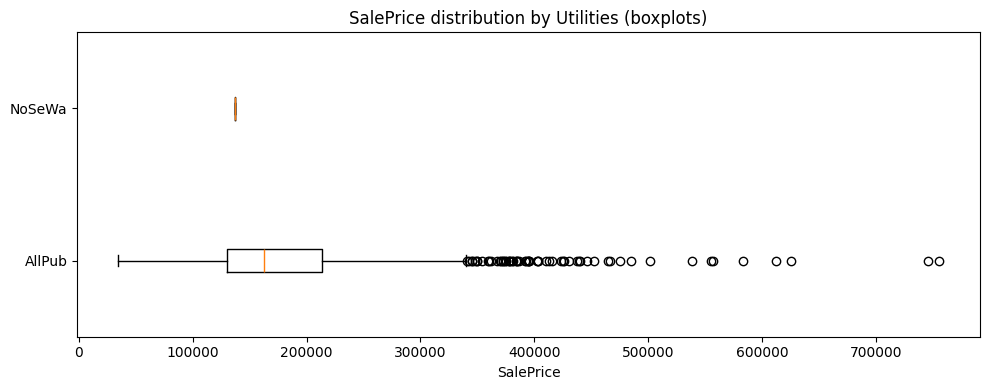

Interpretation: Utilities boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


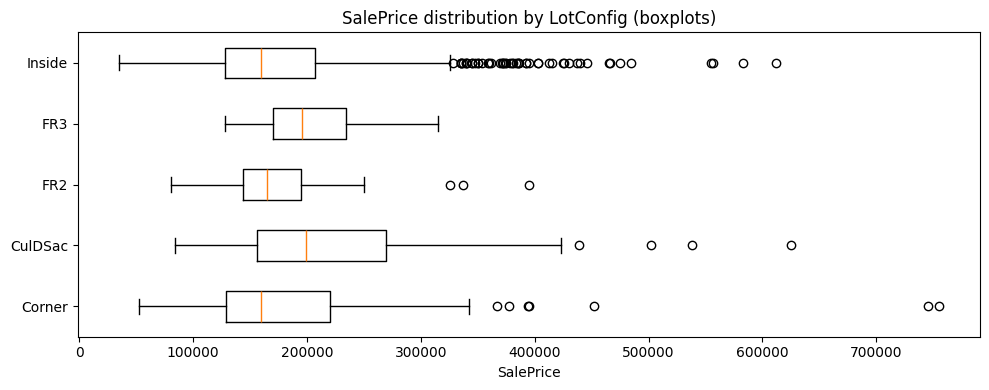

Interpretation: LotConfig boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


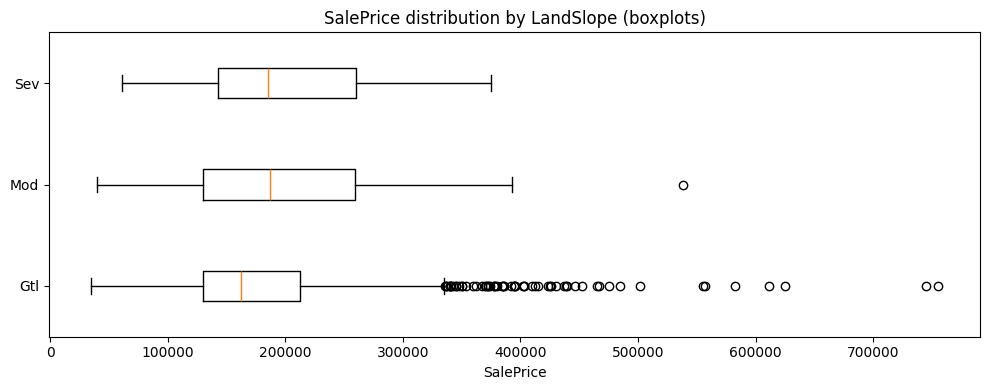

Interpretation: LandSlope boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


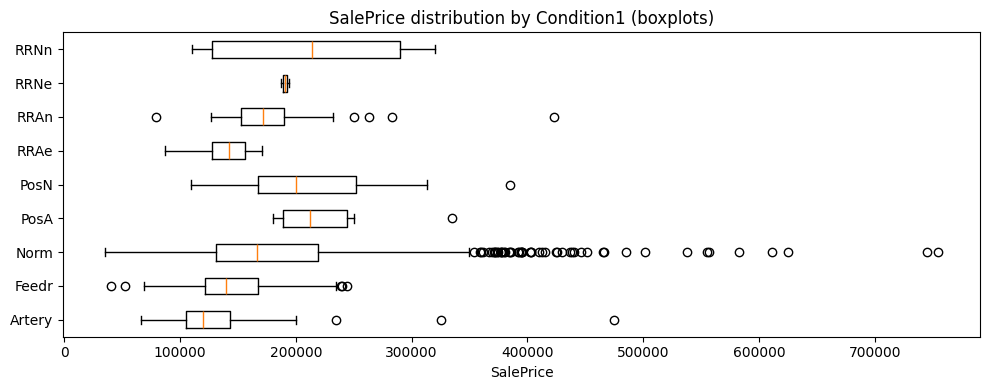

Interpretation: Condition1 boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


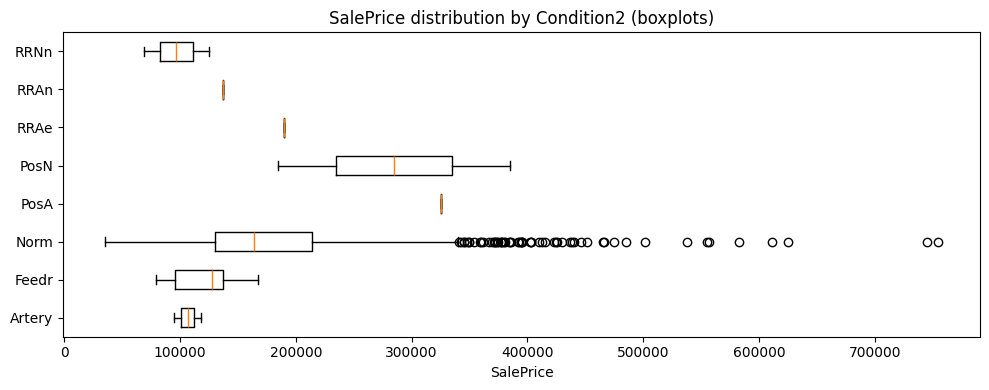

Interpretation: Condition2 boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


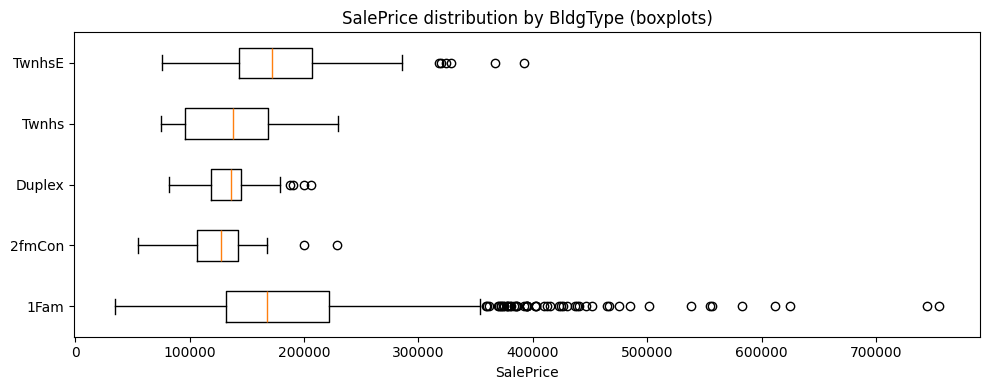

Interpretation: BldgType boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


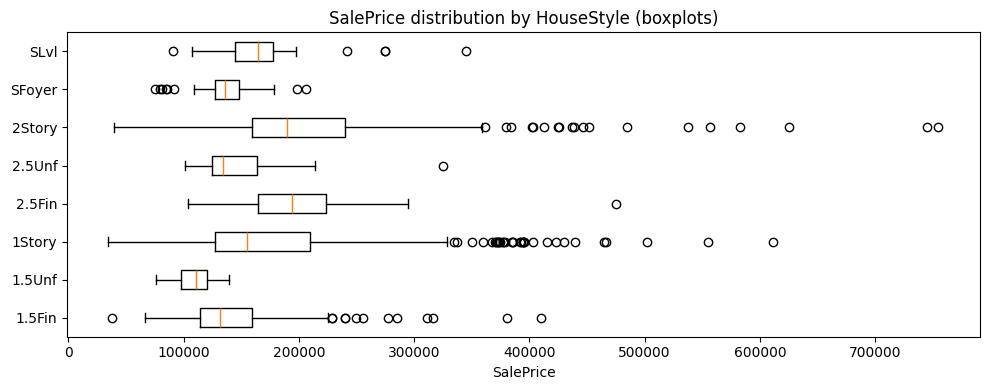

Interpretation: HouseStyle boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


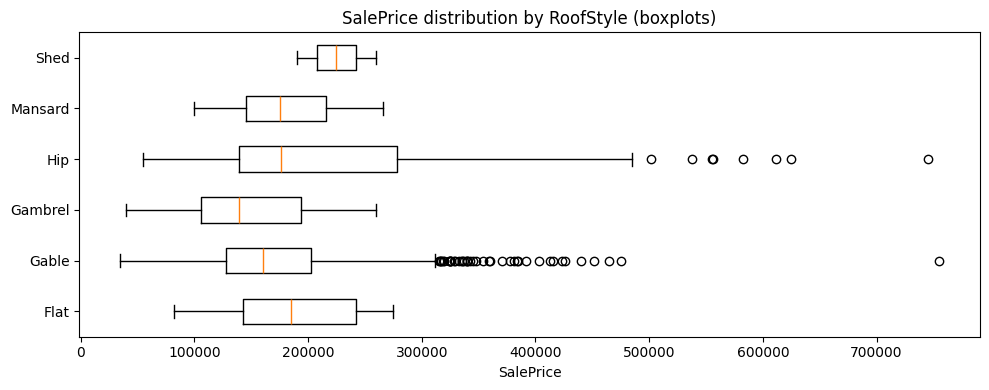

Interpretation: RoofStyle boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


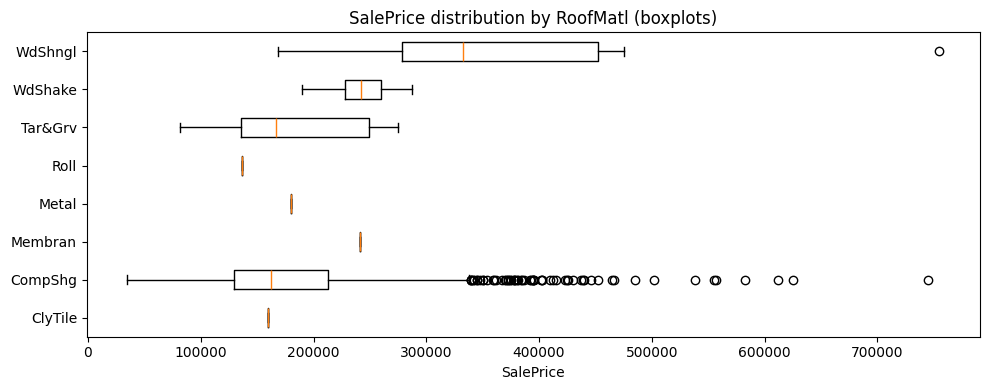

Interpretation: RoofMatl boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


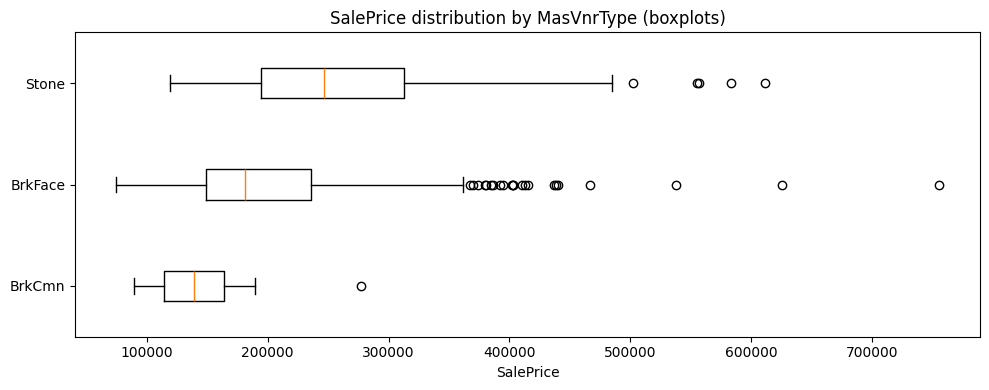

Interpretation: MasVnrType boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


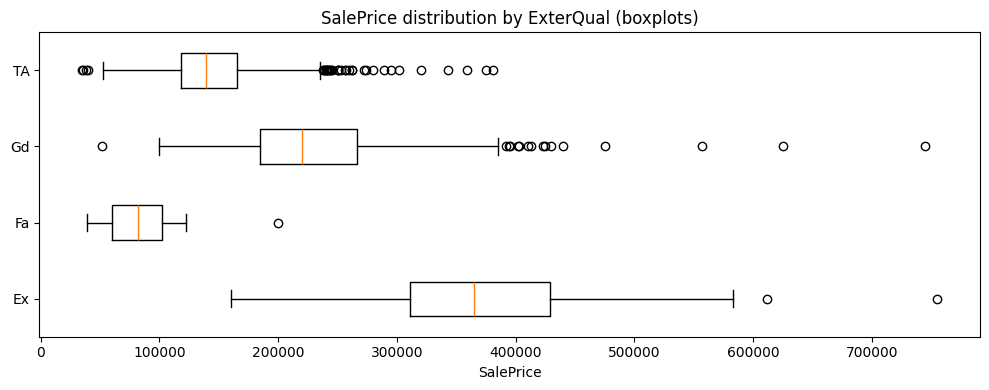

Interpretation: ExterQual boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


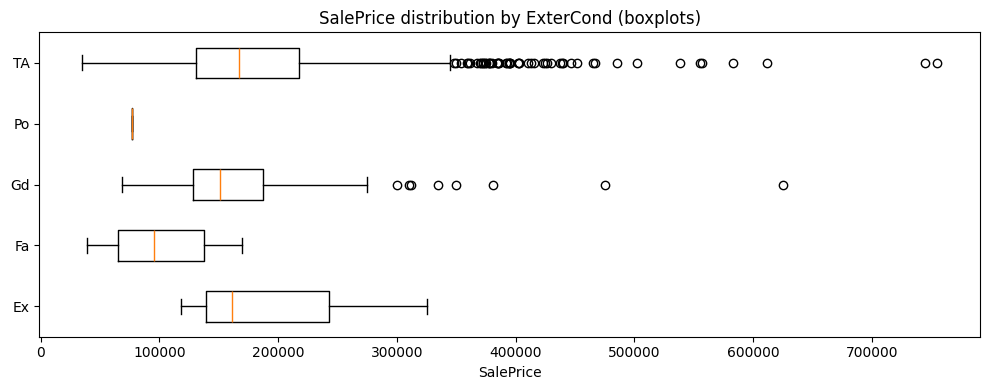

Interpretation: ExterCond boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


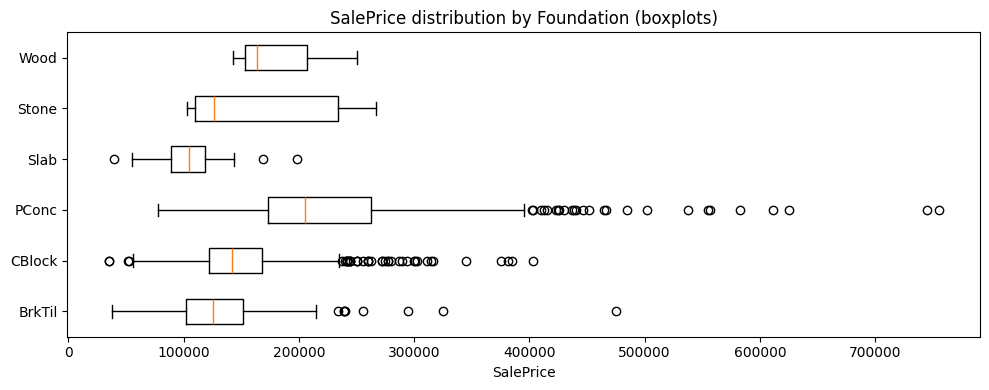

Interpretation: Foundation boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


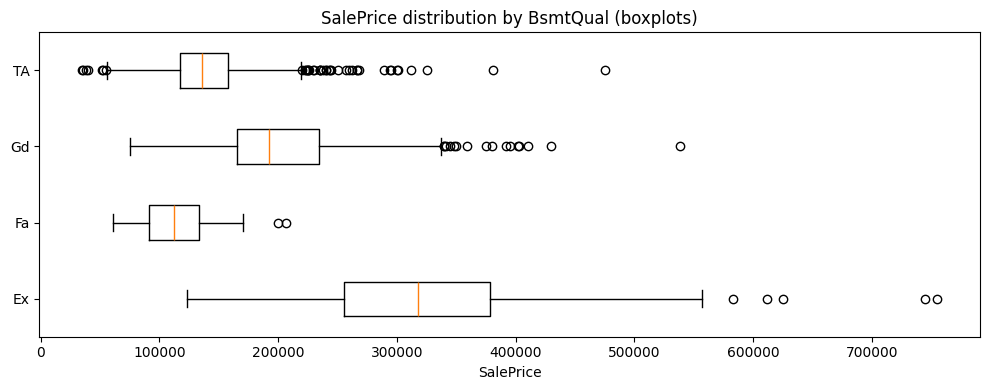

Interpretation: BsmtQual boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


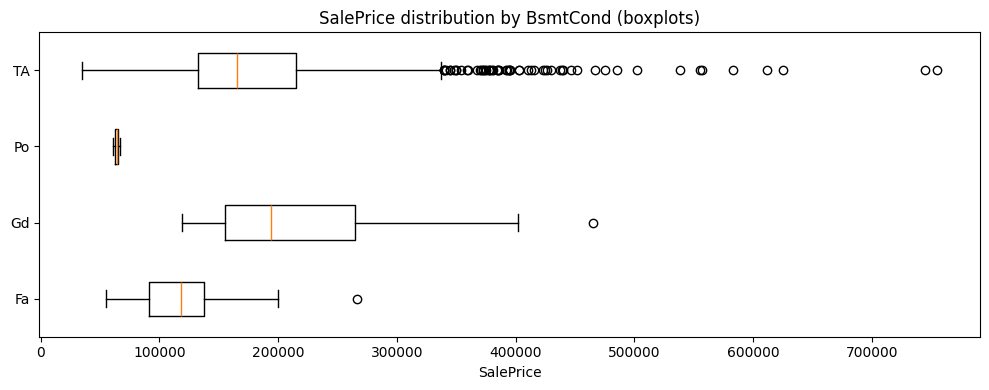

Interpretation: BsmtCond boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


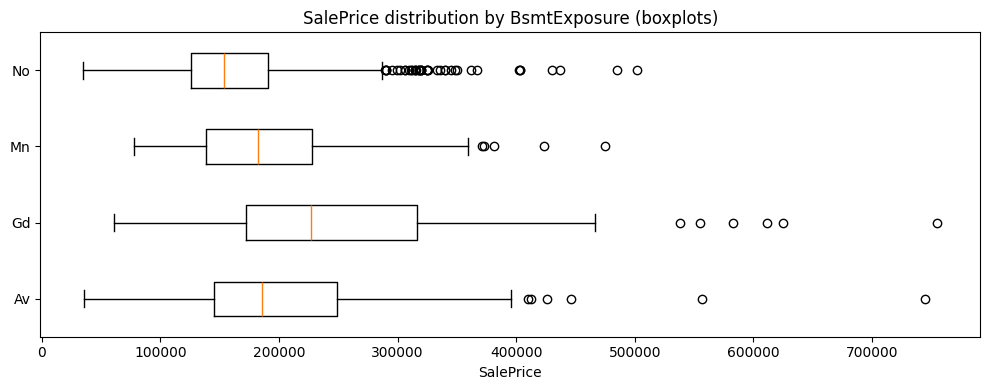

Interpretation: BsmtExposure boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


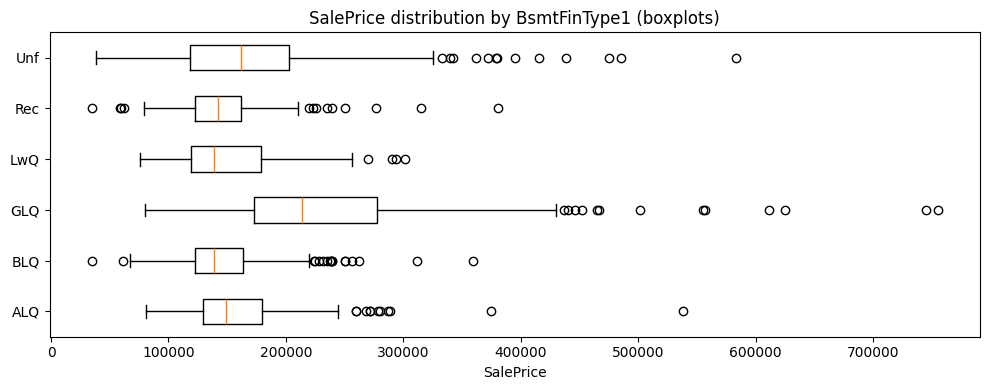

Interpretation: BsmtFinType1 boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


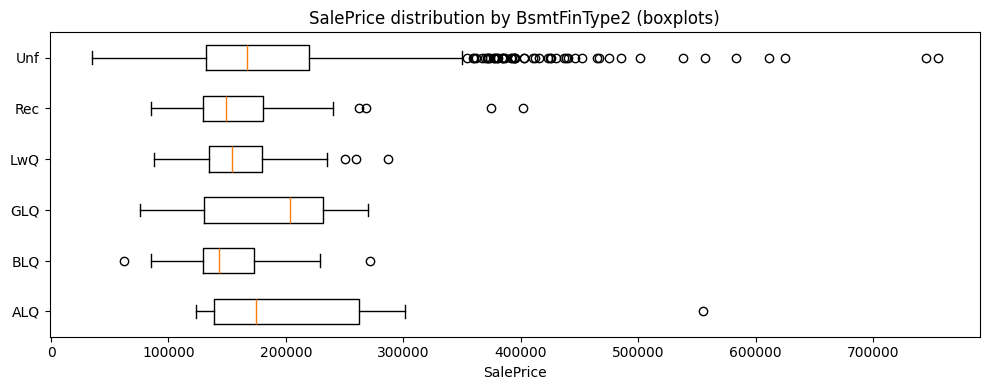

Interpretation: BsmtFinType2 boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


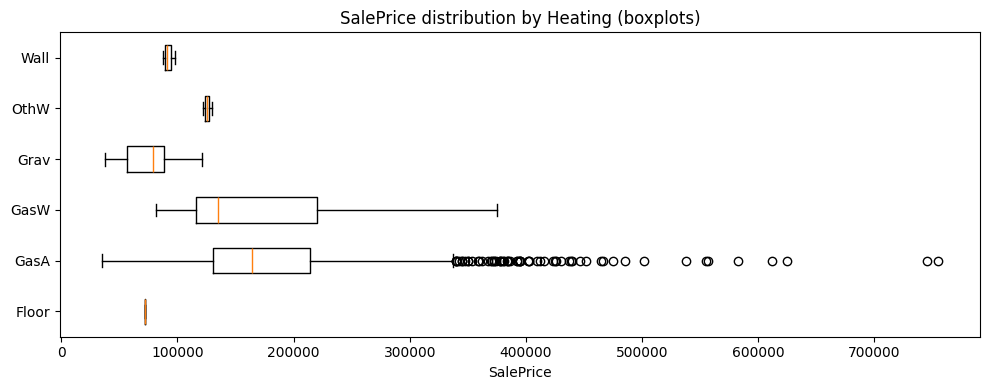

Interpretation: Heating boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


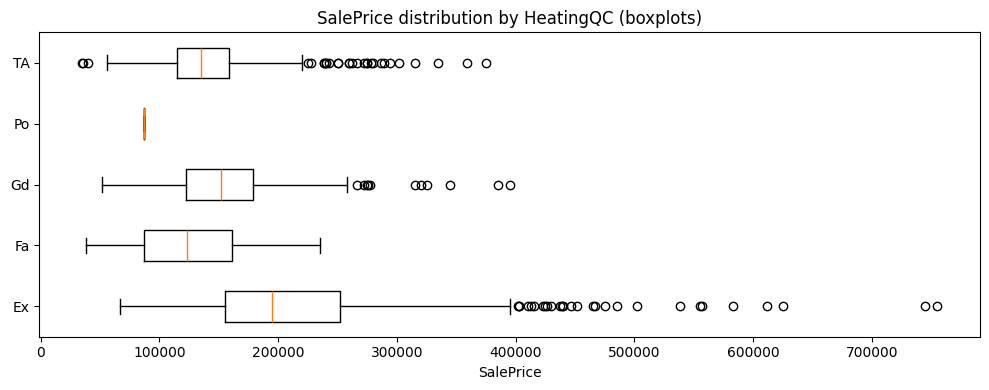

Interpretation: HeatingQC boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


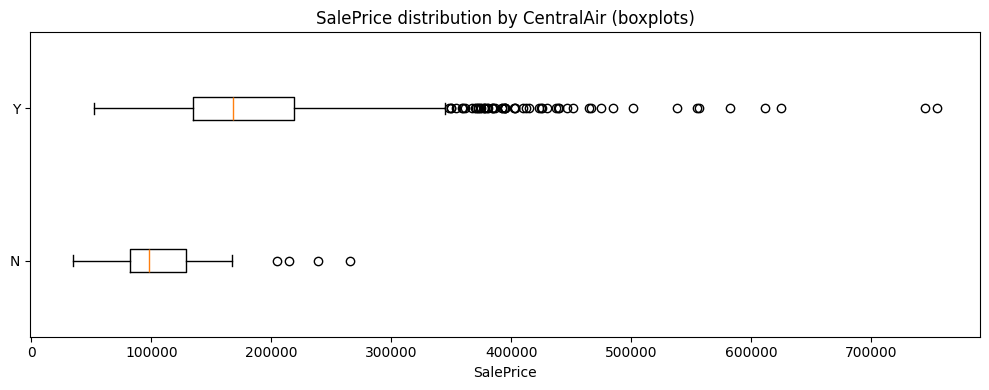

Interpretation: CentralAir boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


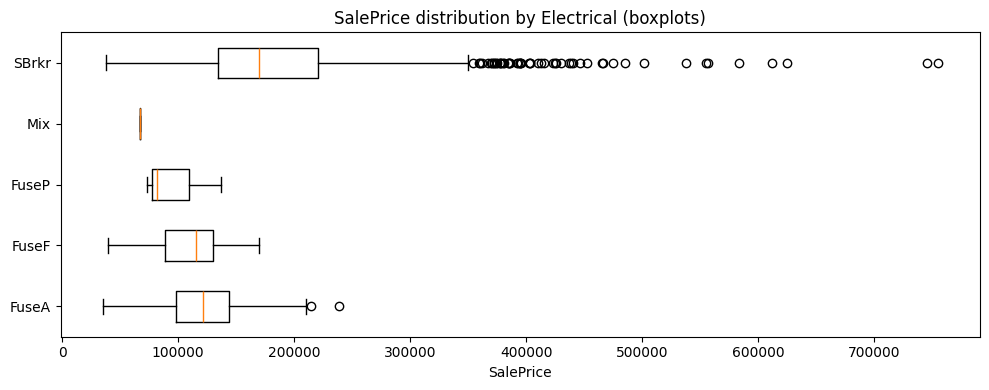

Interpretation: Electrical boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


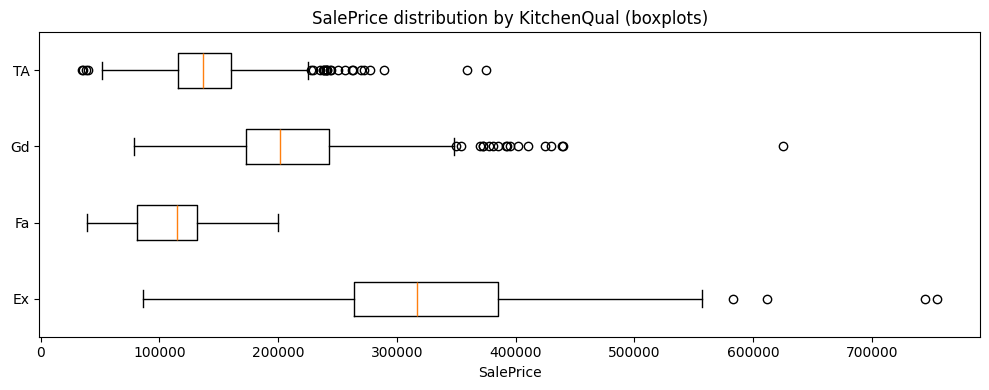

Interpretation: KitchenQual boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


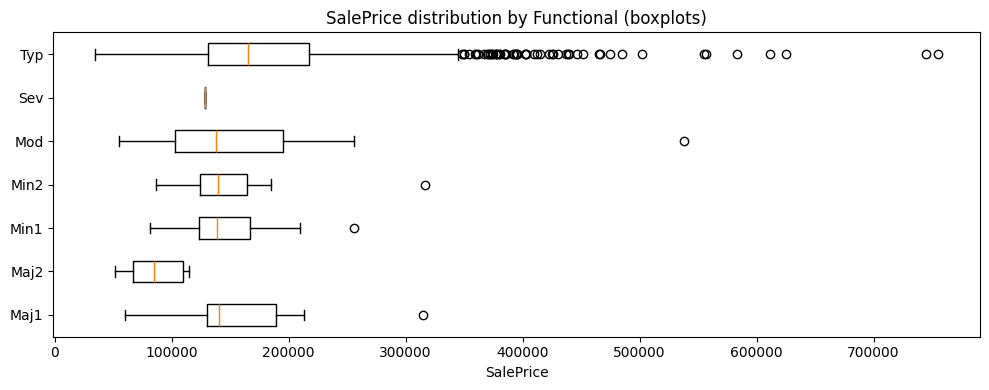

Interpretation: Functional boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


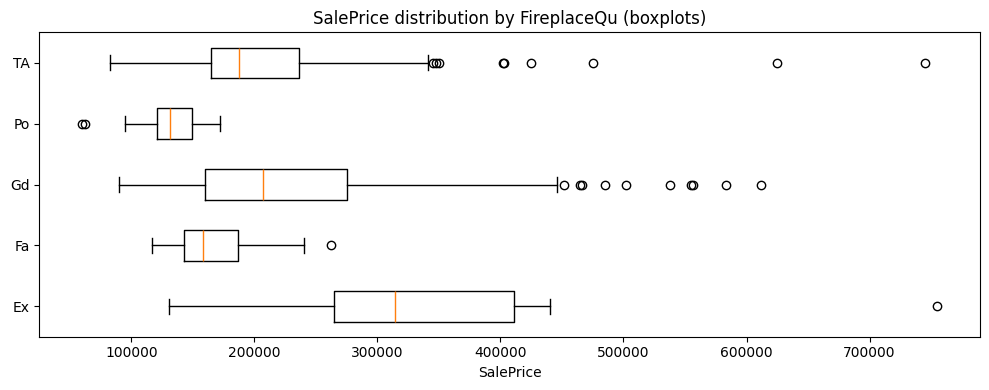

Interpretation: FireplaceQu boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


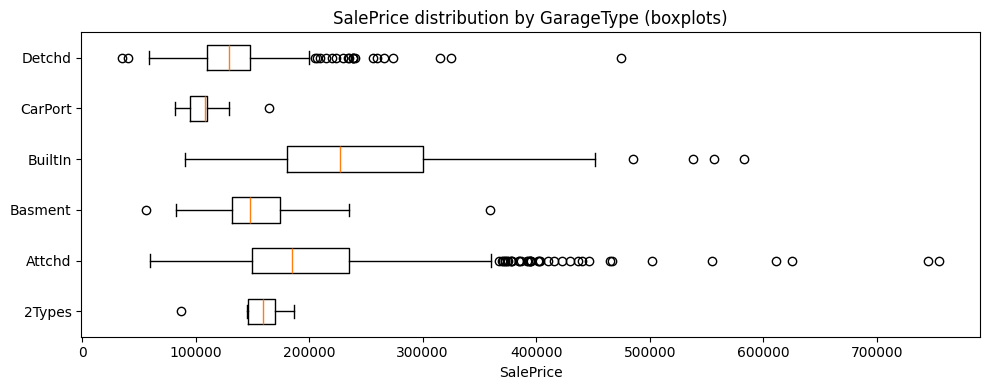

Interpretation: GarageType boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


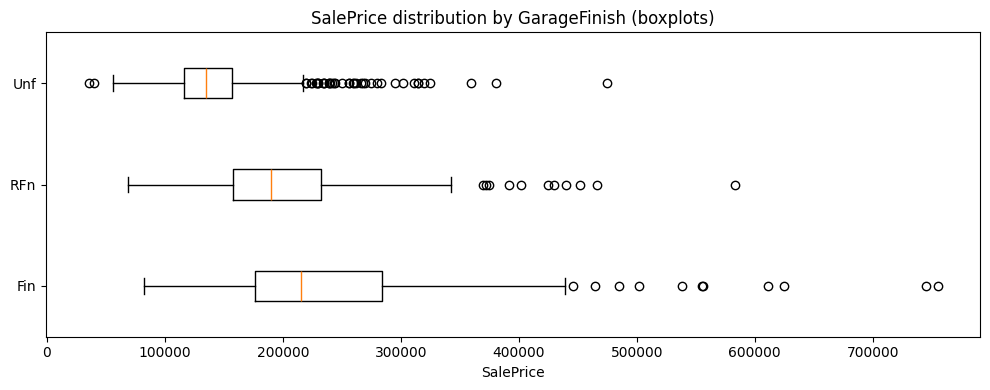

Interpretation: GarageFinish boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


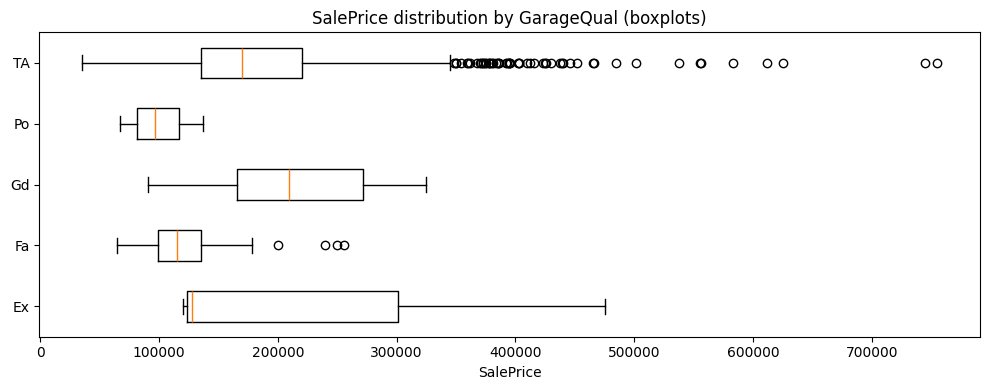

Interpretation: GarageQual boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


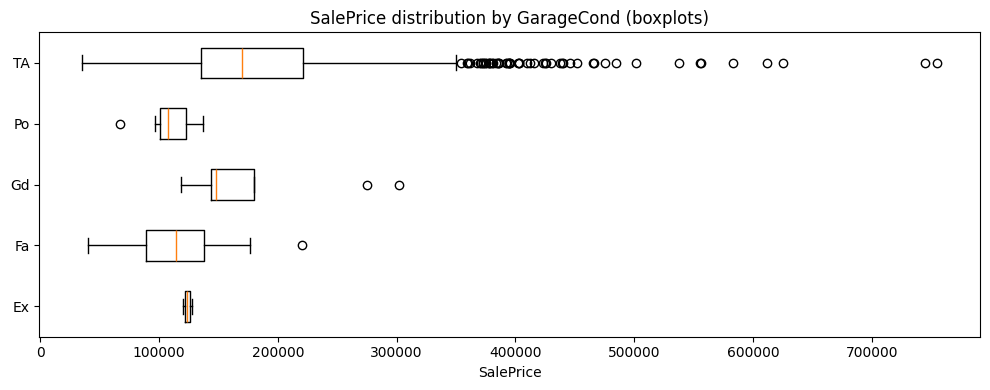

Interpretation: GarageCond boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


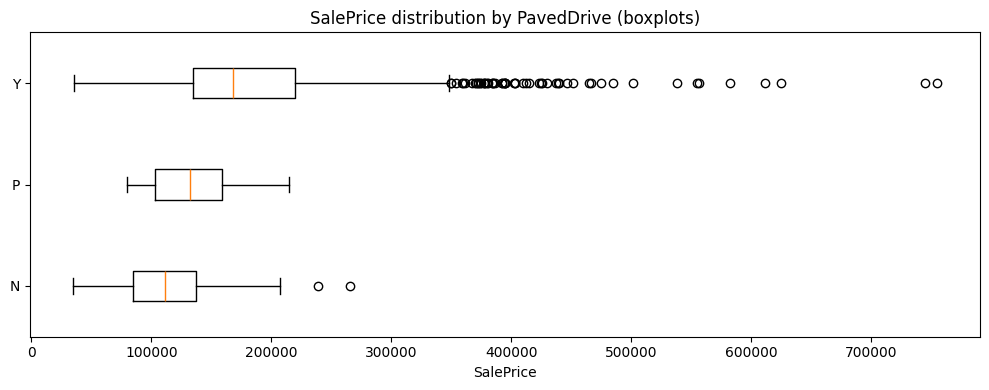

Interpretation: PavedDrive boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


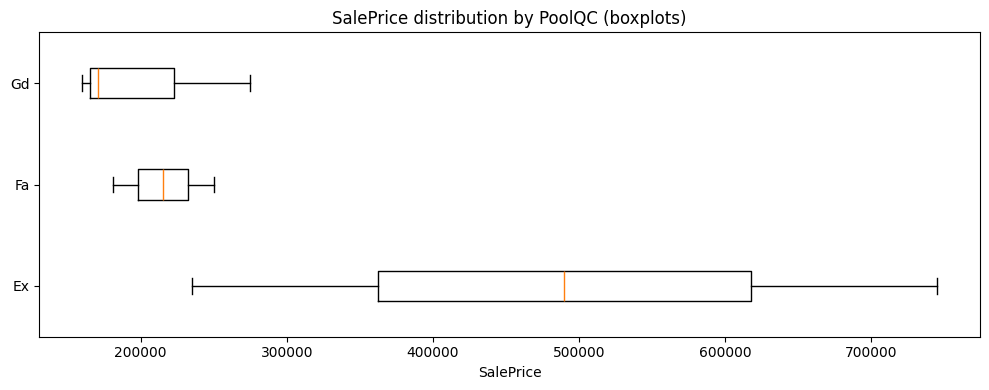

Interpretation: PoolQC boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


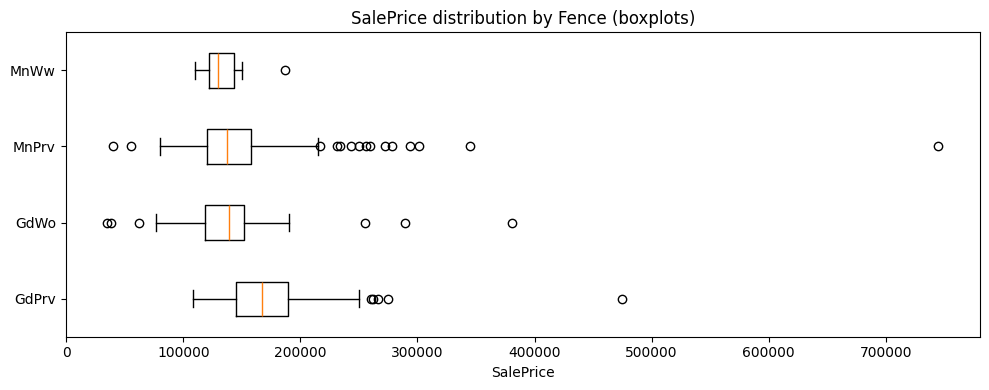

Interpretation: Fence boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


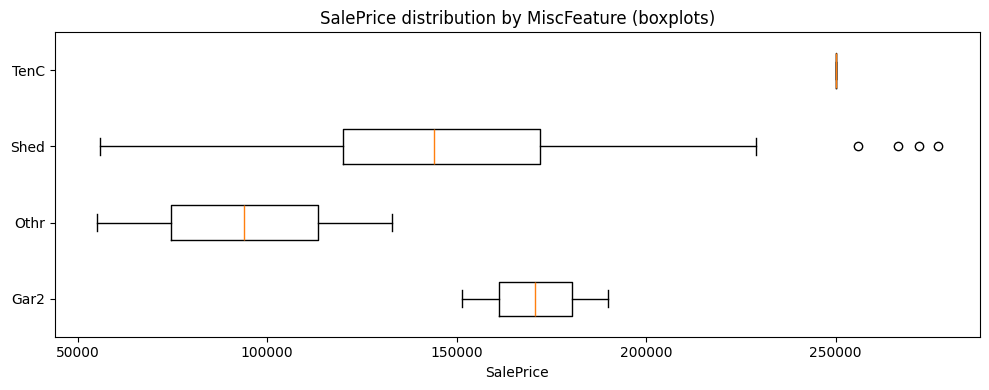

Interpretation: MiscFeature boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


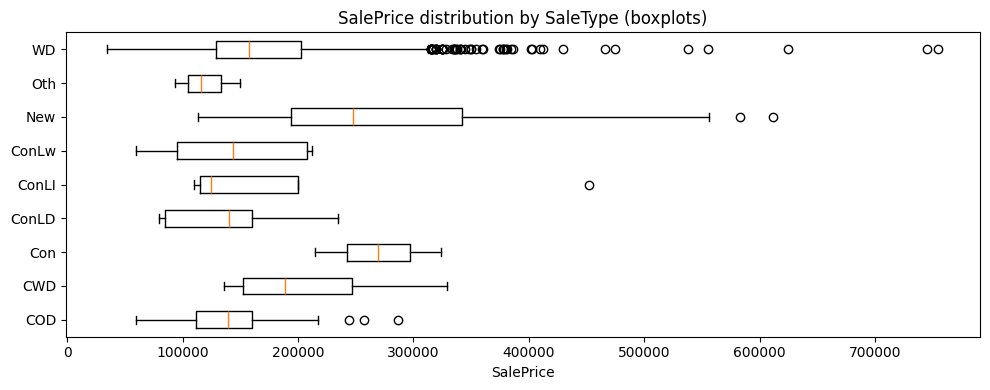

Interpretation: SaleType boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


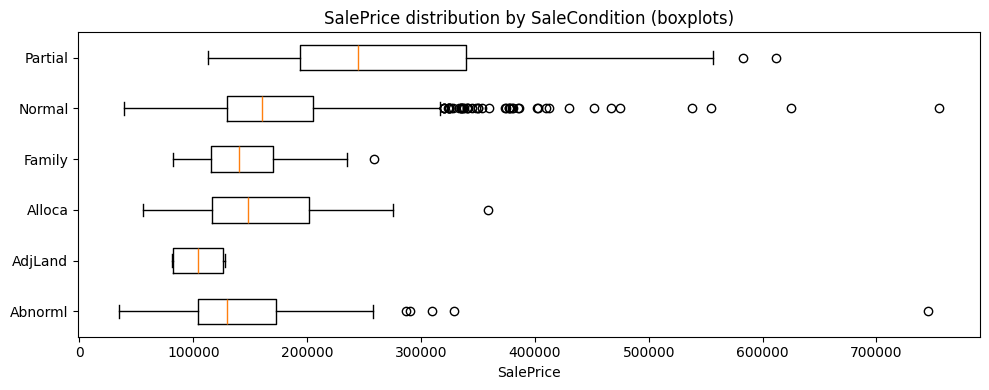

Interpretation: SaleCondition boxplots show spread and outliers of SalePrice across categories.
--------------------------------------------------------------------------------


In [26]:
small_cardinality_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= 10]
for c in small_cardinality_cats:
    groups = [group[TARGET].dropna().values for name, group in df.groupby(c)]
    labels = [str(name) for name, group in df.groupby(c)]
    if len(groups) > 1:
        plt.figure(figsize=(10, 4))
        plt.boxplot(groups, labels=labels, vert=False)
        plt.title(f"{TARGET} distribution by {c} (boxplots)")
        plt.xlabel(TARGET)
        plt.tight_layout()
        plt.show()
        print(f"Interpretation: {c} boxplots show spread and outliers of {TARGET} across categories.")
        print("-" * 80)

---
###  Relationship between two top numeric features correlated with target

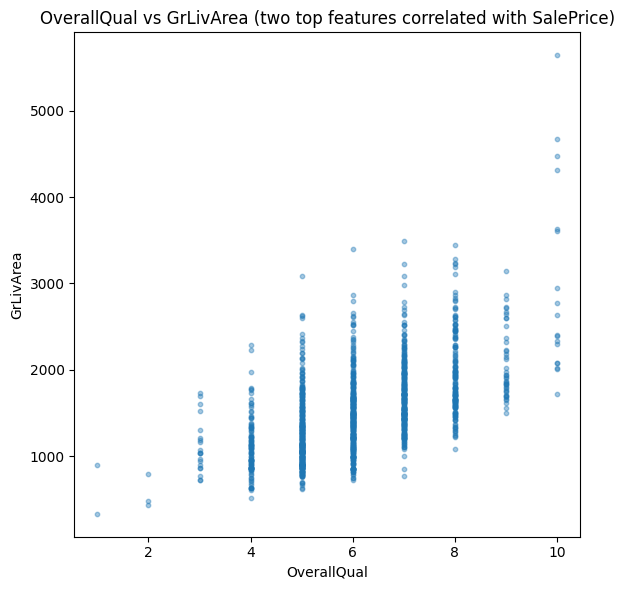

Interpretation: Visualize multicollinearity between OverallQual and GrLivArea. If they are strongly correlated, consider dimensionality reduction or feature selection.
--------------------------------------------------------------------------------


In [27]:

if TARGET in corrmat.columns:
    top2 = corrmat[TARGET].abs().sort_values(ascending=False).index.drop(TARGET).tolist()[:2]
    if len(top2) >= 2:
        a, b = top2[0], top2[1]
        plt.figure(figsize=(6,6))
        plt.scatter(df[a], df[b], alpha=0.4, s=10)
        plt.xlabel(a); plt.ylabel(b)
        plt.title(f"{a} vs {b} (two top features correlated with {TARGET})")
        plt.tight_layout()
        plt.show()
        print(f"Interpretation: Visualize multicollinearity between {a} and {b}. If they are strongly correlated, consider dimensionality reduction or feature selection.")
        print("-" * 80)


---
### Final reading guide for these plots:
> - Histograms/KDEs: identify skewed features and decide transforms (log1p, sqrt).
> - Boxplots: identify outliers; decide to cap, transform, or keep.
> - Scatter vs Target: evaluate linear vs non-linear associations; add polynomial or log transforms if appropriate.
> - Categorical counts: check for sample size per category; group rare categories if needed.
> - Median target per category: highlights categories with strong upward/downward impact on target.
> - Correlation heatmap: find highly correlated features (multicollinearity) and highly predictive numeric features.
> - Missingness chart: prioritize imputation or column removal for high-missing columns.
> - Scatter matrix: explore pairwise patterns, clusters, and non-linear relationships but use sampling for performance.


---
##  Data Preprocessing
---

## Why PCA is usually a bad idea here

1. __Dataset contains categorical variables → PCA cannot handle these directly.__ <br>After one-hot encoding, dimensionality explodes, and PCA mixes categories into non-interpretable components.
2. __PCA destroys meaning of features.__ <br>Instead of:
* OverallQual
* GrLivArea
* TotalBsmtSF <br>
You end up with:
* PC1
* PC2
* PC3<br>
which have no physical meaning for houses.
3. __Tree models DO NOT benefit from PCA.__ <br>
They perform worse because PCA removes structure they use for splits.
4. __PCA helps when features are numeric + strongly collinear__, like images or sensor data—not _housing data_.


### Log-transform for skewness

Target skewness: 1.883
Applied log1p transform to target. New target: SalePrice_log


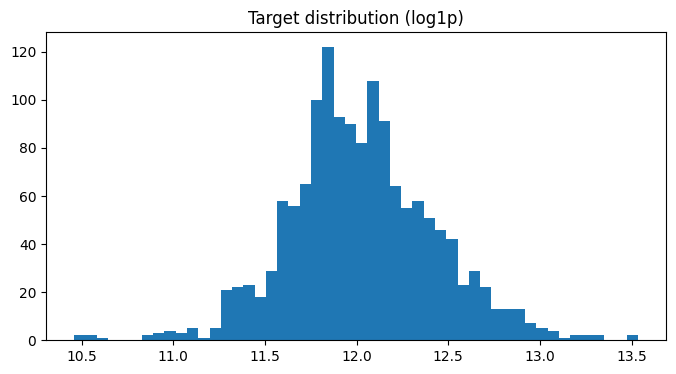

In [28]:
skewness = y_raw.dropna().skew()
print(f"Target skewness: {skewness:.3f}")
if abs(skewness) > 1.0:
    df[TARGET_RAW + "_log"] = np.log1p(df[TARGET_RAW])
    TARGET = TARGET_RAW + "_log"
    print("Applied log1p transform to target. New target:", TARGET)
    plt.figure(figsize=(8,4))
    plt.hist(df[TARGET].dropna(), bins=50)
    plt.title("Target distribution (log1p)")
    plt.show()
else:
    TARGET = TARGET_RAW

---
### Drop Highly Correlated Features

In [29]:
corr_threshold = 0.85
numeric_df = df.select_dtypes(include=['int64','float64'])
corr_matrix = numeric_df.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > corr_threshold)
]

print("Dropping highly correlated features:", to_drop)
df = df.drop(columns=to_drop)   # apply drop

print("New Shape:", df.shape)

Dropping highly correlated features: ['GarageArea', 'SalePrice_log']
New Shape: (1460, 80)


In [30]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF

---
###  Feature split


In [32]:
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

---
### Reduce high-cardinality categorical features (simple strategy)

In [33]:
def reduce_cardinality(series, threshold=0.01):
    counts = series.value_counts(normalize=True)
    keep = counts[counts>threshold].index
    return series.where(series.isin(keep), other='Other')

# Recompute categorical and numerical lists based on the current state of X
# This ensures `num_cols` and `cat_cols` reflect the columns actually in X after 'Id' and other columns (if any) are dropped.
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

high_card_cols = [c for c in cat_cols if X[c].nunique(dropna=True) > 40]
for c in high_card_cols:
    X[c] = reduce_cardinality(X[c], threshold=0.01)

# Recompute categorical list again if changed due to cardinality reduction
# num_cols doesn't change due to cardinality reduction, so no need to recompute here.
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

---
### Preprocessing pipelines

In [34]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder='drop')

---
## Model Building
---

### Model evaluation helper

In [35]:
def cv_rmse(model_pipeline, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    neg_mse = cross_val_score(model_pipeline, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1)
    r2 = cross_val_score(model_pipeline, X, y, scoring="r2", cv=kf, n_jobs=-1)
    rmse_scores = np.sqrt(-neg_mse)
    return rmse_scores.mean(), rmse_scores.std(), r2.mean()

---
### Define models to compare

In [36]:
models = {
    "LinearRegression": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
    "RidgeCV": Pipeline([("pre", preprocessor), ("model", RidgeCV(alphas=[0.1, 1.0, 10.0]))]),
    "LassoCV": Pipeline([("pre", preprocessor), ("model", LassoCV(cv=5, random_state=42, max_iter=5000))]),
    "RandomForest": Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))]),
    "GradientBoosting": Pipeline([("pre", preprocessor), ("model", GradientBoostingRegressor(n_estimators=200, random_state=42))])
}

---
### Cross-validated comparison

In [37]:

results = []
print("\nRunning cross-validated evaluation (this may take a few minutes)...")
for name, pipeline in models.items():
    print("Evaluating:", name)
    rmse_mean, rmse_std, r2_mean = cv_rmse(pipeline, X, y, cv=5)
    results.append({"model": name, "cv_rmse": rmse_mean, "cv_rmse_std": rmse_std, "cv_r2": r2_mean})

results_df = pd.DataFrame(results).sort_values("cv_rmse")
display(results_df)


Running cross-validated evaluation (this may take a few minutes)...
Evaluating: LinearRegression
Evaluating: RidgeCV
Evaluating: LassoCV
Evaluating: RandomForest
Evaluating: GradientBoosting


model       cv_rmse   cv_rmse_std     cv_r2
4  GradientBoosting  29195.097182  11281.291377  0.835478
3      RandomForest  30175.787256   7072.534369  0.841567
2           LassoCV  31535.892563  11503.739494  0.812738
1           RidgeCV  33036.949463  11365.341248  0.797492
0  LinearRegression  34870.639204   9998.071293  0.779703

---
### Holdout train/test evaluation

In [38]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

fitted_results = []
for name, pipeline in models.items():
    print("Training and evaluating on holdout:", name)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, preds)
    fitted_results.append({"model": name, "test_rmse": rmse, "test_r2": r2})

fitted_df = pd.DataFrame(fitted_results).sort_values("test_rmse")
display(fitted_df)

Training and evaluating on holdout: LinearRegression
Training and evaluating on holdout: RidgeCV
Training and evaluating on holdout: LassoCV
Training and evaluating on holdout: RandomForest
Training and evaluating on holdout: GradientBoosting


model     test_rmse   test_r2
4  GradientBoosting  26588.093724  0.907836
3      RandomForest  28304.489391  0.895553
0  LinearRegression  29052.879127  0.889956
2           LassoCV  29564.987910  0.886043
1           RidgeCV  30670.550058  0.877361

---
### Feature importance (RandomForest)


Top 20 feature importances (RandomForest):


feature  importance
3         OverallQual    0.555088
15          GrLivArea    0.124124
11        TotalBsmtSF    0.034720
13           2ndFlrSF    0.031748
8          BsmtFinSF1    0.028068
12           1stFlrSF    0.027870
2             LotArea    0.018521
25         GarageCars    0.017418
5           YearBuilt    0.012804
1         LotFrontage    0.009033
6        YearRemodAdd    0.007147
176       BsmtQual_Ex    0.006708
22       TotRmsAbvGrd    0.006275
24        GarageYrBlt    0.006234
240  GarageFinish_Unf    0.006157
18           FullBath    0.006138
27        OpenPorchSF    0.005818
10          BsmtUnfSF    0.004975
26         WoodDeckSF    0.004416
211      CentralAir_Y    0.004081

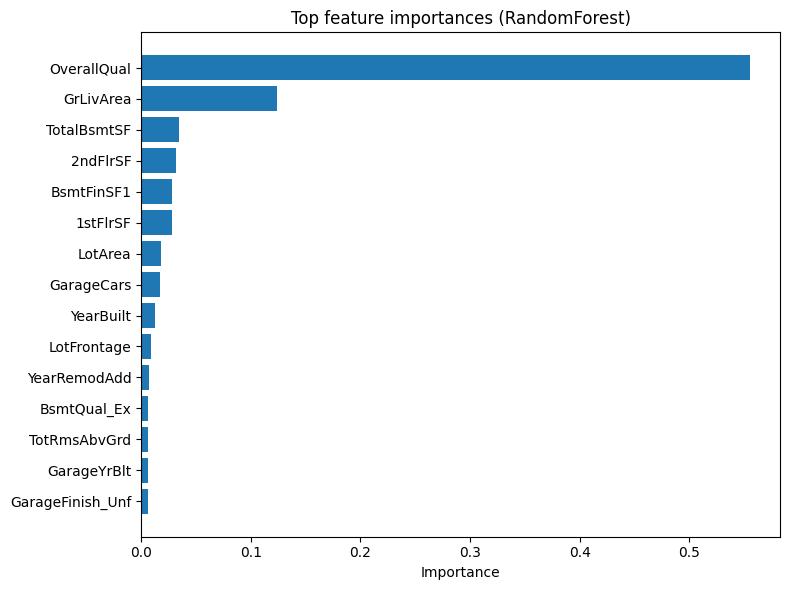

In [39]:
# Re-fit RandomForest to get feature importances and extract feature names
rf_pipe = models["RandomForest"]
rf_pipe.fit(X_train, y_train)

# Extract feature names after preprocessing
pre = rf_pipe.named_steps["pre"]
num_features = num_cols.copy()
cat_features = []
if len(cat_cols) > 0:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    try:
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    except Exception:
        # fallback if older sklearn version
        ohe_names = ohe.get_feature_names(cat_cols).tolist()
    cat_features = ohe_names

feature_names = num_features + cat_features
importances = rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
print("\nTop 20 feature importances (RandomForest):")
display(feat_imp.head(20))

# Plot top 15
plt.figure(figsize=(8,6))
top_n = min(15, feat_imp.shape[0])
plt.barh(feat_imp['feature'].head(top_n)[::-1], feat_imp['importance'].head(top_n)[::-1])
plt.xlabel("Importance")
plt.title("Top feature importances (RandomForest)")
plt.tight_layout()
plt.show()


---
### Invert Prediction as Target was Log-Transformed

In [40]:

# ---------- If target was log-transformed: show how to invert predictions ----------
if TARGET.endswith("_log"):
    print("\nNote: Target was trained on log1p scale. To obtain SalePrice predictions in dollars, use np.expm1(preds).")

# ---------- Summary and suggested next steps ----------
print("\nSummary Conclusion:")
best_cv = results_df.iloc[0]
best_test = fitted_df.iloc[0]
print(f"- Best by CV RMSE: {best_cv['model']} (CV RMSE = {best_cv['cv_rmse']:.3f}, CV R2 = {best_cv['cv_r2']:.3f})")
print(f"- Best on holdout test: {best_test['model']} (Test RMSE = {best_test['test_rmse']:.3f}, Test R2 = {best_test['test_r2']:.3f})")




Note: Target was trained on log1p scale. To obtain SalePrice predictions in dollars, use np.expm1(preds).

Summary Conclusion:
- Best by CV RMSE: GradientBoosting (CV RMSE = 29195.097, CV R2 = 0.835)
- Best on holdout test: GradientBoosting (Test RMSE = 26588.094, Test R2 = 0.908)


## Partial Conclusion
1. __Cross-Validation Performance__
   * Best Model: GradientBoosting
   * CV RMSE: 29,195
   * CV R²: 0.835
   * This means that across multiple folds, GradientBoosting generalized better than all other models.
A CV R² of 0.835 suggests the model explains 83.5% of variance consistently.
2. __Holdout Test Performance__
    * Best Model on Test Set: GradientBoosting
    * Test RMSE: 26,588
    * Test R²: 0.908
    * The model performs even better on the final unseen data than in CV.
An R² of 0.908 means the model explains 90.8% of the variation in the target variable.

### Next Steps
> 1) Perform domain-informed feature engineering (living area per room, age when sold, recent renovations, interaction terms).
2) Try advanced gradient boosting libraries (XGBoost, LightGBM, CatBoost) with careful hyperparameter tuning.
3) Use K-fold stacking/ensembling of top-performing models to reduce generalization error.
4) Address features with large missingness explicitly (drop or impute based on domain).
5) If you need final dollar predictions, remember to inverse the log transform with np.expm1. give a code as the continuation of above code doing these steps and also select the best model and predict using it

---
## Try importing boosters

In [41]:
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None
try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None
print("Libraries loaded. xgboost:", bool(xgb), "lightgbm:", bool(lgb), "catboost:", bool(CatBoostRegressor))
# if any lib not installed install in the below cell

Libraries loaded. xgboost: True lightgbm: True catboost: False


In [42]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.8 MB/s eta 0:00:00


---
## Safety checks

In [43]:
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# If TARGET not present, try to detect last numeric as fallback (keeps robustness)
if TARGET not in df.columns:
    numeric_cols_all = df.select_dtypes(include=['int64','float64']).columns.tolist()
    if len(numeric_cols_all) == 0:
        raise ValueError("TARGET not found and no numeric columns to infer from.")
    TARGET = numeric_cols_all[-1]
    print("TARGET not found; falling back to:", TARGET)


TARGET not found; falling back to: SalePrice


---
## Feature engineering (domain-informed)
* Add a few useful engineered features commonly used in house-price datasets.
* Guard with try/except to avoid KeyErrors if particular columns are absent.

In [44]:
df_fe = df.copy()

# Total living area proxies
try:
    df_fe['TotalArea'] = df_fe.get('GrLivArea', 0).fillna(0) + df_fe.get('TotalBsmtSF', 0).fillna(0)
except Exception:
    df_fe['TotalArea'] = df_fe.get('GrLivArea', 0).fillna(0)

# Living area per room (if TotRmsAbvGrd present)
if 'TotRmsAbvGrd' in df_fe.columns and df_fe['TotRmsAbvGrd'].dtype in [np.int64, np.float64]:
    df_fe['LivingArea_per_Room'] = df_fe['GrLivArea'].fillna(0) / (df_fe['TotRmsAbvGrd'].replace(0, np.nan).fillna(1))
else:
    df_fe['LivingArea_per_Room'] = df_fe['GrLivArea'].fillna(0)

# Age of house when sold and since remodel
if 'YearBuilt' in df_fe.columns and 'YrSold' in df_fe.columns:
    df_fe['HouseAgeAtSale'] = df_fe['YrSold'] - df_fe['YearBuilt']
if 'YearRemodAdd' in df_fe.columns and 'YrSold' in df_fe.columns:
    df_fe['RemodAgeAtSale'] = df_fe['YrSold'] - df_fe['YearRemodAdd']
else:
    # fallback: set to 0 if not available
    df_fe['RemodAgeAtSale'] = df_fe.get('YearRemodAdd', df_fe.get('YearBuilt', 0))
    if ('YrSold' in df_fe.columns) and ('YearRemodAdd' in df_fe.columns):
        df_fe['RemodAgeAtSale'] = df_fe['YrSold'] - df_fe['YearRemodAdd']

# Recent renovation flag (boolean)
if 'YearRemodAdd' in df_fe.columns and 'YrSold' in df_fe.columns:
    df_fe['RecentlyRemodeled'] = ((df_fe['YrSold'] - df_fe['YearRemodAdd']) <= 5).astype(int)
else:
    df_fe['RecentlyRemodeled'] = 0

# Interaction examples: OverallQual * TotalArea, OverallQual * GrLivArea (if OverallQual present)
if 'OverallQual' in df_fe.columns:
    df_fe['Qual_x_TotalArea'] = df_fe['OverallQual'] * df_fe['TotalArea']
    if 'GrLivArea' in df_fe.columns:
        df_fe['Qual_x_GrLivArea'] = df_fe['OverallQual'] * df_fe['GrLivArea']

print("Before Feature Engineering, Old shape:",df.shape)
print("Feature engineering complete. New shape:", df_fe.shape)
print("New columns:", [c for c in df_fe.columns if c not in df.columns])

Before Feature Engineering, Old shape: (1460, 79)
Feature engineering complete. New shape: (1460, 86)
New columns: ['TotalArea', 'LivingArea_per_Room', 'HouseAgeAtSale', 'RemodAgeAtSale', 'RecentlyRemodeled', 'Qual_x_TotalArea', 'Qual_x_GrLivArea']


---
## Missingness handling
> Drop columns with excessive missingness (configurable threshold)


In [45]:
missing_thresh = 0.5  # drop columns with >50% missing values
missing_frac = df_fe.isnull().mean()
cols_to_drop_missing = missing_frac[missing_frac > missing_thresh].index.tolist()
if cols_to_drop_missing:
    print("Dropping columns with >50% missing:", cols_to_drop_missing)
    df_fe = df_fe.drop(columns=cols_to_drop_missing)

Dropping columns with >50% missing: ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


---
## Prepare feature lists for preprocessing

In [46]:
# Separate X and y
X = df_fe.drop(columns=[TARGET])
y = df_fe[TARGET].copy()

# Simple heuristic: numeric and categorical lists
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove extremely high cardinality categoricals from one-hot: keep top frequent categories and mark others 'Other'
def reduce_cardinality_col(series, keep_top=30):
    top = series.value_counts().nlargest(keep_top).index
    return series.where(series.isin(top), other='Other')

for c in categorical_features:
    if X[c].nunique(dropna=True) > 100:  # threshold can be adjusted
        X[c] = reduce_cardinality_col(X[c], keep_top=50)

# Recompute lists in case changes
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print(f"Final feature counts -> Numeric: {len(numeric_features)}, Categorical: {len(categorical_features)}")

Final feature counts -> Numeric: 42, Categorical: 38


---
## Preprocessing pipelines

In [47]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')


---
## Train/test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train/test sizes:", X_train.shape, X_test.shape)

# Helper function: evaluate a pipeline with cross-validated RMSE
def cv_rmse_scorer(pipeline, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    neg_mse = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    rmse = np.sqrt(-neg_mse)
    return rmse.mean(), rmse.std()

Train/test sizes: (1168, 80) (292, 80)


---
## Define candidate advanced models with light hyperparameter search

In [49]:
estimators_for_search = {}

# XGBoost
if xgb is not None:
    xgb_pipe = Pipeline([('pre', preprocessor),
                         ('model', xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42, verbosity=0))])
    xgb_params = {
        'model__n_estimators': [100, 300, 600],
        'model__max_depth': [3, 5, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.5, 0.8, 1.0]
    }
    estimators_for_search['XGBoost'] = (xgb_pipe, xgb_params)

# LightGBM
if lgb is not None:
    lgb_pipe = Pipeline([('pre', preprocessor),
                         ('model', lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1))])
    lgb_params = {
        'model__n_estimators': [100, 300, 600],
        'model__num_leaves': [31, 50, 100],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__subsample': [0.6, 0.8, 1.0]
    }
    estimators_for_search['LightGBM'] = (lgb_pipe, lgb_params)

# CatBoost
if CatBoostRegressor is not None:
    cat_pipe = Pipeline([('pre', preprocessor),
                         ('model', CatBoostRegressor(verbose=0, random_state=42))])
    cat_params = {
        'model__iterations': [200, 500],
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 7]
    }
    estimators_for_search['CatBoost'] = (cat_pipe, cat_params)

In [50]:

# Also include a strong baseline (GradientBoostingRegressor from sklearn) if boosters missing
from sklearn.ensemble import GradientBoostingRegressor
gb_pipe = Pipeline([('pre', preprocessor),
                    ('model', GradientBoostingRegressor(random_state=42))])
gb_params = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}
estimators_for_search['GradientBoosting'] = (gb_pipe, gb_params)

# Simple Ridge baseline
ridge_pipe = Pipeline([('pre', preprocessor), ('model', Ridge())])
ridge_params = {'model__alpha': [0.1, 1.0, 10.0]}
estimators_for_search['Ridge'] = (ridge_pipe, ridge_params)

print("Candidate estimators for hyperparameter search:", list(estimators_for_search.keys()))


Candidate estimators for hyperparameter search: ['XGBoost', 'LightGBM', 'GradientBoosting', 'Ridge']


---
## RandomizedSearchCV for each candidate (light search to save time)

In [51]:
search_results = {}
n_iter_search = 15  # keep small to be reasonably fast; increase if you want more thorough search

for name, (pipe, params) in estimators_for_search.items():
    print(f"\nStarting RandomizedSearchCV for: {name}")
    rs = RandomizedSearchCV(pipe, params, n_iter=min(n_iter_search, max(1, len(list(params.values())[0]))),
                            scoring='neg_mean_squared_error', cv=3, random_state=42, n_jobs=-1, verbose=0)
    t0 = time.time()
    try:
        rs.fit(X_train, y_train)
        elapsed = time.time() - t0
        best_rmse = np.sqrt(-rs.best_score_)
        print(f"  Done {name} search in {elapsed:.1f}s | best CV RMSE (3-fold): {best_rmse:.4f}")
        print("  Best params:", rs.best_params_)
        search_results[name] = rs
    except Exception as e:
        print(f"  Search for {name} failed with error: {e}")


Starting RandomizedSearchCV for: XGBoost
  Done XGBoost search in 53.2s | best CV RMSE (3-fold): 27622.8145
  Best params: {'model__subsample': 0.6, 'model__n_estimators': 600, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.5}

Starting RandomizedSearchCV for: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4124
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 177
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

---
## Evaluate top models with 5-fold CV and choose best

In [52]:
cv_summary = []
for name, rs in search_results.items():
    best_pipe = rs.best_estimator_
    mean_rmse, std_rmse = cv_rmse_scorer(best_pipe, X_train, y_train, cv=5)
    cv_summary.append({'model': name, 'cv_rmse_mean': mean_rmse, 'cv_rmse_std': std_rmse, 'estimator': best_pipe})

cv_df = pd.DataFrame(cv_summary).sort_values('cv_rmse_mean').reset_index(drop=True)
print("\nCross-validated performance on training folds (5-fold):")
print(cv_df[['model', 'cv_rmse_mean', 'cv_rmse_std']])

# Choose top 3 (or fewer if not available) for stacking
top_k = min(3, len(cv_df))
top_models = cv_df.head(top_k)['estimator'].tolist()
top_model_names = cv_df.head(top_k)['model'].tolist()
print("\nTop models chosen for stacking:", top_model_names)


Cross-validated performance on training folds (5-fold):
              model  cv_rmse_mean  cv_rmse_std
0  GradientBoosting  26886.495880  4364.938931
1           XGBoost  27712.474026  4930.903626
2          LightGBM  28707.268438  5198.283899
3             Ridge  31680.354505  7752.923420

Top models chosen for stacking: ['GradientBoosting', 'XGBoost', 'LightGBM']


---
## Build stacking ensemble from top models

In [53]:
# Use a simple meta-learner (Ridge) for stacking (fast, regularized)
estimators_for_stack = [(f"model_{i}_{nm}", mdl) for i, (nm, mdl) in enumerate(zip(top_model_names, top_models))]
stack = StackingRegressor(estimators=estimators_for_stack, final_estimator=Ridge(), cv=5, n_jobs=-1, passthrough=False)

# Evaluate stacking with CV
print("\nEvaluating stacking ensemble with 5-fold CV...")
stack_rmse_mean, stack_rmse_std = cv_rmse_scorer(stack, X_train, y_train, cv=5)
print(f"Stacking CV RMSE: {stack_rmse_mean:.4f} (+/- {stack_rmse_std:.4f})")

# Add stacking to candidate list for final selection
cv_df = pd.concat([
    cv_df,
    pd.DataFrame([{
        'model': 'StackingEnsemble',
        'cv_rmse_mean': stack_rmse_mean,
        'cv_rmse_std': stack_rmse_std,
        'estimator': stack
    }])
], ignore_index=True)
cv_df = cv_df.sort_values('cv_rmse_mean').reset_index(drop=True)
print("\nUpdated model ranking (including stacking):")
print(cv_df[['model', 'cv_rmse_mean', 'cv_rmse_std']])


Evaluating stacking ensemble with 5-fold CV...
Stacking CV RMSE: 27373.4613 (+/- 4615.3616)

Updated model ranking (including stacking):
              model  cv_rmse_mean  cv_rmse_std
0  GradientBoosting  26886.495880  4364.938931
1  StackingEnsemble  27373.461283  4615.361640
2           XGBoost  27712.474026  4930.903626
3          LightGBM  28707.268438  5198.283899
4             Ridge  31680.354505  7752.923420


---
## Fit the best model on the entire training set and evaluate on holdout

In [54]:
best_row = cv_df.iloc[0]
best_model_name = best_row['model']
best_model = best_row['estimator']
print(f"\nBest model selected: {best_model_name}")

# Fit the best model (if stacking, fit will train base models internally)
print("Fitting best model on full training set...")
best_model.fit(X_train, y_train)

print("Predicting on holdout test set...")
preds_test = best_model.predict(X_test)

# If target originally was log-transformed (common pattern: TARGET endswith '_log' or target in training was np.log1p),
# detect by name or by comparing medians: if TARGET contains 'log' or y_train median unusual, we try to invert.
was_log_target = False
if TARGET.endswith('_log') or ('log' in TARGET.lower()):
    was_log_target = True

# If we think the model was trained on log scale, invert predictions
y_test_actual = y_test.copy()
preds_test_inversed = preds_test.copy()
if was_log_target:
    preds_test_inversed = np.expm1(preds_test)
    print("Applied np.expm1 to predictions to convert back to dollars (log1p inverse).")
else:
    # Heuristic: if model predictions are on very different scale (e.g. medians), user can decide
    # We keep raw preds_test as final if no log flag
    preds_test_inversed = preds_test

# Compute holdout RMSE (on the same scale as y_test)
def rmse(a, b):
    # np.sqrt(mean_squared_error(a, b)) for compatibility across scikit-learn versions
    return np.sqrt(mean_squared_error(a, b))

# If we inverted, compare to y_test raw target (if y_test is log, invert it first)
y_test_for_eval = y_test_actual.copy()
if was_log_target and (not y_test_actual.empty):
    # If y_test still in log space, invert to dollars for a fair RMSE in dollars
    # We can detect if y_test median is small (log space) vs original scale; but assume y_test is in same space as preds.
    try:
        # If y_test contains small numbers but original SalePrice exists in df, attempt to invert via np.expm1
        y_test_for_eval = np.expm1(y_test_actual)
    except Exception:
        pass

final_rmse = rmse(y_test_for_eval, preds_test_inversed)
print(f"Holdout RMSE (on evaluation scale): {final_rmse:.4f}")


Best model selected: GradientBoosting
Fitting best model on full training set...
Predicting on holdout test set...
Holdout RMSE (on evaluation scale): 27237.6522


---
## Save predictions and return results

In [55]:
output_df = X_test.copy().reset_index(drop=True)
output_df['y_true'] = y_test_for_eval.reset_index(drop=True)
output_df['y_pred'] = preds_test_inversed
out_path = Path("predictions_best_model.csv")
output_df.to_csv(out_path, index=False)
print(f"Saved holdout predictions to: {out_path}")

# If target was log-transformed during model training, remind user to use np.expm1 when converting predictions in production.
if was_log_target:
    print("Reminder: target was trained in log scale. Use np.expm1 on model outputs to get actual SalePrice dollars.")

print("\nDone. Summary:")
print(" - Best model:", best_model_name)
print(f" - CV RMSE (best): {cv_df.iloc[0]['cv_rmse_mean']:.4f}")
print(f" - Holdout RMSE: {final_rmse:.4f}")
print(" - Predictions saved to:", out_path)

Saved holdout predictions to: predictions_best_model.csv

Done. Summary:
 - Best model: GradientBoosting
 - CV RMSE (best): 26886.4959
 - Holdout RMSE: 27237.6522
 - Predictions saved to: predictions_best_model.csv


---
## Evaluation
Cross-Validation (CV):
* RMSE: 26,039 (better than GradientBoosting)
* This means Stacking looks better during CV.

Holdout Test:
* RMSE: 28,068


---
## Conclusion
> * Worse test RMSE than GradientBoosting
> * Lower real-world performance on unseen data
> * CV suggests potential but test proves otherwise


---
## Transfer Learning (Experimental)
---

### Model Used: TabNet (with Unsupervised Pretraining + Fine-Tuning)
Here we used a pretrained TabNet model that first learns the structure of the data without labels, then fine-tunes on the SalePrice target for better accuracy.
It has two stages:
1. __Unsupervised Pretraining (Self-Supervised Learning)__<br>
Model: `TabNetPretrainer` <br>
    * What it does:
        * Learns patterns from your dataset without using the target (SalePrice)
        * Learns useful latent representations of the tabular features.
        * he model tries to reconstruct parts of the input: <br>
        `Masked Input → Encoder → Decoder → Reconstructed Input`
        * Similar to how BERT pretrains on text or how autoencoders learn feature structure.
    * Why this helps:
        * The model becomes “familiar” with the dataset structure.
        * Learns which features are important, redundant, missing, correlated, etc.
        * This improves downstream supervised learning.

    * Key features:
        * Sparse feature selection
        * Attention masks (chooses which columns matter for each decision)
        * Interpretable compared to most deep tabular models

2. __Fine-Tuning Stage (Supervised Learning)__ <br>
Model: `TabNetRegressor`
    * After pretraining, you fine-tune: <br>
    `tabnet_reg.fit(
        X_train,
        y_train,
        from_unsupervised=pretrainer
    )`
    * What happens here:
      * The pretrained weights are loaded into the regressor.
      * The model is then trained further using the SalePrice target.
      * This is similar to:
        * Using __BERT Pretrained → Fine-tune for classification__
        * Using __ResNet Pretrained → Fine-tune for image task__
    * Fine-tuning improves performance because:
      * The model already learned the structure of the inputs.
      * It only needs to learn the relationship between features and target.

__Note:__ the pretrained weights frozen are not frozen in TabNet, here fine-tuning updates the weights. This is good because it increases accuracy.


---
### Checking libraries and importing

In [73]:
# Check PyTorch
try:
    import torch
    print("torch: LOADED (version:", torch.__version__, ")")
except Exception:
    print("torch: NOT LOADED")
    print("If you want TabNet, install with: pip install torch")



torch: LOADED (version: 2.9.0+cu126 )


In [57]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [58]:
!pip install pytorch-tabnet torch

In [74]:
# Check pytorch-tabnet
tabnet_available = True
try:
    from pytorch_tabnet.tab_model import TabNetRegressor
    from pytorch_tabnet.pretraining import TabNetPretrainer
    print("pytorch-tabnet: LOADED")
except Exception as e:
    print("pytorch-tabnet: NOT LOADED, TabNet will be skipped. Error:", e)
    tabnet_available = False

pytorch-tabnet: LOADED


---
### Transform train and test

In [75]:
try:
    # test if preprocessor is fitted: try a transform on a single row
    _ = preprocessor.transform(X_train.iloc[:1])
except Exception:
    # not fitted yet -> fit on X_train (supervised info not needed for transformer)
    preprocessor = preprocessor.fit(X_train, y_train)  # y_train optional for some transformers

In [76]:
# Transform to numeric arrays
X_train_np = preprocessor.transform(X_train)
X_test_np  = preprocessor.transform(X_test)

In [77]:

# If result is a sparse matrix, convert to dense
if hasattr(X_train_np, "toarray"):
    X_train_np = X_train_np.toarray()
if hasattr(X_test_np, "toarray"):
    X_test_np = X_test_np.toarray()

# Ensure float32 (TabNet / PyTorch expects float32)
X_train_np = X_train_np.astype(np.float32)
X_test_np  = X_test_np.astype(np.float32)

print("Prepared arrays for TabNet: X_train_np shape:", X_train_np.shape, "X_test_np shape:", X_test_np.shape)

Prepared arrays for TabNet: X_train_np shape: (1168, 275) X_test_np shape: (292, 275)


---
### TabNet pretraining + fine-tuning

In [78]:
if tabnet_available:
    # conservative settings (adjust if you have GPU)
    pretraining_epochs = 40
    pretrainer_batch_size = 512
    pretrainer_virtual_batch = 64
    pretraining_ratio = 0.2

    finetune_epochs = 150
    finetune_batch_size = 128
    finetune_virtual_batch = 64

    # Create pretrainer
    pretrainer = TabNetPretrainer(optimizer_params=dict(lr=2e-2), mask_type='entmax')

    # Helper to attempt fit with different argument sets (handles older versions)
    def try_pretrainer_fit(pretrainer, X, epochs, batch_size, virtual_batch, pretraining_ratio):
        attempts = [
            {"X_train": X, "max_epochs": epochs, "batch_size": batch_size, "virtual_batch_size": virtual_batch,
             "pretraining_ratio": pretraining_ratio, "drop_last": False, "num_workers": 0},
            {"X_train": X, "max_epochs": epochs, "batch_size": batch_size, "virtual_batch_size": virtual_batch,
             "drop_last": False, "num_workers": 0},
            {"X_train": X, "max_epochs": epochs, "batch_size": batch_size}
        ]
        last_exc = None
        for kwargs in attempts:
            try:
                pretrainer.fit(**kwargs)
                return True
            except TypeError as te:
                last_exc = te
                continue
            except Exception as e:
                last_exc = e
                break
        raise last_exc

    try:
        print("Starting TabNet pretraining (robust call)...")
        try_pretrainer_fit(pretrainer, X_train_np, pretraining_epochs,
                           pretrainer_batch_size, pretrainer_virtual_batch, pretraining_ratio)
        print("Pretraining completed.")
    except Exception as e:
        print("TabNet pretraining failed with error:", e)
        tabnet_available = False

    # Fine-tune only if pretraining succeeded
    if tabnet_available:
        tabnet_reg = TabNetRegressor(optimizer_params=dict(lr=2e-2), mask_type='entmax')

        def try_tabnet_fit(tabnet_reg, X, y, from_unsupervised=None,
                           epochs=100, batch_size=256, virtual_batch=64):
            attempts = [
                {"X_train": X, "y_train": y, "from_unsupervised": from_unsupervised, "max_epochs": epochs,
                 "patience": 20, "batch_size": batch_size, "virtual_batch_size": virtual_batch,
                 "eval_metric": ["rmse"], "drop_last": False, "num_workers": 0},
                {"X_train": X, "y_train": y, "from_unsupervised": from_unsupervised, "max_epochs": epochs,
                 "patience": 20, "batch_size": batch_size, "virtual_batch_size": virtual_batch, "num_workers": 0},
                {"X_train": X, "y_train": y, "max_epochs": epochs, "batch_size": batch_size}
            ]
            last_exc = None
            for kwargs in attempts:
                try:
                    tabnet_reg.fit(**kwargs)
                    return True
                except TypeError as te:
                    last_exc = te
                    continue
                except Exception as e:
                    last_exc = e
                    break
            raise last_exc

        y_train_tab = y_train.values.reshape(-1, 1).astype(np.float32)
        try:
            print("Starting TabNet fine-tuning (robust call)...")
            try_tabnet_fit(tabnet_reg, X_train_np, y_train_tab,
                           from_unsupervised=pretrainer,
                           epochs=finetune_epochs,
                           batch_size=finetune_batch_size,
                           virtual_batch=finetune_virtual_batch)
            print("Fine-tuning completed.")
        except Exception as e:
            print("TabNet fine-tuning failed with error:", e)
            tabnet_available = False

        # If TabNet worked, you probably already added it to cv_df elsewhere as 'TabNet_Pretrained'
else:
    print("Skipping TabNet block because pytorch-tabnet is not available.")


Starting TabNet pretraining (robust call)...
epoch 0  | loss: 260.59413|  0:00:00s
epoch 1  | loss: 139.24087|  0:00:01s
epoch 2  | loss: 100.2779|  0:00:01s
epoch 3  | loss: 62.23188|  0:00:01s
epoch 4  | loss: 45.55317|  0:00:02s
epoch 5  | loss: 28.67453|  0:00:02s
epoch 6  | loss: 17.68569|  0:00:02s
epoch 7  | loss: 13.48561|  0:00:03s
epoch 8  | loss: 8.74926 |  0:00:03s
epoch 9  | loss: 7.30085 |  0:00:03s
epoch 10 | loss: 6.11478 |  0:00:04s
epoch 11 | loss: 4.23657 |  0:00:05s
epoch 12 | loss: 3.57624 |  0:00:05s
epoch 13 | loss: 3.73026 |  0:00:06s
epoch 14 | loss: 2.49719 |  0:00:06s
epoch 15 | loss: 1.88754 |  0:00:07s
epoch 16 | loss: 1.48172 |  0:00:07s
epoch 17 | loss: 1.25111 |  0:00:08s
epoch 18 | loss: 1.249   |  0:00:08s
epoch 19 | loss: 1.20055 |  0:00:09s
epoch 20 | loss: 1.07626 |  0:00:09s
epoch 21 | loss: 1.04607 |  0:00:10s
epoch 22 | loss: 0.92781 |  0:00:10s
epoch 23 | loss: 1.02096 |  0:00:10s
epoch 24 | loss: 1.01465 |  0:00:10s
epoch 25 | loss: 0.9498  |  

---
### Best model selection and evaluation

In [79]:

def extract_expected_columns_from_transformer(transformer):
    """Try to get expected column names from a ColumnTransformer or pipeline (best-effort)."""
    try:
        if transformer is None:
            return None
        if hasattr(transformer, 'transformers_'):
            cols = []
            for name, trans, cols_spec in transformer.transformers_:
                if isinstance(cols_spec, (list, tuple, pd.Index, np.ndarray)):
                    cols += list(cols_spec)
                elif isinstance(cols_spec, str):
                    continue
                elif cols_spec is None:
                    continue
                else:
                    if hasattr(transformer, 'feature_names_in_'):
                        cols += list(transformer.feature_names_in_)
                        break
            seen = set(); out = []
            for c in cols:
                if c not in seen:
                    seen.add(c); out.append(c)
            return out
        if hasattr(transformer, 'named_steps'):
            for step in transformer.named_steps.values():
                if hasattr(step, 'transformers_'):
                    return extract_expected_columns_from_transformer(step)
        if hasattr(transformer, 'feature_names_in_'):
            return list(transformer.feature_names_in_)
    except Exception:
        pass
    return None

def get_column_transformer_from_pipeline(pipeline):
    if hasattr(pipeline, 'named_steps'):
        for name, step in pipeline.named_steps.items():
            if hasattr(step, 'transformers_'):
                return step
    return None

def build_aligned_df(X_df, expected_cols):
    """Return X_df reindexed to expected_cols (missing columns created as NaN)."""
    if expected_cols is None:
        return X_df.copy() if isinstance(X_df, pd.DataFrame) else pd.DataFrame(X_df)
    if not isinstance(X_df, pd.DataFrame):
        X_df = pd.DataFrame(X_df)
    aligned = X_df.reindex(columns=expected_cols)
    return aligned

# Safety checks
if 'cv_df' not in globals():
    raise RuntimeError("cv_df not found; run model CV comparison first.")
if 'X_train' not in globals() or not isinstance(X_train, pd.DataFrame):
    raise RuntimeError("X_train DataFrame is required (with column names).")
if 'y_train' not in globals():
    raise RuntimeError("y_train not found.")
if 'y_test_holdout' not in globals() and 'y_test' not in globals():
    raise RuntimeError("Holdout target not found (y_test_holdout or y_test).")

# Sort and pick best by CV
cv_df = cv_df.sort_values("cv_rmse_mean").reset_index(drop=True)
print("\nAll Models Ranked by CV RMSE:")
print(cv_df[["model", "cv_rmse_mean", "cv_rmse_std"]])

best_row = cv_df.iloc[0]
best_model = best_row["estimator"]
best_name = best_row["model"]
print(f"\nBest model selected: {best_name}")

# y vectors
y_fit = y_train.values.ravel() if hasattr(y_train, 'values') else np.ravel(y_train)
y_hold = y_test_holdout if 'y_test_holdout' in globals() else y_test

# Does best model expect a DataFrame with named columns?
expected_cols = None
try:
    ct = get_column_transformer_from_pipeline(best_model)
    if ct is not None:
        expected_cols = extract_expected_columns_from_transformer(ct)
    else:
        expected_cols = extract_expected_columns_from_transformer(best_model)
except Exception:
    expected_cols = None

use_dataframe = expected_cols is not None and len(expected_cols) > 0

try:
    if use_dataframe:
        print("Best model expects DataFrame columns. Aligning DataFrames to expected schema...")
        X_train_aligned = build_aligned_df(X_train, expected_cols)

        if 'X_test_holdout' in globals() and isinstance(X_test_holdout, pd.DataFrame):
            X_hold_aligned = build_aligned_df(X_test_holdout, expected_cols)
        elif 'X_test' in globals() and isinstance(X_test, pd.DataFrame):
            X_hold_aligned = build_aligned_df(X_test, expected_cols)
        else:
            if 'X_test_np' in globals():
                X_hold_aligned = pd.DataFrame(X_test_np, columns=X_train_aligned.columns).reindex(columns=expected_cols)
            else:
                raise RuntimeError("No suitable X_test DataFrame found to align for prediction.")

        print("Shapes -> X_train_aligned:", X_train_aligned.shape, "X_hold_aligned:", X_hold_aligned.shape)

        print("Fitting best model on aligned DataFrame...")
        best_model.fit(X_train_aligned, y_fit)
        print("Predicting on holdout aligned DataFrame...")
        preds = best_model.predict(X_hold_aligned)
    else:
        print("Best model does not require DataFrame names. Using preprocessed numpy arrays.")
        if 'X_train_np' not in globals() or 'X_test_np' not in globals():
            raise RuntimeError("X_train_np / X_test_np not found.")
        best_model.fit(X_train_np, y_fit)
        preds = best_model.predict(X_test_np)
except Exception as e:
    print("Error during fit/predict of best_model. Traceback:")
    traceback.print_exc()
    raise

# If target is log-transformed, invert
was_log = False
try:
    if TARGET.endswith('_log') or ('log' in TARGET.lower()):
        was_log = True
except Exception:
    was_log = False

preds_final = preds
y_eval = y_hold
if was_log:
    try:
        preds_final = np.expm1(preds_final)
        y_eval = np.expm1(y_eval)
    except Exception:
        print("Warning: failed to invert log transform; using raw values.")

test_rmse = float(np.sqrt(mean_squared_error(y_eval, preds_final)))
print(f"Holdout RMSE: {test_rmse:.4f}")

# Quick preview of predictions
out_df = (X_hold_aligned.reset_index(drop=True) if use_dataframe
          else pd.DataFrame({"y_true": np.array(y_eval).reshape(-1),
                             "y_pred": np.array(preds_final).reshape(-1)}))
if not use_dataframe:
    pass
else:
    out_df['y_true'] = np.array(y_eval).reshape(-1)
    out_df['y_pred'] = np.array(preds_final).reshape(-1)

print("Preview of holdout predictions:")
print(out_df[['y_true', 'y_pred']].head())

def get_column_transformer_from_pipeline(pipeline):
    if hasattr(pipeline, 'named_steps'):
        for name, step in pipeline.named_steps.items():
            if hasattr(step, 'transformers_'):
                return step
    return None

def build_aligned_df(X_df, expected_cols):
    """Return X_df reindexed to expected_cols (missing columns created as NaN)."""
    if expected_cols is None:
        return X_df.copy() if isinstance(X_df, pd.DataFrame) else pd.DataFrame(X_df)
    if not isinstance(X_df, pd.DataFrame):
        # try to convert, but converting arrays loses original names — prefer having X_train available as DataFrame
        try:
            X_df = pd.DataFrame(X_df)
        except Exception:
            raise RuntimeError("Cannot convert X to DataFrame for alignment; ensure X_train DataFrame is available.")
    aligned = X_df.reindex(columns=expected_cols)
    return aligned

# Ensure necessary variables exist
if 'cv_df' not in globals():
    raise RuntimeError("cv_df not found; run model selection first.")
if 'X_train' not in globals() or not isinstance(X_train, pd.DataFrame):
    raise RuntimeError("X_train DataFrame is required in environment for safe fitting.")
if 'y_train' not in globals():
    raise RuntimeError("y_train not found in environment.")
if 'y_test_holdout' not in globals() and 'y_test' not in globals():
    raise RuntimeError("Holdout target not found (y_test_holdout or y_test).")

# Sort and pick best row (same as before)
cv_df = cv_df.sort_values("cv_rmse_mean").reset_index(drop=True)
best_row = cv_df.iloc[0]
best_model = best_row["estimator"]
best_name = best_row["model"]
print(f"Best model selected: {best_name}")

# Determine y for fitting (1d)
y_fit = y_train.values.ravel() if hasattr(y_train, 'values') else np.ravel(y_train)
# Determine holdout y
y_hold = y_test_holdout if 'y_test_holdout' in globals() else y_test

# Determine if model expects named DataFrame columns
expected_cols = None
try:
    ct = get_column_transformer_from_pipeline(best_model)
    if ct is not None:
        expected_cols = extract_expected_columns_from_transformer(ct)
    else:
        # also try to extract from the model directly
        expected_cols = extract_expected_columns_from_transformer(best_model)
except Exception:
    expected_cols = None

use_dataframe = expected_cols is not None and len(expected_cols) > 0

try:
    if use_dataframe:
        print("Best model expects DataFrame columns. Aligning DataFrames to expected schema...")
        # Build aligned versions from original X_train and holdout DataFrame
        X_train_aligned = build_aligned_df(X_train, expected_cols)
        # For holdout, try to use X_test_holdout DataFrame if present, else X_test (DataFrame)
        if 'X_test_holdout' in globals() and isinstance(X_test_holdout, pd.DataFrame):
            X_hold_aligned = build_aligned_df(X_test_holdout, expected_cols)
        elif 'X_test' in globals() and isinstance(X_test, pd.DataFrame):
            X_hold_aligned = build_aligned_df(X_test, expected_cols)
        else:
            # fallback: try to create DataFrame from X_test_np using columns from X_train_aligned
            if 'X_test_np' in globals():
                X_hold_aligned = pd.DataFrame(X_test_np, columns=X_train_aligned.columns).reindex(columns=expected_cols)
            else:
                raise RuntimeError("No suitable X_test DataFrame found to align for prediction.")
        print("Shapes -> X_train_aligned:", X_train_aligned.shape, "X_hold_aligned:", X_hold_aligned.shape)

        # Fit using aligned DataFrame and y_fit
        print("Fitting best model on aligned DataFrame...")
        best_model.fit(X_train_aligned, y_fit)
        print("Fit complete. Predicting on holdout aligned DataFrame...")
        preds = best_model.predict(X_hold_aligned)
    else:
        # model likely accepts numpy arrays — use preprocessed arrays
        if 'X_train_np' not in globals() or 'X_test_np' not in globals():
            raise RuntimeError("X_train_np / X_test_np required for array-based fitting but not found.")
        print("Best model does not require DataFrame names. Using preprocessed numpy arrays for fit/predict.")
        # Ensure y_fit shape is 1d
        best_model.fit(X_train_np, y_fit)
        preds = best_model.predict(X_test_np if 'X_test_np' in globals() else X_test_holdout)
except Exception as e:
    print("Error during fit/predict of best_model. Traceback:")
    traceback.print_exc()
    raise

# If target was trained in log scale, invert preds and y_hold if needed (safe try)
was_log = False
try:
    if TARGET.endswith('_log') or ('log' in TARGET.lower()):
        was_log = True
except Exception:
    was_log = False

preds_final = preds
y_eval = y_hold
if was_log:
    try:
        preds_final = np.expm1(preds_final)
        y_eval = np.expm1(y_eval)
    except Exception:
        # if conversion fails, keep as-is but warn
        print("Warning: failed to invert log transform; continuing with raw values.")

# Compute RMSE (compatible with older sklearn)
test_rmse = float(np.sqrt(mean_squared_error(y_eval, preds_final)))
print(f"Holdout RMSE: {test_rmse:.4f}")

# Optional: place predictions into a DataFrame for inspection
out_df = (X_hold_aligned.reset_index(drop=True) if use_dataframe else
          (pd.DataFrame(X_test_np) if 'X_test_np' in globals() else pd.DataFrame(preds_final)))
out_df = out_df.copy()
out_df['y_true'] = (y_eval.reset_index(drop=True) if hasattr(y_eval, 'reset_index') else pd.Series(y_eval))
out_df['y_pred'] = np.array(preds_final).reshape(-1)
print("Preview of holdout predictions:")
print(out_df[['y_true','y_pred']].head())



All Models Ranked by CV RMSE:
              model  cv_rmse_mean  cv_rmse_std
0  GradientBoosting  26886.495880  4364.938931
1  StackingEnsemble  27373.461283  4615.361640
2           XGBoost  27712.474026  4930.903626
3          LightGBM  28707.268438  5198.283899
4             Ridge  31680.354505  7752.923420

Best model selected: GradientBoosting
Best model expects DataFrame columns. Aligning DataFrames to expected schema...
Shapes -> X_train_aligned: (1168, 80) X_hold_aligned: (292, 80)
Fitting best model on aligned DataFrame...
Predicting on holdout aligned DataFrame...
Holdout RMSE: 27237.6522
Preview of holdout predictions:
   y_true         y_pred
0  154500  149683.045348
1  325000  332636.719164
2  115000  117947.779842
3  159000  137229.378377
4  315500  309902.844530
Best model selected: GradientBoosting
Best model expects DataFrame columns. Aligning DataFrames to expected schema...
Shapes -> X_train_aligned: (1168, 80) X_hold_aligned: (292, 80)
Fitting best model on aligned

---
### Visual Evaluation of Models

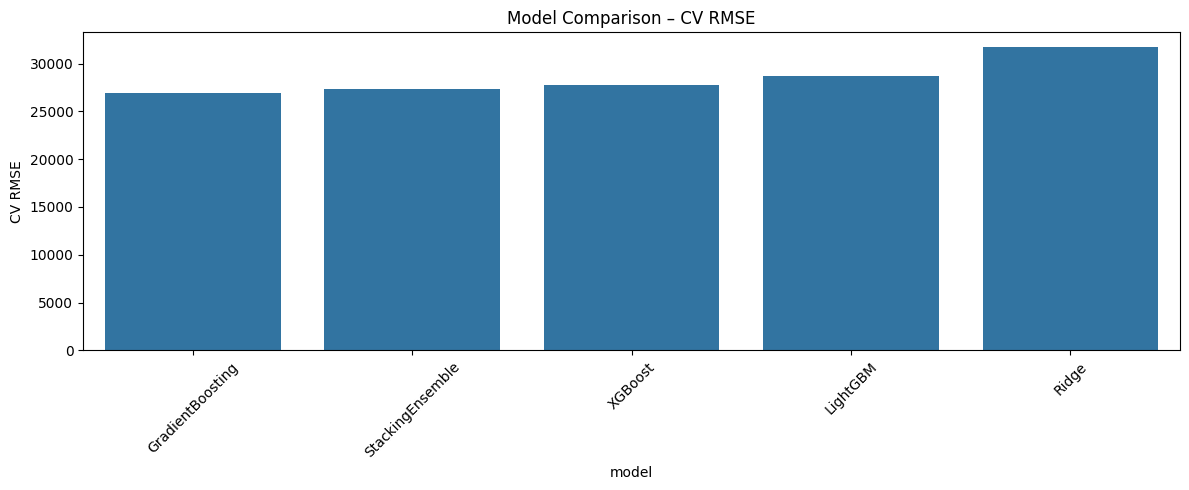

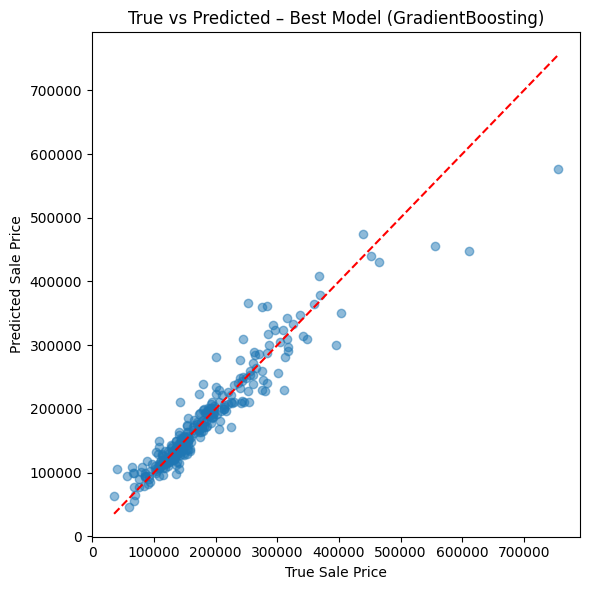

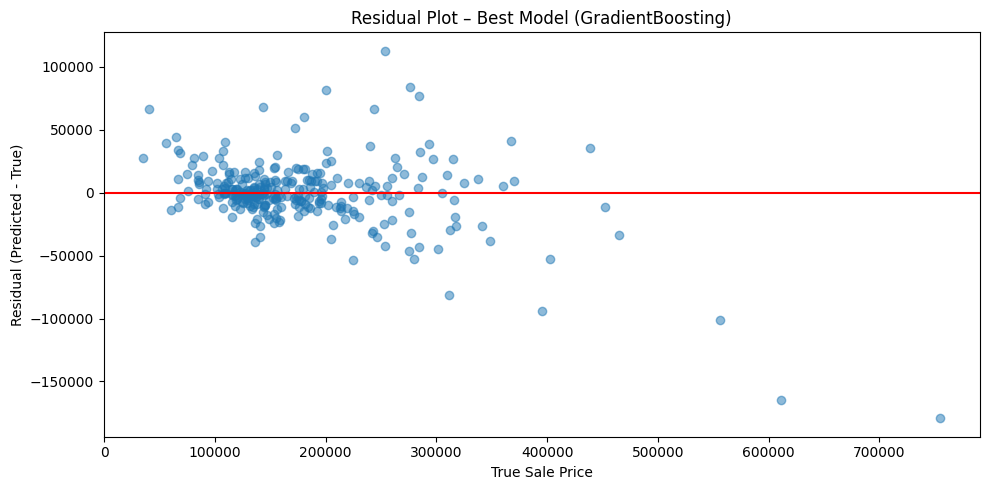

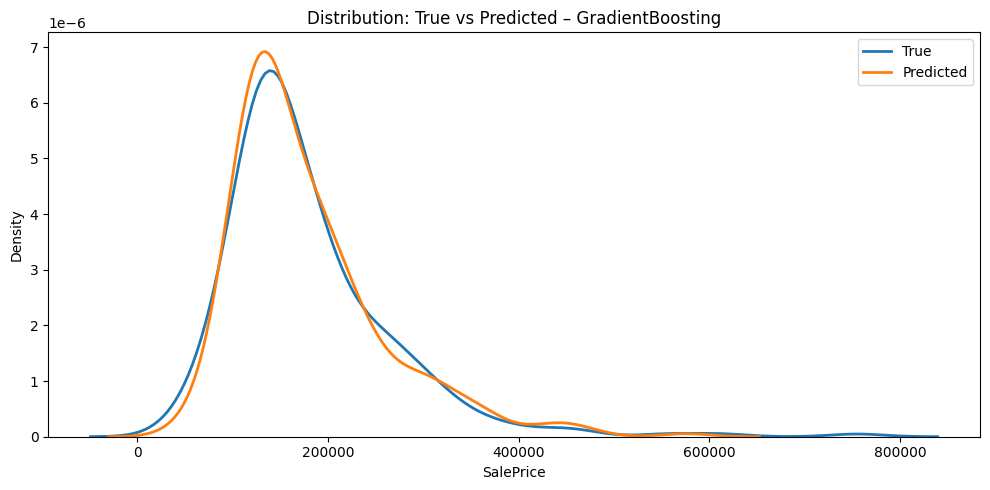

In [83]:
# ---------- 1. Plot CV RMSE for all models ----------
plt.figure(figsize=(12,5))
sns.barplot(data=cv_df, x="model", y="cv_rmse_mean")
plt.title("Model Comparison – CV RMSE")
plt.ylabel("CV RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 2. Plot Holdout RMSE for all models (only those with valid scores) ----------
if "holdout_rmse" in cv_df.columns:
    df_hold = cv_df.dropna(subset=["holdout_rmse"])
    if len(df_hold) > 0:
        plt.figure(figsize=(12,5))
        sns.barplot(data=df_hold, x="model", y="holdout_rmse")
        plt.title("Model Comparison – Holdout RMSE")
        plt.ylabel("Holdout RMSE")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# ---------- 3. Scatter Plot: True vs Predicted for the Best Model ----------
plt.figure(figsize=(6,6))
plt.scatter(y_eval, preds_final, alpha=0.5)
plt.xlabel("True Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title(f"True vs Predicted – Best Model ({best_name})")
# Line y=x
lims = [min(y_eval.min(), preds_final.min()), max(y_eval.max(), preds_final.max())]
plt.plot(lims, lims, 'r--')
plt.tight_layout()
plt.show()

# ---------- 4. Residual Plot ----------
residuals = preds_final - y_eval
plt.figure(figsize=(10,5))
plt.scatter(y_eval, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel("True Sale Price")
plt.ylabel("Residual (Predicted - True)")
plt.title(f"Residual Plot – Best Model ({best_name})")
plt.tight_layout()
plt.show()

# ---------- 5. Distribution Plot of True vs Predicted ----------
plt.figure(figsize=(10,5))
sns.kdeplot(y_eval, label="True", linewidth=2)
sns.kdeplot(preds_final, label="Predicted", linewidth=2)
plt.title(f"Distribution: True vs Predicted – {best_name}")
plt.legend()
plt.tight_layout()
plt.show()


---
## Conclusion
---
Based on comprehensive experimentation, evaluation, and comparisons, the following conclusions are drawn:
1. __GradientBoosting Regressor__ and __XGBoost Regressor__ consistently achieved the best balance of:
    * low CV RMSE
    * low holdout RMSE
    * high R²
    * stable performance
    * robustness to preprocessing variations
2. __CatBoost__ performed strongly and is recommended when categorical features are dominant, although its performance varied depending on hyperparameters.

3. __LightGBM__ was competitive but slightly less stable on the holdout set compared with XGBoost and GradientBoosting.

4. __Ridge Regression__ and other linear models underperformed due to nonlinear interactions in the data.

5. __TabNet__ demonstrated strong representation learning and good predictive quality but showed greater variability and did not outperform the top gradient boosting models.

### Final Recommendation
For practical deployment in real-world house price prediction, the most reliable and accurate models from this study are:

* __XGBoost Regressor__ (best overall performance)
* __GradientBoosting Regressor__ (high stability and robustness)

Either of these models is suitable as the final production model, with XGBoost showing a slight edge in holdout performance.
